In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch
import gc

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


True


## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [2]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [3]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load(
#    '../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt'
)['hyper_parameters']['genes']

In [4]:
CELLTYPES = [
"retinal rod cell",
"Mueller cell",
"amacrine cell",
"ON-bipolar cell",
"rod bipolar cell",
"retinal cone cell",
"retina horizontal cell",
"retinal ganglion cell",
"astrocyte",
"microglial cell",
]

MAXCELLS = 1024
NUM_GENES = 5000

In [5]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
adata = sc.read_h5ad('../../scPRINT/data/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 51370 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'desc

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:07,  1.60it/s]


  3%|▎         | 6/205 [00:00<00:19, 10.44it/s]


  5%|▌         | 11/205 [00:00<00:10, 18.37it/s]


  8%|▊         | 16/205 [00:00<00:07, 25.14it/s]


 10%|█         | 21/205 [00:01<00:06, 30.62it/s]


 13%|█▎        | 26/205 [00:01<00:05, 35.07it/s]


 15%|█▌        | 31/205 [00:01<00:04, 38.15it/s]


 18%|█▊        | 36/205 [00:01<00:04, 40.58it/s]


 20%|██        | 41/205 [00:01<00:03, 42.36it/s]


 22%|██▏       | 46/205 [00:01<00:03, 43.65it/s]


 25%|██▍       | 51/205 [00:01<00:03, 44.58it/s]


 27%|██▋       | 56/205 [00:01<00:03, 45.24it/s]


 30%|██▉       | 61/205 [00:01<00:03, 45.70it/s]


 32%|███▏      | 66/205 [00:02<00:03, 46.03it/s]


 35%|███▍      | 71/205 [00:02<00:02, 46.27it/s]


 37%|███▋      | 76/205 [00:02<00:02, 46.43it/s]


 40%|███▉      | 81/205 [00:02<00:02, 46.55it/s]


 42%|████▏     | 86/205 [00:02<00:02, 46.63it/s]


 44%|████▍     | 91/205 [00:02<00:02, 46.69it/s]


 47%|████▋     | 96/205 [00:02<00:02, 46.72it/s]


 49%|████▉     | 101/205 [00:02<00:02, 46.74it/s]


 52%|█████▏    | 106/205 [00:02<00:02, 46.75it/s]


 54%|█████▍    | 111/205 [00:02<00:02, 46.76it/s]


 57%|█████▋    | 116/205 [00:03<00:01, 46.77it/s]


 59%|█████▉    | 121/205 [00:03<00:01, 46.84it/s]


 61%|██████▏   | 126/205 [00:03<00:01, 46.84it/s]


 64%|██████▍   | 131/205 [00:03<00:01, 46.91it/s]


 66%|██████▋   | 136/205 [00:03<00:01, 46.93it/s]


 69%|██████▉   | 141/205 [00:03<00:01, 46.92it/s]


 71%|███████   | 146/205 [00:03<00:01, 46.90it/s]


 74%|███████▎  | 151/205 [00:03<00:01, 46.89it/s]


 76%|███████▌  | 156/205 [00:03<00:01, 46.87it/s]


 79%|███████▊  | 161/205 [00:04<00:00, 46.87it/s]


 81%|████████  | 166/205 [00:04<00:00, 46.85it/s]


 83%|████████▎ | 171/205 [00:04<00:00, 46.84it/s]


 86%|████████▌ | 176/205 [00:04<00:00, 46.84it/s]


 88%|████████▊ | 181/205 [00:04<00:00, 46.84it/s]


 91%|█████████ | 186/205 [00:04<00:00, 46.87it/s]


 93%|█████████▎| 191/205 [00:04<00:00, 46.85it/s]


 96%|█████████▌| 196/205 [00:04<00:00, 46.85it/s]


 98%|█████████▊| 201/205 [00:04<00:00, 46.84it/s]


100%|██████████| 205/205 [00:04<00:00, 41.16it/s]

base enrichment


Top central genes: []


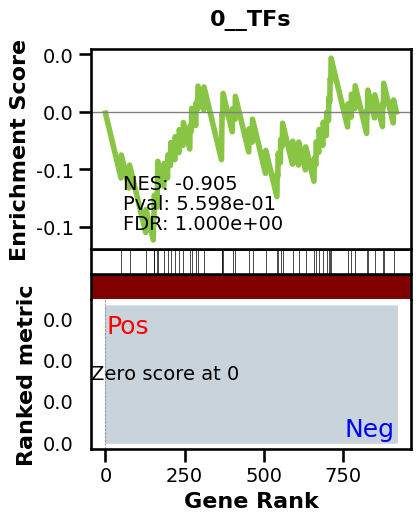

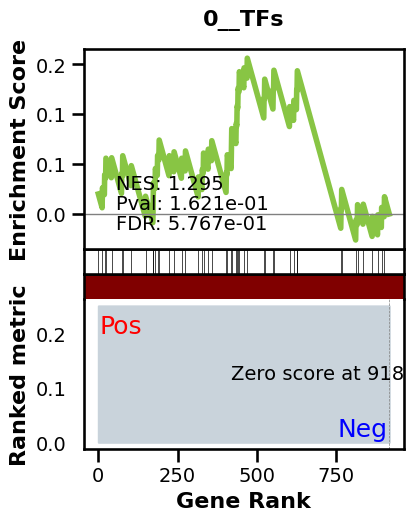

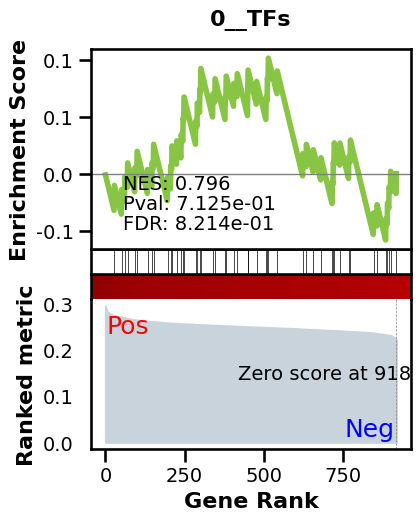

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 587 genes
intersection pct: 0.6387377584330794
precision:  0.0007864897886925406 
recall:  1.0 
random precision: 0.0007878319214377497



  0%|          | 0/128 [00:00<?, ?it/s]


100%|██████████| 128/128 [00:00<00:00, 2523.09it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0010305593982646356
EPR: 0.0


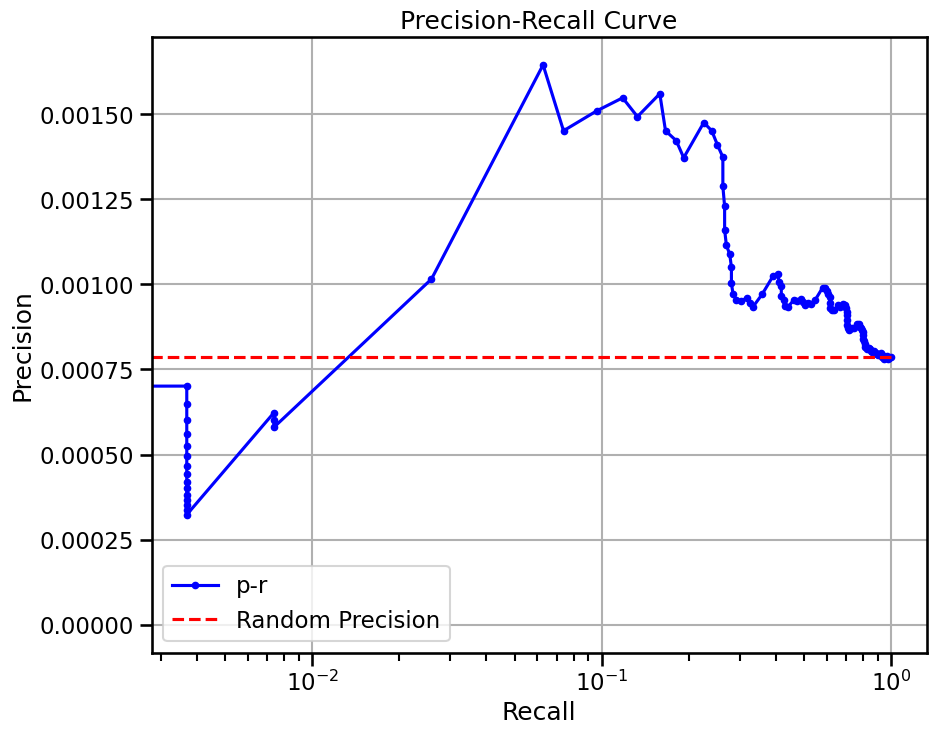

base enrichment


Top central genes: []


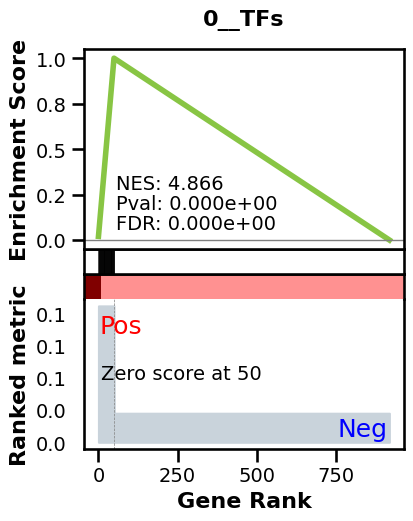

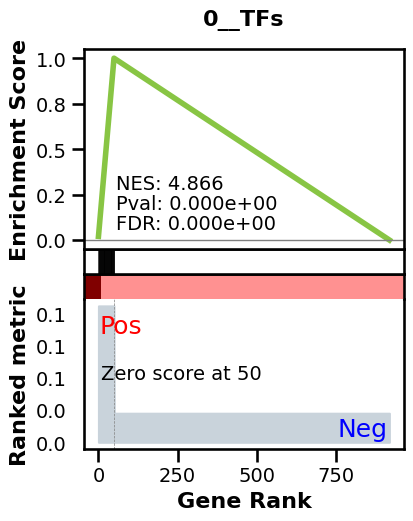

2024-07-02 11:17:10,522 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.



2024-07-02 11:17:10,522 [ERROR] The first entry of your gene_sets (gmt) look like this : { 0__TFs: [AC008770, AC023509, AC092835, AC138696, ADNP, ADNP2, AEBP1, AEBP2, AHCTF1, AHDC1, AHR, AHRR, AIRE, AKAP8, AKAP8L, AKNA, ALX1, ALX3, ALX4, ANHX, ANKZF1, AR, ARGFX, ARHGAP35, ARID2, ARID3A, ARID3B, ARID3C, ARID5A, ARID5B, ARNT, ARNT2, ARNTL, ARNTL2, ARX, ASCL1, ASCL2, ASCL3, ASCL4, ASCL5, ASH1L, ATF1, ATF2, ATF3, ATF4, ATF5, ATF6, ATF6B, ATF7, ATMIN, ATOH1, ATOH7, ATOH8, BACH1, BACH2, BARHL1, BARHL2, BARX1, BARX2, BATF, BATF2, BATF3, BAZ2A, BAZ2B, BBX, BCL11A, BCL11B, BCL6, BCL6B, BHLHA15, BHLHA9, BHLHE22, BHLHE23, BHLHE40, BHLHE41, BNC1, BNC2, BORCS8-MEF2B, BPTF, BRF2, BSX, C11orf95, CAMTA1, CAMTA2, CARF, CASZ1, CBX2, CC2D1A, CCDC169-SOHLH2, CCDC17, CDC5L, CDX1, CDX2, CDX4, CEBPA, CEBPB, CEBPD, CEBPE, CEBPG, CEBPZ, CENPA, CENPB, CENPBD1, CENPS, CENPT, CENPX, CGGBP1, CHAMP1, CHCHD3, CIC, CLOCK, CPEB1, CPXCR1, CREB1, CREB3, CREB3L1, CREB3L2, CREB3L3, CREB3L4, CREB5, CREBL2, CREBZF, CREM, CR

2024-07-02 11:17:10,522 [ERROR] The first 5 genes look like this : [ HEYL, ELF3, IRF7, MEOX2, RAG1 ]


raised a lookup error


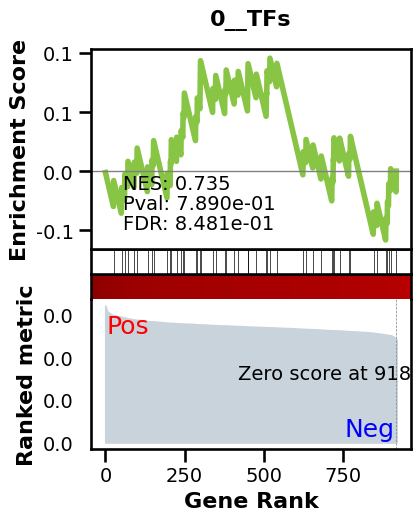

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 587 genes
intersection pct: 0.6387377584330794
precision:  0.005719153078607934 
recall:  0.5202952029520295 
random precision: 0.0007878319214377497



  0%|          | 0/128 [00:00<?, ?it/s]


100%|██████████| 128/128 [00:00<00:00, 2530.99it/s]

Area Under Precision-Recall Curve (AUPRC):  0.005335114997087407
EPR: 9.492461408769918


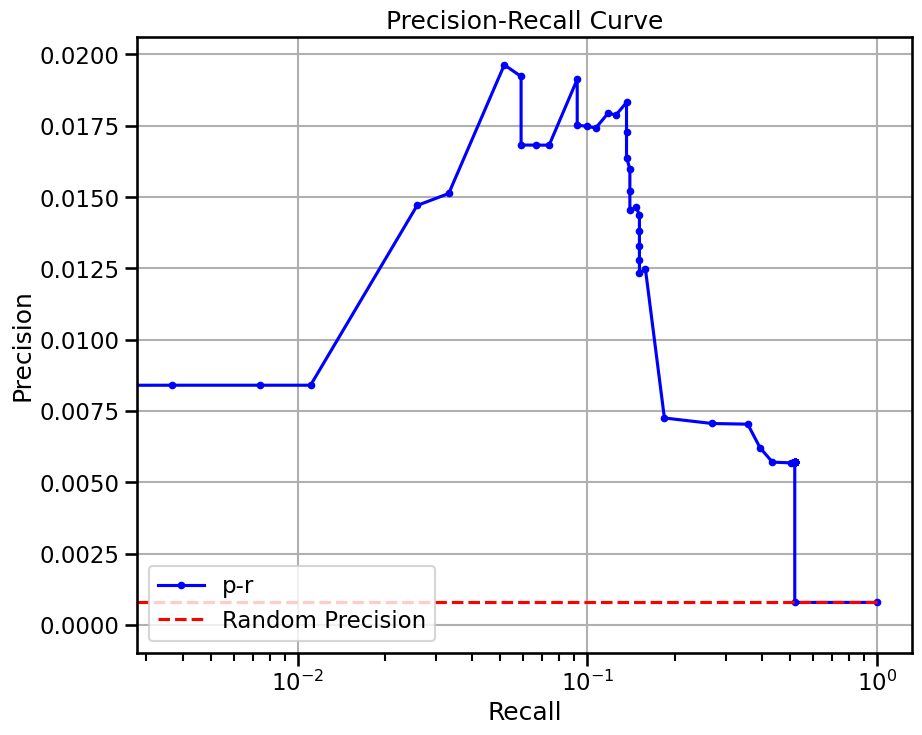


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:13,  2.76it/s]


  1%|          | 2/205 [00:00<01:14,  2.73it/s]


  1%|▏         | 3/205 [00:01<01:14,  2.72it/s]


  2%|▏         | 4/205 [00:01<01:13,  2.72it/s]


  2%|▏         | 5/205 [00:01<01:13,  2.71it/s]


  3%|▎         | 6/205 [00:02<01:13,  2.71it/s]


  3%|▎         | 7/205 [00:02<01:13,  2.71it/s]


  4%|▍         | 8/205 [00:02<01:12,  2.71it/s]


  4%|▍         | 9/205 [00:03<01:12,  2.71it/s]


  5%|▍         | 10/205 [00:03<01:11,  2.71it/s]


  5%|▌         | 11/205 [00:04<01:11,  2.71it/s]


  6%|▌         | 12/205 [00:04<01:11,  2.71it/s]


  6%|▋         | 13/205 [00:04<01:10,  2.71it/s]


  7%|▋         | 14/205 [00:05<01:10,  2.71it/s]


  7%|▋         | 15/205 [00:05<01:10,  2.71it/s]


  8%|▊         | 16/205 [00:05<01:09,  2.71it/s]


  8%|▊         | 17/205 [00:06<01:09,  2.71it/s]


  9%|▉         | 18/205 [00:06<01:09,  2.71it/s]


  9%|▉         | 19/205 [00:07<01:08,  2.71it/s]


 10%|▉         | 20/205 [00:07<01:08,  2.71it/s]


 10%|█         | 21/205 [00:07<01:07,  2.71it/s]


 11%|█         | 22/205 [00:08<01:07,  2.71it/s]


 11%|█         | 23/205 [00:08<01:07,  2.71it/s]


 12%|█▏        | 24/205 [00:08<01:06,  2.71it/s]


 12%|█▏        | 25/205 [00:09<01:06,  2.71it/s]


 13%|█▎        | 26/205 [00:09<01:06,  2.71it/s]


 13%|█▎        | 27/205 [00:09<01:05,  2.71it/s]


 14%|█▎        | 28/205 [00:10<01:05,  2.71it/s]


 14%|█▍        | 29/205 [00:10<01:05,  2.71it/s]


 15%|█▍        | 30/205 [00:11<01:04,  2.71it/s]


 15%|█▌        | 31/205 [00:11<01:04,  2.71it/s]


 16%|█▌        | 32/205 [00:11<01:03,  2.71it/s]


 16%|█▌        | 33/205 [00:12<01:03,  2.71it/s]


 17%|█▋        | 34/205 [00:12<01:03,  2.71it/s]


 17%|█▋        | 35/205 [00:12<01:02,  2.71it/s]


 18%|█▊        | 36/205 [00:13<01:02,  2.71it/s]


 18%|█▊        | 37/205 [00:13<01:02,  2.71it/s]


 19%|█▊        | 38/205 [00:14<01:01,  2.71it/s]


 19%|█▉        | 39/205 [00:14<01:01,  2.71it/s]


 20%|█▉        | 40/205 [00:14<01:00,  2.71it/s]


 20%|██        | 41/205 [00:15<01:00,  2.71it/s]


 20%|██        | 42/205 [00:15<01:00,  2.71it/s]


 21%|██        | 43/205 [00:15<00:59,  2.71it/s]


 21%|██▏       | 44/205 [00:16<00:59,  2.71it/s]


 22%|██▏       | 45/205 [00:16<00:59,  2.71it/s]


 22%|██▏       | 46/205 [00:16<00:58,  2.71it/s]


 23%|██▎       | 47/205 [00:17<00:58,  2.71it/s]


 23%|██▎       | 48/205 [00:17<00:57,  2.71it/s]


 24%|██▍       | 49/205 [00:18<00:57,  2.71it/s]


 24%|██▍       | 50/205 [00:18<00:57,  2.71it/s]


 25%|██▍       | 51/205 [00:18<00:56,  2.70it/s]


 25%|██▌       | 52/205 [00:19<00:56,  2.71it/s]


 26%|██▌       | 53/205 [00:19<00:56,  2.71it/s]


 26%|██▋       | 54/205 [00:19<00:55,  2.71it/s]


 27%|██▋       | 55/205 [00:20<00:55,  2.71it/s]


 27%|██▋       | 56/205 [00:20<00:55,  2.71it/s]


 28%|██▊       | 57/205 [00:21<00:54,  2.71it/s]


 28%|██▊       | 58/205 [00:21<00:54,  2.71it/s]


 29%|██▉       | 59/205 [00:21<00:53,  2.71it/s]


 29%|██▉       | 60/205 [00:22<00:53,  2.71it/s]


 30%|██▉       | 61/205 [00:22<00:53,  2.71it/s]


 30%|███       | 62/205 [00:22<00:52,  2.71it/s]


 31%|███       | 63/205 [00:23<00:52,  2.71it/s]


 31%|███       | 64/205 [00:23<00:52,  2.71it/s]


 32%|███▏      | 65/205 [00:24<00:51,  2.71it/s]


 32%|███▏      | 66/205 [00:24<00:51,  2.71it/s]


 33%|███▎      | 67/205 [00:24<00:50,  2.71it/s]


 33%|███▎      | 68/205 [00:25<00:50,  2.71it/s]


 34%|███▎      | 69/205 [00:25<00:50,  2.70it/s]


 34%|███▍      | 70/205 [00:25<00:49,  2.71it/s]


 35%|███▍      | 71/205 [00:26<00:49,  2.71it/s]


 35%|███▌      | 72/205 [00:26<00:49,  2.71it/s]


 36%|███▌      | 73/205 [00:26<00:48,  2.71it/s]


 36%|███▌      | 74/205 [00:27<00:48,  2.71it/s]


 37%|███▋      | 75/205 [00:27<00:48,  2.71it/s]


 37%|███▋      | 76/205 [00:28<00:47,  2.71it/s]


 38%|███▊      | 77/205 [00:28<00:47,  2.71it/s]


 38%|███▊      | 78/205 [00:28<00:46,  2.71it/s]


 39%|███▊      | 79/205 [00:29<00:46,  2.71it/s]


 39%|███▉      | 80/205 [00:29<00:46,  2.71it/s]


 40%|███▉      | 81/205 [00:29<00:45,  2.71it/s]


 40%|████      | 82/205 [00:30<00:45,  2.70it/s]


 40%|████      | 83/205 [00:30<00:45,  2.70it/s]


 41%|████      | 84/205 [00:31<00:44,  2.70it/s]


 41%|████▏     | 85/205 [00:31<00:44,  2.70it/s]


 42%|████▏     | 86/205 [00:31<00:44,  2.70it/s]


 42%|████▏     | 87/205 [00:32<00:43,  2.70it/s]


 43%|████▎     | 88/205 [00:32<00:43,  2.71it/s]


 43%|████▎     | 89/205 [00:32<00:42,  2.70it/s]


 44%|████▍     | 90/205 [00:33<00:42,  2.71it/s]


 44%|████▍     | 91/205 [00:33<00:42,  2.71it/s]


 45%|████▍     | 92/205 [00:33<00:41,  2.71it/s]


 45%|████▌     | 93/205 [00:34<00:41,  2.71it/s]


 46%|████▌     | 94/205 [00:34<00:41,  2.71it/s]


 46%|████▋     | 95/205 [00:35<00:40,  2.71it/s]


 47%|████▋     | 96/205 [00:35<00:40,  2.71it/s]


 47%|████▋     | 97/205 [00:35<00:39,  2.70it/s]


 48%|████▊     | 98/205 [00:36<00:39,  2.70it/s]


 48%|████▊     | 99/205 [00:36<00:39,  2.70it/s]


 49%|████▉     | 100/205 [00:36<00:38,  2.71it/s]


 49%|████▉     | 101/205 [00:37<00:38,  2.71it/s]


 50%|████▉     | 102/205 [00:37<00:38,  2.71it/s]


 50%|█████     | 103/205 [00:38<00:37,  2.71it/s]


 51%|█████     | 104/205 [00:38<00:37,  2.71it/s]


 51%|█████     | 105/205 [00:38<00:36,  2.70it/s]


 52%|█████▏    | 106/205 [00:39<00:36,  2.70it/s]


 52%|█████▏    | 107/205 [00:39<00:36,  2.71it/s]


 53%|█████▎    | 108/205 [00:39<00:35,  2.71it/s]


 53%|█████▎    | 109/205 [00:40<00:35,  2.71it/s]


 54%|█████▎    | 110/205 [00:40<00:35,  2.71it/s]


 54%|█████▍    | 111/205 [00:41<00:34,  2.71it/s]


 55%|█████▍    | 112/205 [00:41<00:34,  2.71it/s]


 55%|█████▌    | 113/205 [00:41<00:33,  2.71it/s]


 56%|█████▌    | 114/205 [00:42<00:33,  2.71it/s]


 56%|█████▌    | 115/205 [00:42<00:33,  2.71it/s]


 57%|█████▋    | 116/205 [00:42<00:32,  2.71it/s]


 57%|█████▋    | 117/205 [00:43<00:32,  2.71it/s]


 58%|█████▊    | 118/205 [00:43<00:32,  2.71it/s]


 58%|█████▊    | 119/205 [00:43<00:31,  2.71it/s]


 59%|█████▊    | 120/205 [00:44<00:31,  2.71it/s]


 59%|█████▉    | 121/205 [00:44<00:31,  2.71it/s]


 60%|█████▉    | 122/205 [00:45<00:30,  2.71it/s]


 60%|██████    | 123/205 [00:45<00:30,  2.70it/s]


 60%|██████    | 124/205 [00:45<00:29,  2.71it/s]


 61%|██████    | 125/205 [00:46<00:29,  2.71it/s]


 61%|██████▏   | 126/205 [00:46<00:29,  2.71it/s]


 62%|██████▏   | 127/205 [00:46<00:28,  2.71it/s]


 62%|██████▏   | 128/205 [00:47<00:28,  2.71it/s]


 63%|██████▎   | 129/205 [00:47<00:28,  2.71it/s]


 63%|██████▎   | 130/205 [00:48<00:27,  2.71it/s]


 64%|██████▍   | 131/205 [00:48<00:27,  2.71it/s]


 64%|██████▍   | 132/205 [00:48<00:27,  2.70it/s]


 65%|██████▍   | 133/205 [00:49<00:26,  2.70it/s]


 65%|██████▌   | 134/205 [00:49<00:26,  2.70it/s]


 66%|██████▌   | 135/205 [00:49<00:25,  2.70it/s]


 66%|██████▋   | 136/205 [00:50<00:25,  2.71it/s]


 67%|██████▋   | 137/205 [00:50<00:25,  2.70it/s]


 67%|██████▋   | 138/205 [00:50<00:24,  2.71it/s]


 68%|██████▊   | 139/205 [00:51<00:24,  2.71it/s]


 68%|██████▊   | 140/205 [00:51<00:24,  2.71it/s]


 69%|██████▉   | 141/205 [00:52<00:23,  2.71it/s]


 69%|██████▉   | 142/205 [00:52<00:23,  2.71it/s]


 70%|██████▉   | 143/205 [00:52<00:22,  2.71it/s]


 70%|███████   | 144/205 [00:53<00:22,  2.71it/s]


 71%|███████   | 145/205 [00:53<00:22,  2.71it/s]


 71%|███████   | 146/205 [00:53<00:21,  2.71it/s]


 72%|███████▏  | 147/205 [00:54<00:21,  2.71it/s]


 72%|███████▏  | 148/205 [00:54<00:21,  2.71it/s]


 73%|███████▎  | 149/205 [00:55<00:20,  2.71it/s]


 73%|███████▎  | 150/205 [00:55<00:20,  2.71it/s]


 74%|███████▎  | 151/205 [00:55<00:19,  2.71it/s]


 74%|███████▍  | 152/205 [00:56<00:19,  2.71it/s]


 75%|███████▍  | 153/205 [00:56<00:19,  2.71it/s]


 75%|███████▌  | 154/205 [00:56<00:18,  2.71it/s]


 76%|███████▌  | 155/205 [00:57<00:18,  2.71it/s]


 76%|███████▌  | 156/205 [00:57<00:18,  2.71it/s]


 77%|███████▋  | 157/205 [00:58<00:17,  2.71it/s]


 77%|███████▋  | 158/205 [00:58<00:17,  2.71it/s]


 78%|███████▊  | 159/205 [00:58<00:16,  2.71it/s]


 78%|███████▊  | 160/205 [00:59<00:16,  2.71it/s]


 79%|███████▊  | 161/205 [00:59<00:16,  2.71it/s]


 79%|███████▉  | 162/205 [00:59<00:15,  2.71it/s]


 80%|███████▉  | 163/205 [01:00<00:15,  2.71it/s]


 80%|████████  | 164/205 [01:00<00:15,  2.71it/s]


 80%|████████  | 165/205 [01:00<00:14,  2.71it/s]


 81%|████████  | 166/205 [01:01<00:14,  2.71it/s]


 81%|████████▏ | 167/205 [01:01<00:14,  2.71it/s]


 82%|████████▏ | 168/205 [01:02<00:13,  2.71it/s]


 82%|████████▏ | 169/205 [01:02<00:13,  2.71it/s]


 83%|████████▎ | 170/205 [01:02<00:12,  2.71it/s]


 83%|████████▎ | 171/205 [01:03<00:12,  2.71it/s]


 84%|████████▍ | 172/205 [01:03<00:12,  2.71it/s]


 84%|████████▍ | 173/205 [01:03<00:11,  2.71it/s]


 85%|████████▍ | 174/205 [01:04<00:11,  2.71it/s]


 85%|████████▌ | 175/205 [01:04<00:11,  2.71it/s]


 86%|████████▌ | 176/205 [01:05<00:10,  2.71it/s]


 86%|████████▋ | 177/205 [01:05<00:10,  2.71it/s]


 87%|████████▋ | 178/205 [01:05<00:09,  2.71it/s]


 87%|████████▋ | 179/205 [01:06<00:09,  2.71it/s]


 88%|████████▊ | 180/205 [01:06<00:09,  2.71it/s]


 88%|████████▊ | 181/205 [01:06<00:08,  2.71it/s]


 89%|████████▉ | 182/205 [01:07<00:08,  2.71it/s]


 89%|████████▉ | 183/205 [01:07<00:08,  2.71it/s]


 90%|████████▉ | 184/205 [01:07<00:07,  2.71it/s]


 90%|█████████ | 185/205 [01:08<00:07,  2.71it/s]


 91%|█████████ | 186/205 [01:08<00:07,  2.71it/s]


 91%|█████████ | 187/205 [01:09<00:06,  2.71it/s]


 92%|█████████▏| 188/205 [01:09<00:06,  2.71it/s]


 92%|█████████▏| 189/205 [01:09<00:05,  2.71it/s]


 93%|█████████▎| 190/205 [01:10<00:05,  2.71it/s]


 93%|█████████▎| 191/205 [01:10<00:05,  2.71it/s]


 94%|█████████▎| 192/205 [01:10<00:04,  2.71it/s]


 94%|█████████▍| 193/205 [01:11<00:04,  2.71it/s]


 95%|█████████▍| 194/205 [01:11<00:04,  2.71it/s]


 95%|█████████▌| 195/205 [01:12<00:03,  2.71it/s]


 96%|█████████▌| 196/205 [01:12<00:03,  2.71it/s]


 96%|█████████▌| 197/205 [01:12<00:02,  2.71it/s]


 97%|█████████▋| 198/205 [01:13<00:02,  2.71it/s]


 97%|█████████▋| 199/205 [01:13<00:02,  2.71it/s]


 98%|█████████▊| 200/205 [01:13<00:01,  2.71it/s]


 98%|█████████▊| 201/205 [01:14<00:01,  2.71it/s]


 99%|█████████▊| 202/205 [01:14<00:01,  2.71it/s]


 99%|█████████▉| 203/205 [01:14<00:00,  2.71it/s]


100%|█████████▉| 204/205 [01:15<00:00,  2.71it/s]


100%|██████████| 205/205 [01:15<00:00,  2.86it/s]


100%|██████████| 205/205 [01:15<00:00,  2.71it/s]

base enrichment


Top central genes: []


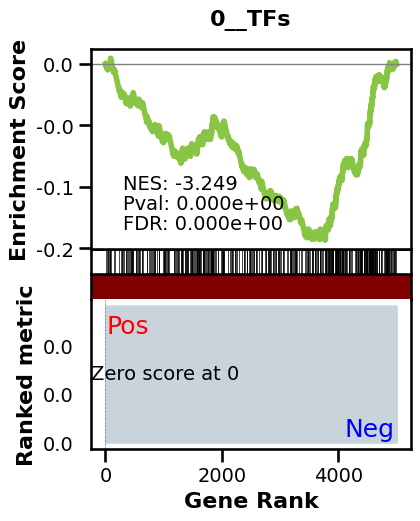

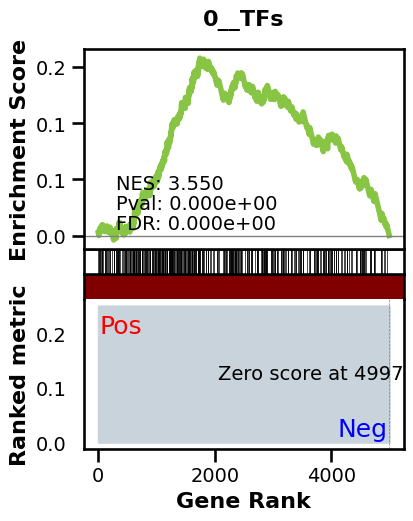

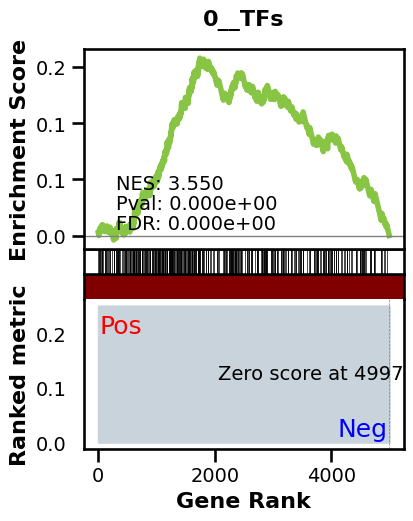

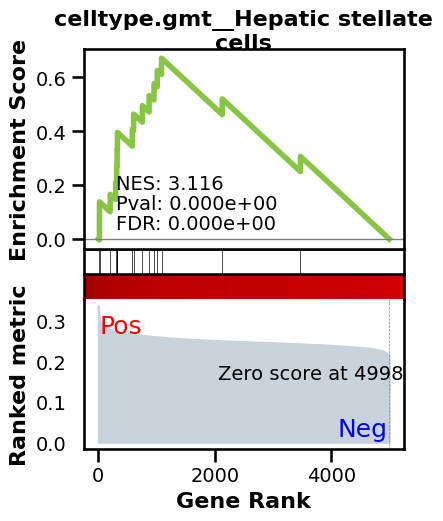

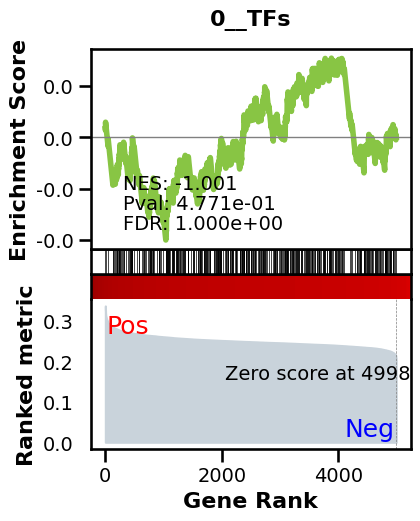

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3633 genes
intersection pct: 0.7267453490698139
precision:  0.0013746819854608288 
recall:  1.0 
random precision: 0.0013750604771969137



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 50.69it/s]


  9%|▉         | 12/128 [00:00<00:02, 50.90it/s]


 14%|█▍        | 18/128 [00:00<00:02, 50.94it/s]


 19%|█▉        | 24/128 [00:00<00:02, 50.87it/s]


 23%|██▎       | 30/128 [00:00<00:01, 50.87it/s]


 28%|██▊       | 36/128 [00:00<00:01, 50.86it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.84it/s]


 38%|███▊      | 48/128 [00:00<00:01, 50.83it/s]


 42%|████▏     | 54/128 [00:01<00:01, 50.75it/s]


 47%|████▋     | 60/128 [00:01<00:01, 50.65it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 50.71it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 50.72it/s]


 61%|██████    | 78/128 [00:01<00:00, 50.76it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 50.77it/s]


 70%|███████   | 90/128 [00:01<00:00, 50.76it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.73it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 50.74it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 50.73it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.71it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 50.76it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 50.77it/s]


100%|██████████| 128/128 [00:02<00:00, 50.76it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0015359224318999875


EPR: 1.2433608048510763


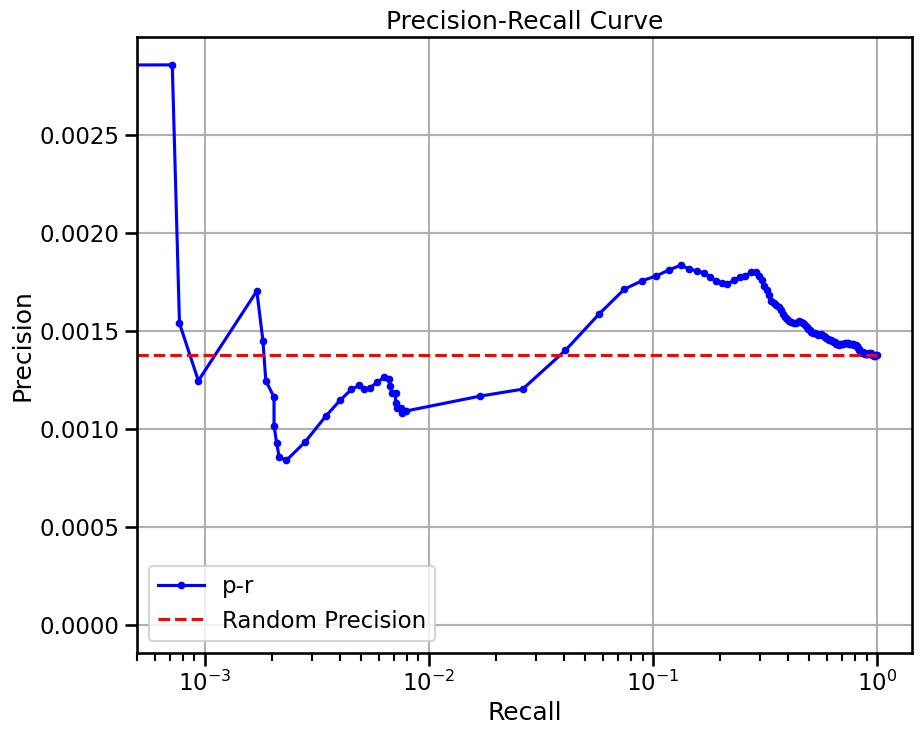

base enrichment


Top central genes: []


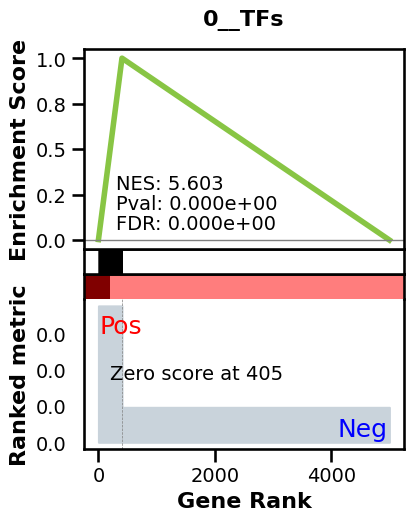

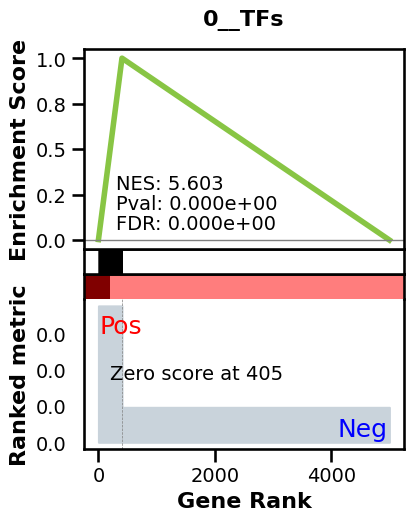

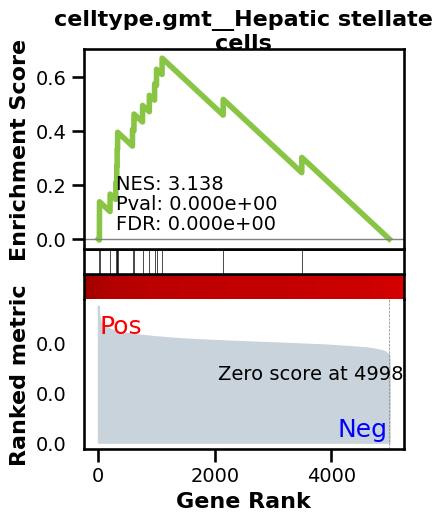

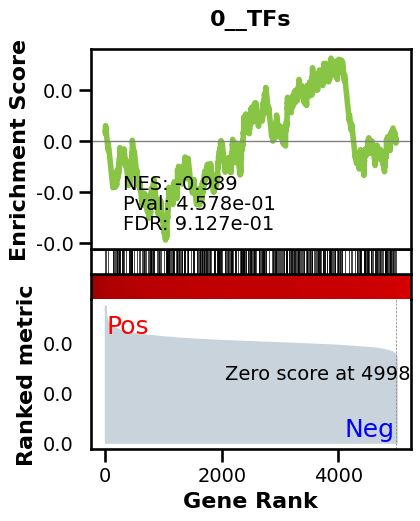

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3633 genes
intersection pct: 0.7267453490698139
precision:  0.0060602667637055805 
recall:  0.42956349206349204 
random precision: 0.0013750604771969137



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 50.90it/s]


  9%|▉         | 12/128 [00:00<00:02, 50.89it/s]


 14%|█▍        | 18/128 [00:00<00:02, 50.92it/s]


 19%|█▉        | 24/128 [00:00<00:02, 50.76it/s]


 23%|██▎       | 30/128 [00:00<00:01, 50.87it/s]


 28%|██▊       | 36/128 [00:00<00:01, 50.85it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.84it/s]


 38%|███▊      | 48/128 [00:00<00:01, 50.90it/s]


 42%|████▏     | 54/128 [00:01<00:01, 50.91it/s]


 47%|████▋     | 60/128 [00:01<00:01, 50.93it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 50.95it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 50.97it/s]


 61%|██████    | 78/128 [00:01<00:00, 50.96it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 50.91it/s]


 70%|███████   | 90/128 [00:01<00:00, 50.91it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.93it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 50.95it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 50.96it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.97it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 50.99it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 50.95it/s]


100%|██████████| 128/128 [00:02<00:00, 50.91it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0039773849050964
EPR: 5.395051665861319


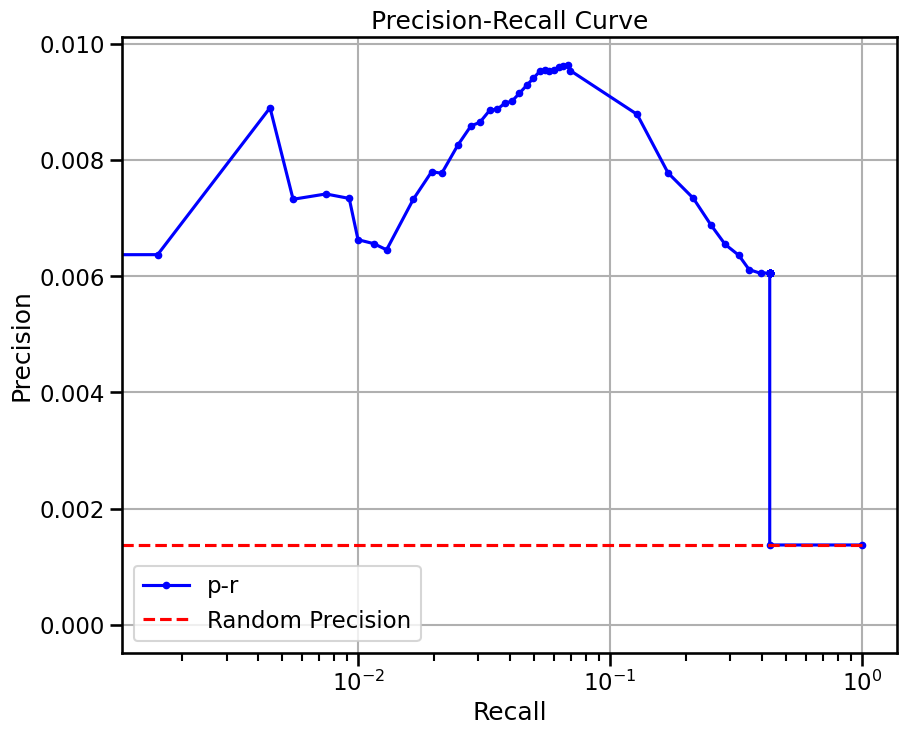


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:16,  1.49it/s]


  1%|          | 2/205 [00:01<02:16,  1.49it/s]


  1%|▏         | 3/205 [00:02<02:15,  1.50it/s]


  2%|▏         | 4/205 [00:02<02:13,  1.50it/s]


  2%|▏         | 5/205 [00:03<02:13,  1.50it/s]


  3%|▎         | 6/205 [00:04<02:12,  1.50it/s]


  3%|▎         | 7/205 [00:04<02:11,  1.50it/s]


  4%|▍         | 8/205 [00:05<02:10,  1.51it/s]


  4%|▍         | 9/205 [00:05<02:09,  1.51it/s]


  5%|▍         | 10/205 [00:06<02:09,  1.51it/s]


  5%|▌         | 11/205 [00:07<02:08,  1.51it/s]


  6%|▌         | 12/205 [00:07<02:07,  1.51it/s]


  6%|▋         | 13/205 [00:08<02:07,  1.51it/s]


  7%|▋         | 14/205 [00:09<02:06,  1.51it/s]


  7%|▋         | 15/205 [00:09<02:05,  1.51it/s]


  8%|▊         | 16/205 [00:10<02:05,  1.51it/s]


  8%|▊         | 17/205 [00:11<02:04,  1.51it/s]


  9%|▉         | 18/205 [00:11<02:03,  1.51it/s]


  9%|▉         | 19/205 [00:12<02:03,  1.51it/s]


 10%|▉         | 20/205 [00:13<02:02,  1.51it/s]


 10%|█         | 21/205 [00:13<02:01,  1.51it/s]


 11%|█         | 22/205 [00:14<02:01,  1.51it/s]


 11%|█         | 23/205 [00:15<02:00,  1.51it/s]


 12%|█▏        | 24/205 [00:15<02:00,  1.51it/s]


 12%|█▏        | 25/205 [00:16<01:59,  1.51it/s]


 13%|█▎        | 26/205 [00:17<01:58,  1.51it/s]


 13%|█▎        | 27/205 [00:17<01:58,  1.50it/s]


 14%|█▎        | 28/205 [00:18<01:57,  1.50it/s]


 14%|█▍        | 29/205 [00:19<01:56,  1.50it/s]


 15%|█▍        | 30/205 [00:19<01:56,  1.50it/s]


 15%|█▌        | 31/205 [00:20<01:55,  1.50it/s]


 16%|█▌        | 32/205 [00:21<01:55,  1.50it/s]


 16%|█▌        | 33/205 [00:21<01:54,  1.50it/s]


 17%|█▋        | 34/205 [00:22<01:53,  1.50it/s]


 17%|█▋        | 35/205 [00:23<01:53,  1.50it/s]


 18%|█▊        | 36/205 [00:23<01:52,  1.50it/s]


 18%|█▊        | 37/205 [00:24<01:51,  1.50it/s]


 19%|█▊        | 38/205 [00:25<01:51,  1.50it/s]


 19%|█▉        | 39/205 [00:25<01:51,  1.49it/s]


 20%|█▉        | 40/205 [00:26<01:50,  1.50it/s]


 20%|██        | 41/205 [00:27<01:49,  1.50it/s]


 20%|██        | 42/205 [00:27<01:48,  1.50it/s]


 21%|██        | 43/205 [00:28<01:48,  1.50it/s]


 21%|██▏       | 44/205 [00:29<01:47,  1.49it/s]


 22%|██▏       | 45/205 [00:29<01:46,  1.50it/s]


 22%|██▏       | 46/205 [00:30<01:46,  1.50it/s]


 23%|██▎       | 47/205 [00:31<01:45,  1.50it/s]


 23%|██▎       | 48/205 [00:31<01:44,  1.50it/s]


 24%|██▍       | 49/205 [00:32<01:44,  1.50it/s]


 24%|██▍       | 50/205 [00:33<01:43,  1.50it/s]


 25%|██▍       | 51/205 [00:33<01:42,  1.50it/s]


 25%|██▌       | 52/205 [00:34<01:41,  1.50it/s]


 26%|██▌       | 53/205 [00:35<01:41,  1.50it/s]


 26%|██▋       | 54/205 [00:35<01:40,  1.50it/s]


 27%|██▋       | 55/205 [00:36<01:40,  1.50it/s]


 27%|██▋       | 56/205 [00:37<01:39,  1.50it/s]


 28%|██▊       | 57/205 [00:37<01:38,  1.50it/s]


 28%|██▊       | 58/205 [00:38<01:38,  1.50it/s]


 29%|██▉       | 59/205 [00:39<01:37,  1.50it/s]


 29%|██▉       | 60/205 [00:39<01:36,  1.50it/s]


 30%|██▉       | 61/205 [00:40<01:36,  1.50it/s]


 30%|███       | 62/205 [00:41<01:35,  1.50it/s]


 31%|███       | 63/205 [00:41<01:34,  1.50it/s]


 31%|███       | 64/205 [00:42<01:34,  1.50it/s]


 32%|███▏      | 65/205 [00:43<01:33,  1.50it/s]


 32%|███▏      | 66/205 [00:43<01:32,  1.50it/s]


 33%|███▎      | 67/205 [00:44<01:32,  1.50it/s]


 33%|███▎      | 68/205 [00:45<01:31,  1.50it/s]


 34%|███▎      | 69/205 [00:45<01:30,  1.50it/s]


 34%|███▍      | 70/205 [00:46<01:30,  1.50it/s]


 35%|███▍      | 71/205 [00:47<01:29,  1.50it/s]


 35%|███▌      | 72/205 [00:47<01:28,  1.50it/s]


 36%|███▌      | 73/205 [00:48<01:28,  1.50it/s]


 36%|███▌      | 74/205 [00:49<01:27,  1.50it/s]


 37%|███▋      | 75/205 [00:49<01:26,  1.50it/s]


 37%|███▋      | 76/205 [00:50<01:26,  1.50it/s]


 38%|███▊      | 77/205 [00:51<01:25,  1.50it/s]


 38%|███▊      | 78/205 [00:51<01:24,  1.50it/s]


 39%|███▊      | 79/205 [00:52<01:24,  1.50it/s]


 39%|███▉      | 80/205 [00:53<01:23,  1.50it/s]


 40%|███▉      | 81/205 [00:53<01:22,  1.50it/s]


 40%|████      | 82/205 [00:54<01:22,  1.50it/s]


 40%|████      | 83/205 [00:55<01:21,  1.50it/s]


 41%|████      | 84/205 [00:55<01:20,  1.50it/s]


 41%|████▏     | 85/205 [00:56<01:20,  1.49it/s]


 42%|████▏     | 86/205 [00:57<01:19,  1.49it/s]


 42%|████▏     | 87/205 [00:57<01:18,  1.49it/s]


 43%|████▎     | 88/205 [00:58<01:18,  1.49it/s]


 43%|████▎     | 89/205 [00:59<01:17,  1.49it/s]


 44%|████▍     | 90/205 [00:59<01:17,  1.49it/s]


 44%|████▍     | 91/205 [01:00<01:16,  1.49it/s]


 45%|████▍     | 92/205 [01:01<01:15,  1.49it/s]


 45%|████▌     | 93/205 [01:01<01:15,  1.49it/s]


 46%|████▌     | 94/205 [01:02<01:14,  1.49it/s]


 46%|████▋     | 95/205 [01:03<01:13,  1.49it/s]


 47%|████▋     | 96/205 [01:03<01:13,  1.49it/s]


 47%|████▋     | 97/205 [01:04<01:12,  1.49it/s]


 48%|████▊     | 98/205 [01:05<01:11,  1.49it/s]


 48%|████▊     | 99/205 [01:06<01:11,  1.49it/s]


 49%|████▉     | 100/205 [01:06<01:10,  1.49it/s]


 49%|████▉     | 101/205 [01:07<01:09,  1.49it/s]


 50%|████▉     | 102/205 [01:08<01:09,  1.49it/s]


 50%|█████     | 103/205 [01:08<01:08,  1.49it/s]


 51%|█████     | 104/205 [01:09<01:07,  1.49it/s]


 51%|█████     | 105/205 [01:10<01:07,  1.49it/s]


 52%|█████▏    | 106/205 [01:10<01:06,  1.49it/s]


 52%|█████▏    | 107/205 [01:11<01:05,  1.49it/s]


 53%|█████▎    | 108/205 [01:12<01:05,  1.49it/s]


 53%|█████▎    | 109/205 [01:12<01:04,  1.49it/s]


 54%|█████▎    | 110/205 [01:13<01:03,  1.49it/s]


 54%|█████▍    | 111/205 [01:14<01:03,  1.49it/s]


 55%|█████▍    | 112/205 [01:14<01:02,  1.49it/s]


 55%|█████▌    | 113/205 [01:15<01:01,  1.49it/s]


 56%|█████▌    | 114/205 [01:16<01:01,  1.49it/s]


 56%|█████▌    | 115/205 [01:16<01:00,  1.49it/s]


 57%|█████▋    | 116/205 [01:17<01:00,  1.48it/s]


 57%|█████▋    | 117/205 [01:18<00:59,  1.48it/s]


 58%|█████▊    | 118/205 [01:18<00:58,  1.48it/s]


 58%|█████▊    | 119/205 [01:19<00:57,  1.49it/s]


 59%|█████▊    | 120/205 [01:20<00:57,  1.49it/s]


 59%|█████▉    | 121/205 [01:20<00:56,  1.49it/s]


 60%|█████▉    | 122/205 [01:21<00:55,  1.49it/s]


 60%|██████    | 123/205 [01:22<00:55,  1.49it/s]


 60%|██████    | 124/205 [01:22<00:54,  1.49it/s]


 61%|██████    | 125/205 [01:23<00:53,  1.49it/s]


 61%|██████▏   | 126/205 [01:24<00:53,  1.49it/s]


 62%|██████▏   | 127/205 [01:24<00:52,  1.49it/s]


 62%|██████▏   | 128/205 [01:25<00:51,  1.49it/s]


 63%|██████▎   | 129/205 [01:26<00:51,  1.49it/s]


 63%|██████▎   | 130/205 [01:26<00:50,  1.49it/s]


 64%|██████▍   | 131/205 [01:27<00:49,  1.49it/s]


 64%|██████▍   | 132/205 [01:28<00:49,  1.49it/s]


 65%|██████▍   | 133/205 [01:28<00:48,  1.49it/s]


 65%|██████▌   | 134/205 [01:29<00:47,  1.49it/s]


 66%|██████▌   | 135/205 [01:30<00:47,  1.49it/s]


 66%|██████▋   | 136/205 [01:30<00:46,  1.49it/s]


 67%|██████▋   | 137/205 [01:31<00:45,  1.49it/s]


 67%|██████▋   | 138/205 [01:32<00:45,  1.49it/s]


 68%|██████▊   | 139/205 [01:32<00:44,  1.49it/s]


 68%|██████▊   | 140/205 [01:33<00:43,  1.49it/s]


 69%|██████▉   | 141/205 [01:34<00:43,  1.49it/s]


 69%|██████▉   | 142/205 [01:34<00:42,  1.49it/s]


 70%|██████▉   | 143/205 [01:35<00:41,  1.49it/s]


 70%|███████   | 144/205 [01:36<00:41,  1.49it/s]


 71%|███████   | 145/205 [01:36<00:40,  1.49it/s]


 71%|███████   | 146/205 [01:37<00:39,  1.49it/s]


 72%|███████▏  | 147/205 [01:38<00:39,  1.49it/s]


 72%|███████▏  | 148/205 [01:38<00:38,  1.49it/s]


 73%|███████▎  | 149/205 [01:39<00:37,  1.49it/s]


 73%|███████▎  | 150/205 [01:40<00:37,  1.49it/s]


 74%|███████▎  | 151/205 [01:40<00:36,  1.49it/s]


 74%|███████▍  | 152/205 [01:41<00:35,  1.48it/s]


 75%|███████▍  | 153/205 [01:42<00:35,  1.48it/s]


 75%|███████▌  | 154/205 [01:42<00:34,  1.48it/s]


 76%|███████▌  | 155/205 [01:43<00:33,  1.48it/s]


 76%|███████▌  | 156/205 [01:44<00:33,  1.48it/s]


 77%|███████▋  | 157/205 [01:45<00:32,  1.48it/s]


 77%|███████▋  | 158/205 [01:45<00:31,  1.48it/s]


 78%|███████▊  | 159/205 [01:46<00:31,  1.48it/s]


 78%|███████▊  | 160/205 [01:47<00:30,  1.48it/s]


 79%|███████▊  | 161/205 [01:47<00:29,  1.48it/s]


 79%|███████▉  | 162/205 [01:48<00:28,  1.48it/s]


 80%|███████▉  | 163/205 [01:49<00:28,  1.48it/s]


 80%|████████  | 164/205 [01:49<00:27,  1.48it/s]


 80%|████████  | 165/205 [01:50<00:26,  1.48it/s]


 81%|████████  | 166/205 [01:51<00:26,  1.48it/s]


 81%|████████▏ | 167/205 [01:51<00:25,  1.48it/s]


 82%|████████▏ | 168/205 [01:52<00:24,  1.48it/s]


 82%|████████▏ | 169/205 [01:53<00:24,  1.48it/s]


 83%|████████▎ | 170/205 [01:53<00:23,  1.48it/s]


 83%|████████▎ | 171/205 [01:54<00:22,  1.48it/s]


 84%|████████▍ | 172/205 [01:55<00:22,  1.48it/s]


 84%|████████▍ | 173/205 [01:55<00:21,  1.48it/s]


 85%|████████▍ | 174/205 [01:56<00:20,  1.48it/s]


 85%|████████▌ | 175/205 [01:57<00:20,  1.48it/s]


 86%|████████▌ | 176/205 [01:57<00:19,  1.48it/s]


 86%|████████▋ | 177/205 [01:58<00:18,  1.48it/s]


 87%|████████▋ | 178/205 [01:59<00:18,  1.48it/s]


 87%|████████▋ | 179/205 [01:59<00:17,  1.47it/s]


 88%|████████▊ | 180/205 [02:00<00:16,  1.47it/s]


 88%|████████▊ | 181/205 [02:01<00:16,  1.47it/s]


 89%|████████▉ | 182/205 [02:01<00:15,  1.48it/s]


 89%|████████▉ | 183/205 [02:02<00:14,  1.48it/s]


 90%|████████▉ | 184/205 [02:03<00:14,  1.48it/s]


 90%|█████████ | 185/205 [02:03<00:13,  1.48it/s]


 91%|█████████ | 186/205 [02:04<00:12,  1.48it/s]


 91%|█████████ | 187/205 [02:05<00:12,  1.48it/s]


 92%|█████████▏| 188/205 [02:05<00:11,  1.48it/s]


 92%|█████████▏| 189/205 [02:06<00:10,  1.48it/s]


 93%|█████████▎| 190/205 [02:07<00:10,  1.48it/s]


 93%|█████████▎| 191/205 [02:07<00:09,  1.48it/s]


 94%|█████████▎| 192/205 [02:08<00:08,  1.48it/s]


 94%|█████████▍| 193/205 [02:09<00:08,  1.48it/s]


 95%|█████████▍| 194/205 [02:10<00:07,  1.48it/s]


 95%|█████████▌| 195/205 [02:10<00:06,  1.48it/s]


 96%|█████████▌| 196/205 [02:11<00:06,  1.48it/s]


 96%|█████████▌| 197/205 [02:12<00:05,  1.48it/s]


 97%|█████████▋| 198/205 [02:12<00:04,  1.48it/s]


 97%|█████████▋| 199/205 [02:13<00:04,  1.48it/s]


 98%|█████████▊| 200/205 [02:14<00:03,  1.48it/s]


 98%|█████████▊| 201/205 [02:14<00:02,  1.48it/s]


 99%|█████████▊| 202/205 [02:15<00:02,  1.48it/s]


 99%|█████████▉| 203/205 [02:16<00:01,  1.48it/s]


100%|█████████▉| 204/205 [02:16<00:00,  1.48it/s]


100%|██████████| 205/205 [02:17<00:00,  1.58it/s]


100%|██████████| 205/205 [02:17<00:00,  1.49it/s]

base enrichment


Top central genes: []


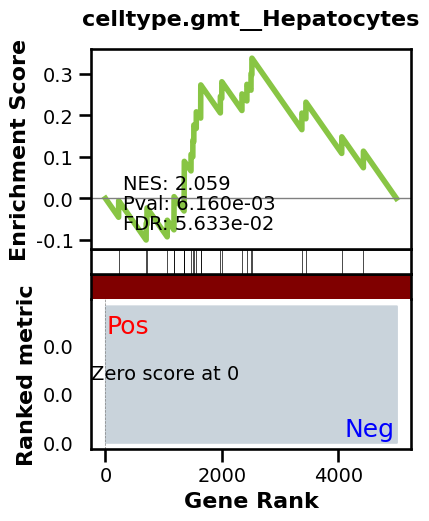

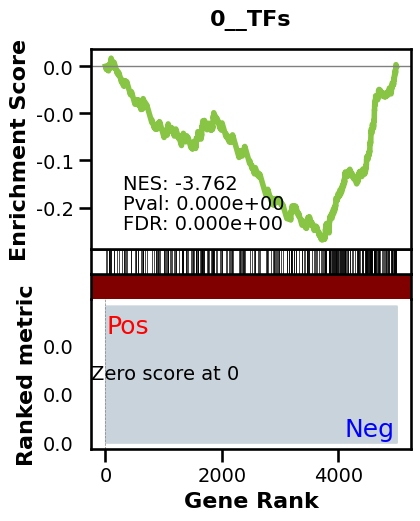

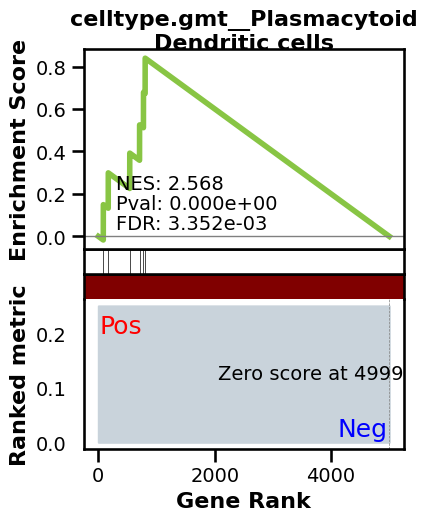

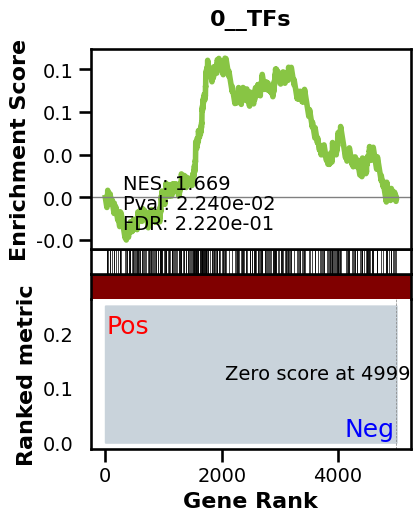

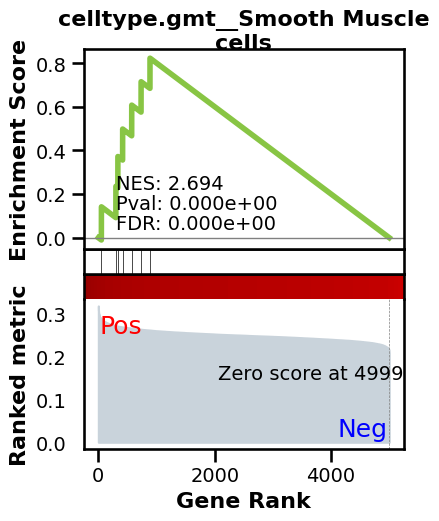

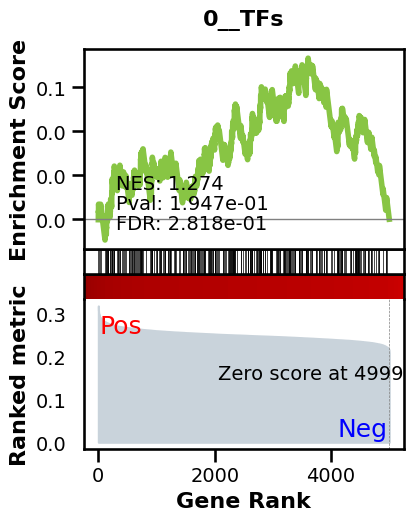

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3599 genes
intersection pct: 0.7198
precision:  0.0008199770844931533 
recall:  1.0 
random precision: 0.0008202049825155249



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 54.35it/s]


  9%|▉         | 12/128 [00:00<00:02, 54.07it/s]


 14%|█▍        | 18/128 [00:00<00:02, 54.17it/s]


 19%|█▉        | 24/128 [00:00<00:01, 53.90it/s]


 23%|██▎       | 30/128 [00:00<00:01, 54.01it/s]


 28%|██▊       | 36/128 [00:00<00:01, 54.03it/s]


 33%|███▎      | 42/128 [00:00<00:01, 54.08it/s]


 38%|███▊      | 48/128 [00:00<00:01, 54.13it/s]


 42%|████▏     | 54/128 [00:00<00:01, 54.15it/s]


 47%|████▋     | 60/128 [00:01<00:01, 54.19it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 54.22it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 54.21it/s]


 61%|██████    | 78/128 [00:01<00:00, 54.18it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 54.18it/s]


 70%|███████   | 90/128 [00:01<00:00, 54.22it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 54.22it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 54.25it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 54.22it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 54.22it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 54.20it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 54.21it/s]


100%|██████████| 128/128 [00:02<00:00, 54.15it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0009328476373872425
EPR: 1.378360281338002


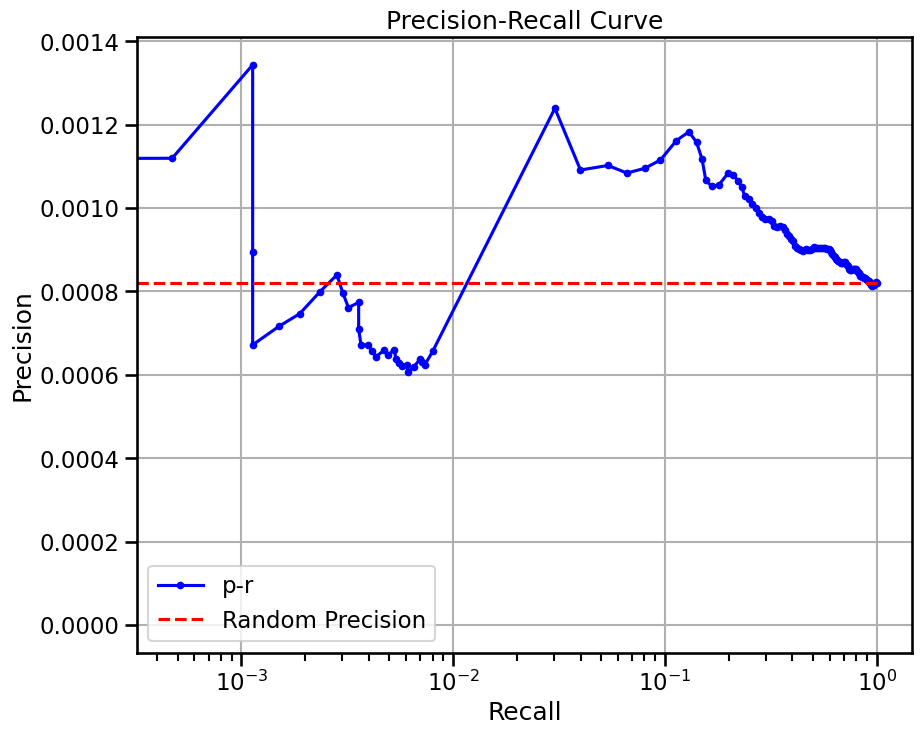

base enrichment


Top central genes: []


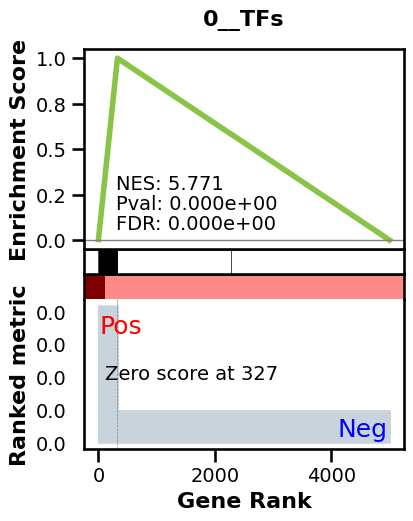

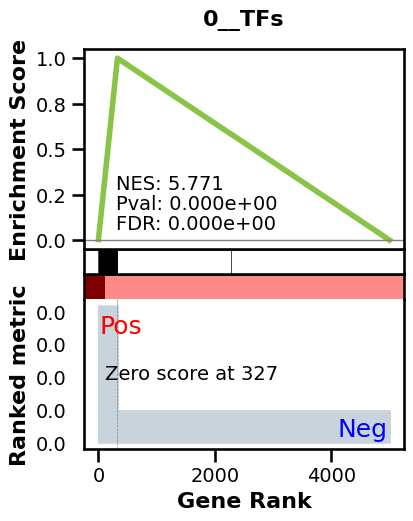

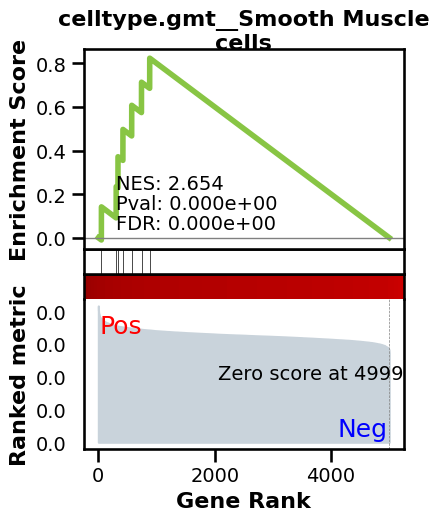

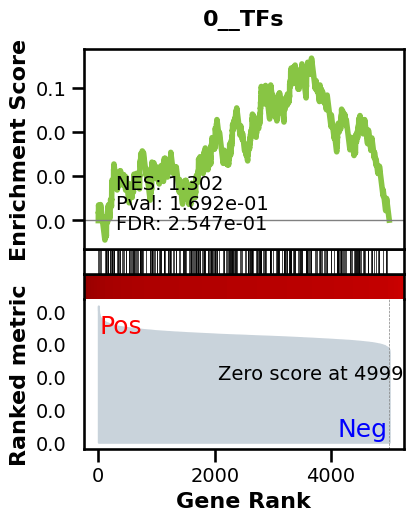

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3599 genes
intersection pct: 0.7198
precision:  0.0028948151476276903 
recall:  0.2766217870257038 
random precision: 0.0008202049825155249



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 53.90it/s]


  9%|▉         | 12/128 [00:00<00:02, 53.88it/s]


 14%|█▍        | 18/128 [00:00<00:02, 53.88it/s]


 19%|█▉        | 24/128 [00:00<00:01, 53.90it/s]


 23%|██▎       | 30/128 [00:00<00:01, 53.89it/s]


 28%|██▊       | 36/128 [00:00<00:01, 53.85it/s]


 33%|███▎      | 42/128 [00:00<00:01, 47.29it/s]


 38%|███▊      | 48/128 [00:00<00:01, 49.16it/s]


 42%|████▏     | 54/128 [00:01<00:01, 50.53it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.53it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 52.22it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 52.73it/s]


 61%|██████    | 78/128 [00:01<00:00, 53.10it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 53.25it/s]


 70%|███████   | 90/128 [00:01<00:00, 53.40it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 53.52it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 53.63it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 53.69it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 53.77it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 53.82it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 53.90it/s]


100%|██████████| 128/128 [00:02<00:00, 52.80it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0015064534496368313
EPR: 4.502569264854277


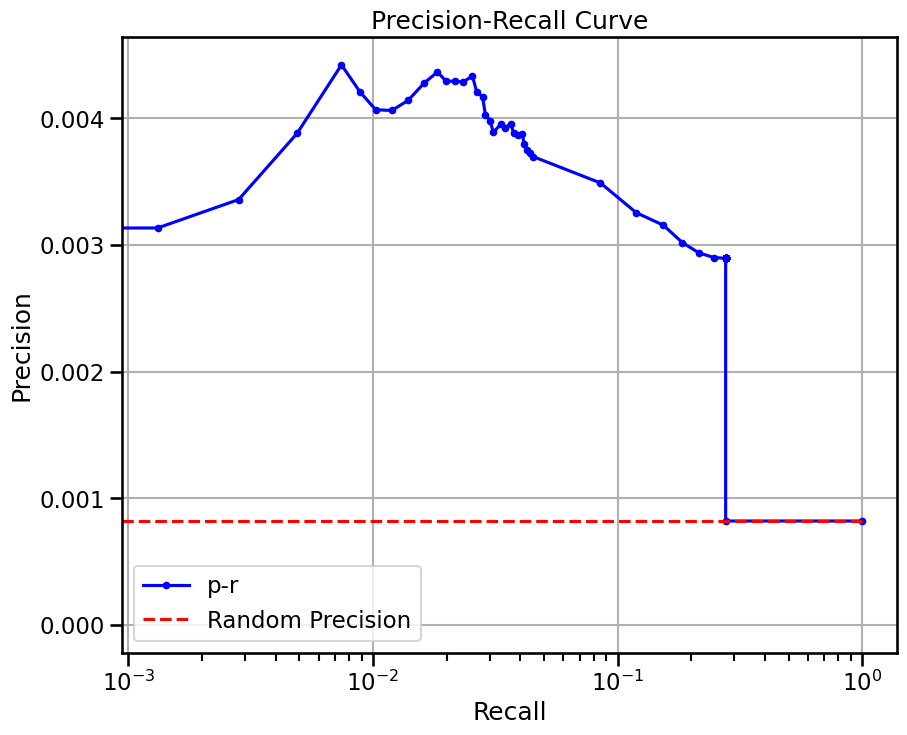


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:11,  2.84it/s]


  1%|          | 2/205 [00:00<01:11,  2.83it/s]


  1%|▏         | 3/205 [00:01<01:10,  2.87it/s]


  2%|▏         | 4/205 [00:01<01:09,  2.89it/s]


  2%|▏         | 5/205 [00:01<01:08,  2.90it/s]


  3%|▎         | 6/205 [00:02<01:08,  2.91it/s]


  3%|▎         | 7/205 [00:02<01:08,  2.91it/s]


  4%|▍         | 8/205 [00:02<01:07,  2.91it/s]


  4%|▍         | 9/205 [00:03<01:07,  2.92it/s]


  5%|▍         | 10/205 [00:03<01:06,  2.92it/s]


  5%|▌         | 11/205 [00:03<01:06,  2.92it/s]


  6%|▌         | 12/205 [00:04<01:06,  2.92it/s]


  6%|▋         | 13/205 [00:04<01:05,  2.92it/s]


  7%|▋         | 14/205 [00:04<01:05,  2.92it/s]


  7%|▋         | 15/205 [00:05<01:05,  2.92it/s]


  8%|▊         | 16/205 [00:05<01:04,  2.92it/s]


  8%|▊         | 17/205 [00:05<01:04,  2.92it/s]


  9%|▉         | 18/205 [00:06<01:04,  2.92it/s]


  9%|▉         | 19/205 [00:06<01:03,  2.92it/s]


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]


 10%|█         | 21/205 [00:07<01:03,  2.92it/s]


 11%|█         | 22/205 [00:07<01:02,  2.92it/s]


 11%|█         | 23/205 [00:07<01:02,  2.92it/s]


 12%|█▏        | 24/205 [00:08<01:01,  2.92it/s]


 12%|█▏        | 25/205 [00:08<01:01,  2.92it/s]


 13%|█▎        | 26/205 [00:08<01:01,  2.92it/s]


 13%|█▎        | 27/205 [00:09<01:00,  2.92it/s]


 14%|█▎        | 28/205 [00:09<01:00,  2.92it/s]


 14%|█▍        | 29/205 [00:09<01:00,  2.92it/s]


 15%|█▍        | 30/205 [00:10<00:59,  2.92it/s]


 15%|█▌        | 31/205 [00:10<00:59,  2.92it/s]


 16%|█▌        | 32/205 [00:10<00:59,  2.92it/s]


 16%|█▌        | 33/205 [00:11<00:58,  2.92it/s]


 17%|█▋        | 34/205 [00:11<00:58,  2.92it/s]


 17%|█▋        | 35/205 [00:12<00:58,  2.92it/s]


 18%|█▊        | 36/205 [00:12<00:57,  2.92it/s]


 18%|█▊        | 37/205 [00:12<00:57,  2.92it/s]


 19%|█▊        | 38/205 [00:13<00:57,  2.92it/s]


 19%|█▉        | 39/205 [00:13<00:56,  2.92it/s]


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]


 20%|██        | 41/205 [00:14<00:56,  2.92it/s]


 20%|██        | 42/205 [00:14<00:55,  2.92it/s]


 21%|██        | 43/205 [00:14<00:55,  2.92it/s]


 21%|██▏       | 44/205 [00:15<00:55,  2.92it/s]


 22%|██▏       | 45/205 [00:15<00:54,  2.92it/s]


 22%|██▏       | 46/205 [00:15<00:54,  2.92it/s]


 23%|██▎       | 47/205 [00:16<00:54,  2.92it/s]


 23%|██▎       | 48/205 [00:16<00:53,  2.92it/s]


 24%|██▍       | 49/205 [00:16<00:53,  2.92it/s]


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]


 25%|██▍       | 51/205 [00:17<00:52,  2.92it/s]


 25%|██▌       | 52/205 [00:17<00:52,  2.92it/s]


 26%|██▌       | 53/205 [00:18<00:52,  2.92it/s]


 26%|██▋       | 54/205 [00:18<00:51,  2.92it/s]


 27%|██▋       | 55/205 [00:18<00:51,  2.92it/s]


 27%|██▋       | 56/205 [00:19<00:51,  2.92it/s]


 28%|██▊       | 57/205 [00:19<00:50,  2.92it/s]


 28%|██▊       | 58/205 [00:19<00:50,  2.92it/s]


 29%|██▉       | 59/205 [00:20<00:49,  2.92it/s]


 29%|██▉       | 60/205 [00:20<00:49,  2.92it/s]


 30%|██▉       | 61/205 [00:20<00:49,  2.92it/s]


 30%|███       | 62/205 [00:21<00:48,  2.92it/s]


 31%|███       | 63/205 [00:21<00:48,  2.92it/s]


 31%|███       | 64/205 [00:21<00:48,  2.92it/s]


 32%|███▏      | 65/205 [00:22<00:47,  2.92it/s]


 32%|███▏      | 66/205 [00:22<00:47,  2.92it/s]


 33%|███▎      | 67/205 [00:22<00:47,  2.92it/s]


 33%|███▎      | 68/205 [00:23<00:46,  2.92it/s]


 34%|███▎      | 69/205 [00:23<00:46,  2.92it/s]


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]


 35%|███▍      | 71/205 [00:24<00:45,  2.92it/s]


 35%|███▌      | 72/205 [00:24<00:45,  2.92it/s]


 36%|███▌      | 73/205 [00:25<00:45,  2.92it/s]


 36%|███▌      | 74/205 [00:25<00:44,  2.92it/s]


 37%|███▋      | 75/205 [00:25<00:44,  2.92it/s]


 37%|███▋      | 76/205 [00:26<00:44,  2.92it/s]


 38%|███▊      | 77/205 [00:26<00:43,  2.92it/s]


 38%|███▊      | 78/205 [00:26<00:43,  2.92it/s]


 39%|███▊      | 79/205 [00:27<00:43,  2.92it/s]


 39%|███▉      | 80/205 [00:27<00:42,  2.92it/s]


 40%|███▉      | 81/205 [00:27<00:42,  2.92it/s]


 40%|████      | 82/205 [00:28<00:42,  2.92it/s]


 40%|████      | 83/205 [00:28<00:41,  2.92it/s]


 41%|████      | 84/205 [00:28<00:41,  2.92it/s]


 41%|████▏     | 85/205 [00:29<00:41,  2.92it/s]


 42%|████▏     | 86/205 [00:29<00:40,  2.92it/s]


 42%|████▏     | 87/205 [00:29<00:40,  2.92it/s]


 43%|████▎     | 88/205 [00:30<00:40,  2.92it/s]


 43%|████▎     | 89/205 [00:30<00:39,  2.92it/s]


 44%|████▍     | 90/205 [00:30<00:39,  2.92it/s]


 44%|████▍     | 91/205 [00:31<00:39,  2.92it/s]


 45%|████▍     | 92/205 [00:31<00:38,  2.92it/s]


 45%|████▌     | 93/205 [00:31<00:38,  2.88it/s]


 46%|████▌     | 94/205 [00:32<00:38,  2.89it/s]


 46%|████▋     | 95/205 [00:32<00:37,  2.90it/s]


 47%|████▋     | 96/205 [00:32<00:37,  2.91it/s]


 47%|████▋     | 97/205 [00:33<00:37,  2.91it/s]


 48%|████▊     | 98/205 [00:33<00:36,  2.91it/s]


 48%|████▊     | 99/205 [00:33<00:36,  2.91it/s]


 49%|████▉     | 100/205 [00:34<00:36,  2.91it/s]


 49%|████▉     | 101/205 [00:34<00:35,  2.92it/s]


 50%|████▉     | 102/205 [00:34<00:35,  2.90it/s]


 50%|█████     | 103/205 [00:35<00:35,  2.90it/s]


 51%|█████     | 104/205 [00:35<00:34,  2.91it/s]


 51%|█████     | 105/205 [00:36<00:34,  2.91it/s]


 52%|█████▏    | 106/205 [00:36<00:33,  2.91it/s]


 52%|█████▏    | 107/205 [00:36<00:33,  2.91it/s]


 53%|█████▎    | 108/205 [00:37<00:33,  2.91it/s]


 53%|█████▎    | 109/205 [00:37<00:32,  2.92it/s]


 54%|█████▎    | 110/205 [00:37<00:32,  2.92it/s]


 54%|█████▍    | 111/205 [00:38<00:32,  2.92it/s]


 55%|█████▍    | 112/205 [00:38<00:31,  2.91it/s]


 55%|█████▌    | 113/205 [00:38<00:31,  2.91it/s]


 56%|█████▌    | 114/205 [00:39<00:31,  2.92it/s]


 56%|█████▌    | 115/205 [00:39<00:30,  2.92it/s]


 57%|█████▋    | 116/205 [00:39<00:30,  2.92it/s]


 57%|█████▋    | 117/205 [00:40<00:30,  2.92it/s]


 58%|█████▊    | 118/205 [00:40<00:29,  2.92it/s]


 58%|█████▊    | 119/205 [00:40<00:29,  2.92it/s]


 59%|█████▊    | 120/205 [00:41<00:29,  2.92it/s]


 59%|█████▉    | 121/205 [00:41<00:28,  2.92it/s]


 60%|█████▉    | 122/205 [00:41<00:28,  2.92it/s]


 60%|██████    | 123/205 [00:42<00:28,  2.92it/s]


 60%|██████    | 124/205 [00:42<00:27,  2.92it/s]


 61%|██████    | 125/205 [00:42<00:27,  2.92it/s]


 61%|██████▏   | 126/205 [00:43<00:27,  2.91it/s]


 62%|██████▏   | 127/205 [00:43<00:26,  2.91it/s]


 62%|██████▏   | 128/205 [00:43<00:26,  2.91it/s]


 63%|██████▎   | 129/205 [00:44<00:26,  2.91it/s]


 63%|██████▎   | 130/205 [00:44<00:25,  2.91it/s]


 64%|██████▍   | 131/205 [00:44<00:25,  2.91it/s]


 64%|██████▍   | 132/205 [00:45<00:25,  2.91it/s]


 65%|██████▍   | 133/205 [00:45<00:24,  2.91it/s]


 65%|██████▌   | 134/205 [00:45<00:24,  2.91it/s]


 66%|██████▌   | 135/205 [00:46<00:24,  2.91it/s]


 66%|██████▋   | 136/205 [00:46<00:23,  2.91it/s]


 67%|██████▋   | 137/205 [00:46<00:23,  2.91it/s]


 67%|██████▋   | 138/205 [00:47<00:23,  2.91it/s]


 68%|██████▊   | 139/205 [00:47<00:22,  2.91it/s]


 68%|██████▊   | 140/205 [00:48<00:22,  2.91it/s]


 69%|██████▉   | 141/205 [00:48<00:21,  2.91it/s]


 69%|██████▉   | 142/205 [00:48<00:21,  2.91it/s]


 70%|██████▉   | 143/205 [00:49<00:21,  2.91it/s]


 70%|███████   | 144/205 [00:49<00:20,  2.91it/s]


 71%|███████   | 145/205 [00:49<00:20,  2.91it/s]


 71%|███████   | 146/205 [00:50<00:20,  2.91it/s]


 72%|███████▏  | 147/205 [00:50<00:19,  2.91it/s]


 72%|███████▏  | 148/205 [00:50<00:19,  2.91it/s]


 73%|███████▎  | 149/205 [00:51<00:19,  2.91it/s]


 73%|███████▎  | 150/205 [00:51<00:18,  2.91it/s]


 74%|███████▎  | 151/205 [00:51<00:18,  2.91it/s]


 74%|███████▍  | 152/205 [00:52<00:18,  2.91it/s]


 75%|███████▍  | 153/205 [00:52<00:17,  2.91it/s]


 75%|███████▌  | 154/205 [00:52<00:17,  2.91it/s]


 76%|███████▌  | 155/205 [00:53<00:17,  2.91it/s]


 76%|███████▌  | 156/205 [00:53<00:16,  2.91it/s]


 77%|███████▋  | 157/205 [00:53<00:16,  2.91it/s]


 77%|███████▋  | 158/205 [00:54<00:16,  2.91it/s]


 78%|███████▊  | 159/205 [00:54<00:15,  2.91it/s]


 78%|███████▊  | 160/205 [00:54<00:15,  2.91it/s]


 79%|███████▊  | 161/205 [00:55<00:15,  2.91it/s]


 79%|███████▉  | 162/205 [00:55<00:14,  2.91it/s]


 80%|███████▉  | 163/205 [00:55<00:14,  2.91it/s]


 80%|████████  | 164/205 [00:56<00:14,  2.91it/s]


 80%|████████  | 165/205 [00:56<00:13,  2.91it/s]


 81%|████████  | 166/205 [00:56<00:13,  2.91it/s]


 81%|████████▏ | 167/205 [00:57<00:13,  2.91it/s]


 82%|████████▏ | 168/205 [00:57<00:12,  2.91it/s]


 82%|████████▏ | 169/205 [00:57<00:12,  2.91it/s]


 83%|████████▎ | 170/205 [00:58<00:12,  2.91it/s]


 83%|████████▎ | 171/205 [00:58<00:11,  2.91it/s]


 84%|████████▍ | 172/205 [00:59<00:11,  2.91it/s]


 84%|████████▍ | 173/205 [00:59<00:10,  2.91it/s]


 85%|████████▍ | 174/205 [00:59<00:10,  2.91it/s]


 85%|████████▌ | 175/205 [01:00<00:10,  2.91it/s]


 86%|████████▌ | 176/205 [01:00<00:09,  2.91it/s]


 86%|████████▋ | 177/205 [01:00<00:09,  2.91it/s]


 87%|████████▋ | 178/205 [01:01<00:09,  2.91it/s]


 87%|████████▋ | 179/205 [01:01<00:08,  2.91it/s]


 88%|████████▊ | 180/205 [01:01<00:08,  2.91it/s]


 88%|████████▊ | 181/205 [01:02<00:08,  2.91it/s]


 89%|████████▉ | 182/205 [01:02<00:07,  2.91it/s]


 89%|████████▉ | 183/205 [01:02<00:07,  2.91it/s]


 90%|████████▉ | 184/205 [01:03<00:07,  2.91it/s]


 90%|█████████ | 185/205 [01:03<00:06,  2.91it/s]


 91%|█████████ | 186/205 [01:03<00:06,  2.91it/s]


 91%|█████████ | 187/205 [01:04<00:06,  2.91it/s]


 92%|█████████▏| 188/205 [01:04<00:05,  2.91it/s]


 92%|█████████▏| 189/205 [01:04<00:05,  2.91it/s]


 93%|█████████▎| 190/205 [01:05<00:05,  2.91it/s]


 93%|█████████▎| 191/205 [01:05<00:04,  2.91it/s]


 94%|█████████▎| 192/205 [01:05<00:04,  2.91it/s]


 94%|█████████▍| 193/205 [01:06<00:04,  2.91it/s]


 95%|█████████▍| 194/205 [01:06<00:03,  2.91it/s]


 95%|█████████▌| 195/205 [01:06<00:03,  2.91it/s]


 96%|█████████▌| 196/205 [01:07<00:03,  2.91it/s]


 96%|█████████▌| 197/205 [01:07<00:02,  2.91it/s]


 97%|█████████▋| 198/205 [01:07<00:02,  2.91it/s]


 97%|█████████▋| 199/205 [01:08<00:02,  2.91it/s]


 98%|█████████▊| 200/205 [01:08<00:01,  2.91it/s]


 98%|█████████▊| 201/205 [01:08<00:01,  2.91it/s]


 99%|█████████▊| 202/205 [01:09<00:01,  2.91it/s]


 99%|█████████▉| 203/205 [01:09<00:00,  2.91it/s]


100%|█████████▉| 204/205 [01:09<00:00,  2.91it/s]


100%|██████████| 205/205 [01:10<00:00,  3.08it/s]


100%|██████████| 205/205 [01:10<00:00,  2.92it/s]

base enrichment


Top central genes: []


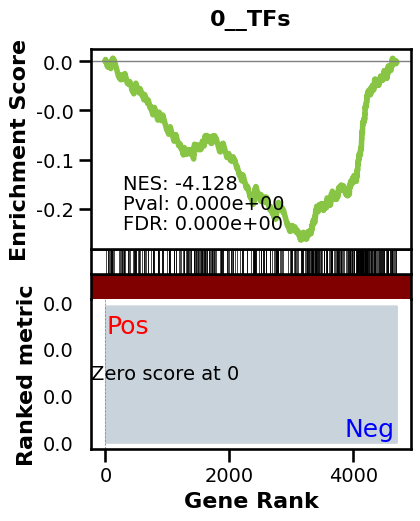

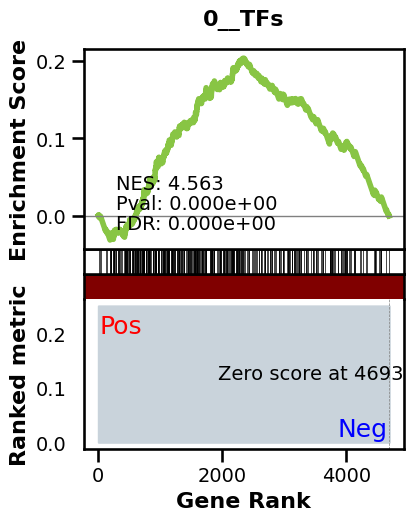

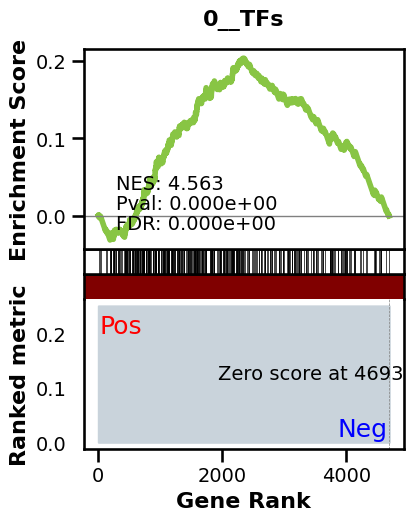

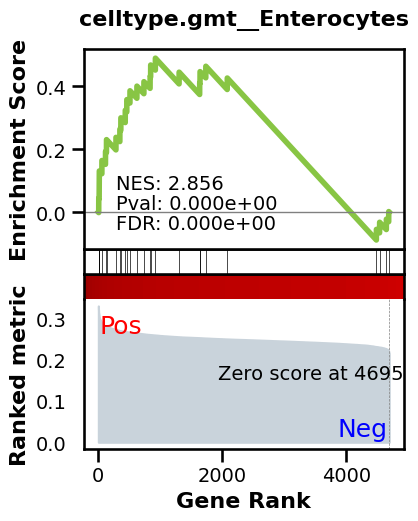

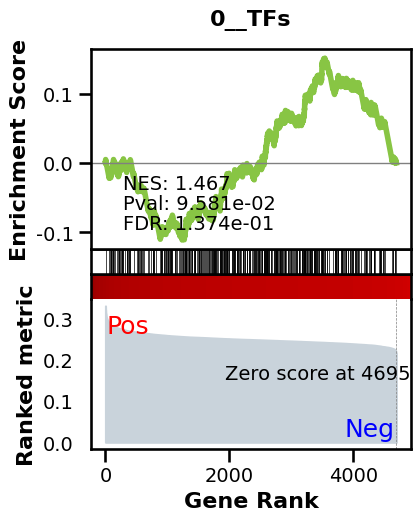

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3190 genes
intersection pct: 0.6793015332197615
precision:  0.0006976149998525958 
recall:  1.0 
random precision: 0.0006978337565160805



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 71.86it/s]


 12%|█▎        | 16/128 [00:00<00:01, 71.96it/s]


 19%|█▉        | 24/128 [00:00<00:01, 71.94it/s]


 25%|██▌       | 32/128 [00:00<00:01, 71.93it/s]


 31%|███▏      | 40/128 [00:00<00:01, 71.93it/s]


 38%|███▊      | 48/128 [00:00<00:01, 71.97it/s]


 44%|████▍     | 56/128 [00:00<00:01, 72.00it/s]


 50%|█████     | 64/128 [00:00<00:00, 72.01it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 71.96it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 71.95it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 71.91it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 71.93it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 71.96it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 71.90it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 71.92it/s]


100%|██████████| 128/128 [00:01<00:00, 71.96it/s]


100%|██████████| 128/128 [00:01<00:00, 71.92it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0007773020049428632
EPR: 3.0365011050741906


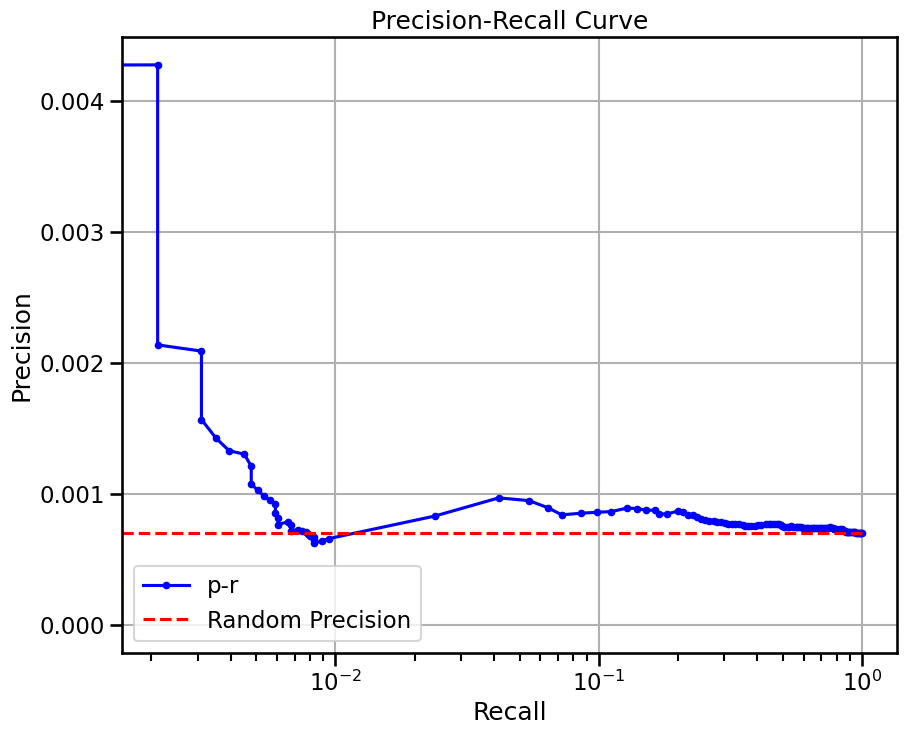

base enrichment


Top central genes: []


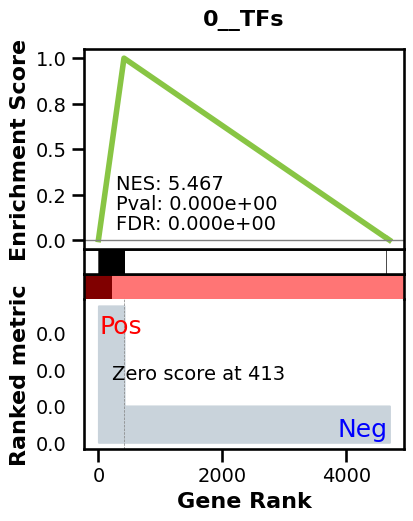

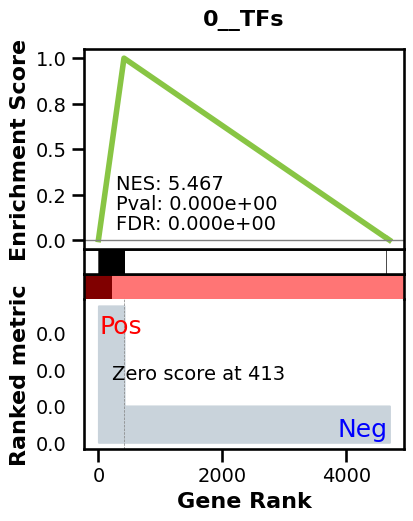

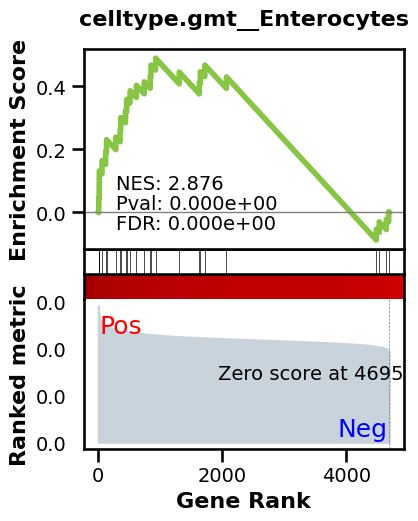

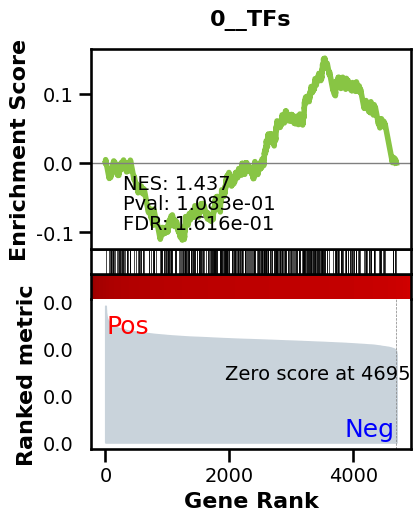

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3190 genes
intersection pct: 0.6793015332197615
precision:  0.0018386612893084586 
recall:  0.28835047189745033 
random precision: 0.0006978337565160805



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 72.20it/s]


 12%|█▎        | 16/128 [00:00<00:01, 71.72it/s]


 19%|█▉        | 24/128 [00:00<00:01, 71.64it/s]


 25%|██▌       | 32/128 [00:00<00:01, 71.83it/s]


 31%|███▏      | 40/128 [00:00<00:01, 71.90it/s]


 38%|███▊      | 48/128 [00:00<00:01, 72.02it/s]


 44%|████▍     | 56/128 [00:00<00:00, 72.00it/s]


 50%|█████     | 64/128 [00:00<00:00, 72.04it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 72.07it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 72.03it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 72.05it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 72.00it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 72.00it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 72.02it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 72.03it/s]


100%|██████████| 128/128 [00:01<00:00, 72.04it/s]


100%|██████████| 128/128 [00:01<00:00, 71.96it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0011410552177721326
EPR: 4.666505897689656


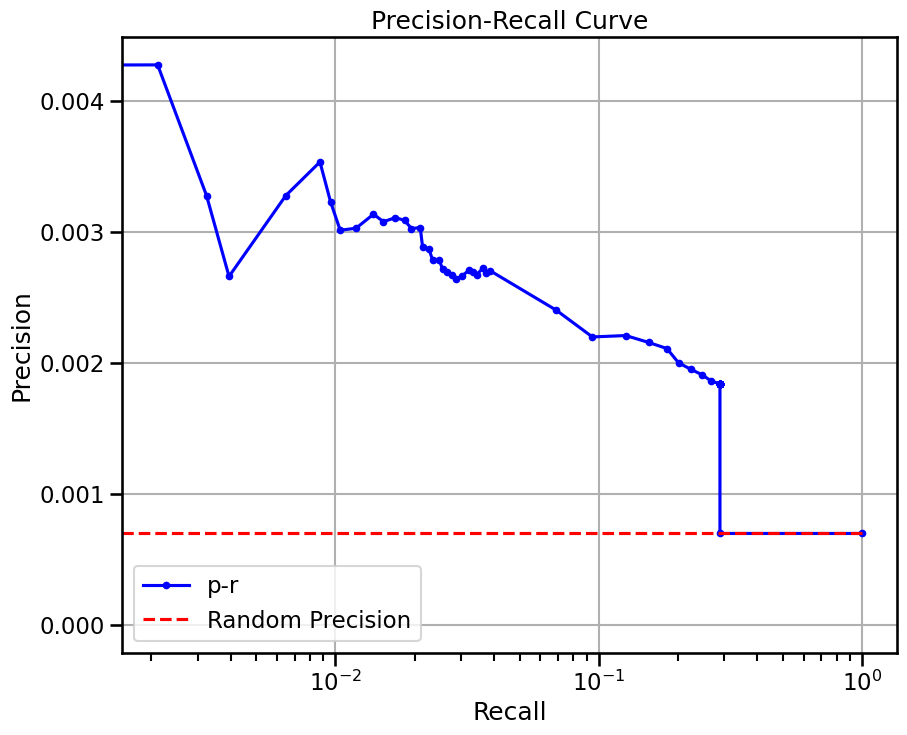


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:15,  2.71it/s]


  1%|          | 2/205 [00:00<01:14,  2.73it/s]


  1%|▏         | 3/205 [00:01<01:14,  2.70it/s]


  2%|▏         | 4/205 [00:01<01:13,  2.73it/s]


  2%|▏         | 5/205 [00:01<01:13,  2.72it/s]


  3%|▎         | 6/205 [00:02<01:14,  2.68it/s]


  3%|▎         | 7/205 [00:02<01:13,  2.69it/s]


  4%|▍         | 8/205 [00:02<01:12,  2.72it/s]


  4%|▍         | 9/205 [00:03<01:12,  2.71it/s]


  5%|▍         | 10/205 [00:03<01:12,  2.71it/s]


  5%|▌         | 11/205 [00:04<01:11,  2.71it/s]


  6%|▌         | 12/205 [00:04<01:11,  2.71it/s]


  6%|▋         | 13/205 [00:04<01:10,  2.73it/s]


  7%|▋         | 14/205 [00:05<01:10,  2.72it/s]


  7%|▋         | 15/205 [00:05<01:10,  2.71it/s]


  8%|▊         | 16/205 [00:05<01:09,  2.73it/s]


  8%|▊         | 17/205 [00:06<01:09,  2.72it/s]


  9%|▉         | 18/205 [00:06<01:08,  2.74it/s]


  9%|▉         | 19/205 [00:06<01:07,  2.75it/s]


 10%|▉         | 20/205 [00:07<01:07,  2.74it/s]


 10%|█         | 21/205 [00:07<01:07,  2.72it/s]


 11%|█         | 22/205 [00:08<01:07,  2.72it/s]


 11%|█         | 23/205 [00:08<01:06,  2.74it/s]


 12%|█▏        | 24/205 [00:08<01:06,  2.73it/s]


 12%|█▏        | 25/205 [00:09<01:06,  2.72it/s]


 13%|█▎        | 26/205 [00:09<01:06,  2.71it/s]


 13%|█▎        | 27/205 [00:09<01:05,  2.73it/s]


 14%|█▎        | 28/205 [00:10<01:05,  2.72it/s]


 14%|█▍        | 29/205 [00:10<01:04,  2.72it/s]


 15%|█▍        | 30/205 [00:11<01:04,  2.71it/s]


 15%|█▌        | 31/205 [00:11<01:04,  2.71it/s]


 16%|█▌        | 32/205 [00:11<01:03,  2.73it/s]


 16%|█▌        | 33/205 [00:12<01:03,  2.72it/s]


 17%|█▋        | 34/205 [00:12<01:03,  2.71it/s]


 17%|█▋        | 35/205 [00:12<01:02,  2.73it/s]


 18%|█▊        | 36/205 [00:13<01:02,  2.72it/s]


 18%|█▊        | 37/205 [00:13<01:01,  2.74it/s]


 19%|█▊        | 38/205 [00:13<01:00,  2.75it/s]


 19%|█▉        | 39/205 [00:14<01:00,  2.73it/s]


 20%|█▉        | 40/205 [00:14<01:00,  2.75it/s]


 20%|██        | 41/205 [00:15<00:59,  2.76it/s]


 20%|██        | 42/205 [00:15<00:58,  2.76it/s]


 21%|██        | 43/205 [00:15<00:59,  2.74it/s]


 21%|██▏       | 44/205 [00:16<00:58,  2.75it/s]


 22%|██▏       | 45/205 [00:16<00:58,  2.74it/s]


 22%|██▏       | 46/205 [00:16<00:57,  2.75it/s]


 23%|██▎       | 47/205 [00:17<00:57,  2.76it/s]


 23%|██▎       | 48/205 [00:17<00:57,  2.74it/s]


 24%|██▍       | 49/205 [00:17<00:57,  2.73it/s]


 24%|██▍       | 50/205 [00:18<00:56,  2.72it/s]


 25%|██▍       | 51/205 [00:18<00:56,  2.74it/s]


 25%|██▌       | 52/205 [00:19<00:56,  2.73it/s]


 26%|██▌       | 53/205 [00:19<00:55,  2.74it/s]


 26%|██▋       | 54/205 [00:19<00:55,  2.73it/s]


 27%|██▋       | 55/205 [00:20<00:55,  2.72it/s]


 27%|██▋       | 56/205 [00:20<00:54,  2.74it/s]


 28%|██▊       | 57/205 [00:20<00:54,  2.72it/s]


 28%|██▊       | 58/205 [00:21<00:54,  2.72it/s]


 29%|██▉       | 59/205 [00:21<00:53,  2.71it/s]


 29%|██▉       | 60/205 [00:22<00:53,  2.73it/s]


 30%|██▉       | 61/205 [00:22<00:52,  2.72it/s]


 30%|███       | 62/205 [00:22<00:52,  2.72it/s]


 31%|███       | 63/205 [00:23<00:51,  2.73it/s]


 31%|███       | 64/205 [00:23<00:51,  2.75it/s]


 32%|███▏      | 65/205 [00:23<00:51,  2.73it/s]


 32%|███▏      | 66/205 [00:24<00:50,  2.75it/s]


 33%|███▎      | 67/205 [00:24<00:50,  2.73it/s]


 33%|███▎      | 68/205 [00:24<00:50,  2.72it/s]


 34%|███▎      | 69/205 [00:25<00:49,  2.74it/s]


 34%|███▍      | 70/205 [00:25<00:49,  2.73it/s]


 35%|███▍      | 71/205 [00:26<00:49,  2.72it/s]


 35%|███▌      | 72/205 [00:26<00:49,  2.71it/s]


 36%|███▌      | 73/205 [00:26<00:48,  2.71it/s]


 36%|███▌      | 74/205 [00:27<00:47,  2.73it/s]


 37%|███▋      | 75/205 [00:27<00:47,  2.74it/s]


 37%|███▋      | 76/205 [00:27<00:47,  2.73it/s]


 38%|███▊      | 77/205 [00:28<00:46,  2.75it/s]


 38%|███▊      | 78/205 [00:28<00:46,  2.73it/s]


 39%|███▊      | 79/205 [00:28<00:46,  2.72it/s]


 39%|███▉      | 80/205 [00:29<00:46,  2.71it/s]


 40%|███▉      | 81/205 [00:29<00:45,  2.71it/s]


 40%|████      | 82/205 [00:30<00:45,  2.70it/s]


 40%|████      | 83/205 [00:30<00:45,  2.70it/s]


 41%|████      | 84/205 [00:30<00:44,  2.73it/s]


 41%|████▏     | 85/205 [00:31<00:44,  2.72it/s]


 42%|████▏     | 86/205 [00:31<00:43,  2.71it/s]


 42%|████▏     | 87/205 [00:31<00:43,  2.73it/s]


 43%|████▎     | 88/205 [00:32<00:42,  2.72it/s]


 43%|████▎     | 89/205 [00:32<00:42,  2.74it/s]


 44%|████▍     | 90/205 [00:33<00:42,  2.72it/s]


 44%|████▍     | 91/205 [00:33<00:41,  2.74it/s]


 45%|████▍     | 92/205 [00:33<00:41,  2.75it/s]


 45%|████▌     | 93/205 [00:34<00:40,  2.73it/s]


 46%|████▌     | 94/205 [00:34<00:40,  2.75it/s]


 46%|████▋     | 95/205 [00:34<00:39,  2.76it/s]


 47%|████▋     | 96/205 [00:35<00:39,  2.74it/s]


 47%|████▋     | 97/205 [00:35<00:39,  2.75it/s]


 48%|████▊     | 98/205 [00:35<00:39,  2.74it/s]


 48%|████▊     | 99/205 [00:36<00:38,  2.72it/s]


 49%|████▉     | 100/205 [00:36<00:38,  2.74it/s]


 49%|████▉     | 101/205 [00:37<00:38,  2.73it/s]


 50%|████▉     | 102/205 [00:37<00:37,  2.72it/s]


 50%|█████     | 103/205 [00:37<00:37,  2.71it/s]


 51%|█████     | 104/205 [00:38<00:37,  2.71it/s]


 51%|█████     | 105/205 [00:38<00:36,  2.73it/s]


 52%|█████▏    | 106/205 [00:38<00:36,  2.72it/s]


 52%|█████▏    | 107/205 [00:39<00:35,  2.74it/s]


 53%|█████▎    | 108/205 [00:39<00:35,  2.73it/s]


 53%|█████▎    | 109/205 [00:39<00:35,  2.72it/s]


 54%|█████▎    | 110/205 [00:40<00:35,  2.71it/s]


 54%|█████▍    | 111/205 [00:40<00:34,  2.73it/s]


 55%|█████▍    | 112/205 [00:41<00:34,  2.72it/s]


 55%|█████▌    | 113/205 [00:41<00:33,  2.71it/s]


 56%|█████▌    | 114/205 [00:41<00:33,  2.71it/s]


 56%|█████▌    | 115/205 [00:42<00:33,  2.71it/s]


 57%|█████▋    | 116/205 [00:42<00:32,  2.71it/s]


 57%|█████▋    | 117/205 [00:42<00:32,  2.73it/s]


 58%|█████▊    | 118/205 [00:43<00:31,  2.74it/s]


 58%|█████▊    | 119/205 [00:43<00:31,  2.73it/s]


 59%|█████▊    | 120/205 [00:44<00:31,  2.72it/s]


 59%|█████▉    | 121/205 [00:44<00:30,  2.74it/s]


 60%|█████▉    | 122/205 [00:44<00:30,  2.73it/s]


 60%|██████    | 123/205 [00:45<00:30,  2.72it/s]


 60%|██████    | 124/205 [00:45<00:29,  2.74it/s]


 61%|██████    | 125/205 [00:45<00:29,  2.72it/s]


 61%|██████▏   | 126/205 [00:46<00:28,  2.74it/s]


 62%|██████▏   | 127/205 [00:46<00:28,  2.75it/s]


 62%|██████▏   | 128/205 [00:46<00:27,  2.76it/s]


 63%|██████▎   | 129/205 [00:47<00:27,  2.74it/s]


 63%|██████▎   | 130/205 [00:47<00:27,  2.75it/s]


 64%|██████▍   | 131/205 [00:48<00:27,  2.74it/s]


 64%|██████▍   | 132/205 [00:48<00:26,  2.72it/s]


 65%|██████▍   | 133/205 [00:48<00:26,  2.72it/s]


 65%|██████▌   | 134/205 [00:49<00:26,  2.71it/s]


 66%|██████▌   | 135/205 [00:49<00:25,  2.71it/s]


 66%|██████▋   | 136/205 [00:49<00:25,  2.73it/s]


 67%|██████▋   | 137/205 [00:50<00:25,  2.72it/s]


 67%|██████▋   | 138/205 [00:50<00:24,  2.72it/s]


 68%|██████▊   | 139/205 [00:50<00:24,  2.71it/s]


 68%|██████▊   | 140/205 [00:51<00:23,  2.73it/s]


 69%|██████▉   | 141/205 [00:51<00:23,  2.72it/s]


 69%|██████▉   | 142/205 [00:52<00:23,  2.74it/s]


 70%|██████▉   | 143/205 [00:52<00:22,  2.75it/s]


 70%|███████   | 144/205 [00:52<00:22,  2.73it/s]


 71%|███████   | 145/205 [00:53<00:22,  2.72it/s]


 71%|███████   | 146/205 [00:53<00:21,  2.72it/s]


 72%|███████▏  | 147/205 [00:53<00:21,  2.71it/s]


 72%|███████▏  | 148/205 [00:54<00:20,  2.73it/s]


 73%|███████▎  | 149/205 [00:54<00:20,  2.72it/s]


 73%|███████▎  | 150/205 [00:54<00:20,  2.74it/s]


 74%|███████▎  | 151/205 [00:55<00:19,  2.73it/s]


 74%|███████▍  | 152/205 [00:55<00:19,  2.75it/s]


 75%|███████▍  | 153/205 [00:56<00:19,  2.73it/s]


 75%|███████▌  | 154/205 [00:56<00:18,  2.74it/s]


 76%|███████▌  | 155/205 [00:56<00:18,  2.73it/s]


 76%|███████▌  | 156/205 [00:57<00:17,  2.75it/s]


 77%|███████▋  | 157/205 [00:57<00:17,  2.73it/s]


 77%|███████▋  | 158/205 [00:57<00:17,  2.72it/s]


 78%|███████▊  | 159/205 [00:58<00:16,  2.74it/s]


 78%|███████▊  | 160/205 [00:58<00:16,  2.73it/s]


 79%|███████▊  | 161/205 [00:59<00:16,  2.72it/s]


 79%|███████▉  | 162/205 [00:59<00:15,  2.74it/s]


 80%|███████▉  | 163/205 [00:59<00:15,  2.72it/s]


 80%|████████  | 164/205 [01:00<00:15,  2.72it/s]


 80%|████████  | 165/205 [01:00<00:14,  2.71it/s]


 81%|████████  | 166/205 [01:00<00:14,  2.71it/s]


 81%|████████▏ | 167/205 [01:01<00:14,  2.71it/s]


 82%|████████▏ | 168/205 [01:01<00:13,  2.73it/s]


 82%|████████▏ | 169/205 [01:01<00:13,  2.74it/s]


 83%|████████▎ | 170/205 [01:02<00:12,  2.73it/s]


 83%|████████▎ | 171/205 [01:02<00:12,  2.72it/s]


 84%|████████▍ | 172/205 [01:03<00:12,  2.72it/s]


 84%|████████▍ | 173/205 [01:03<00:11,  2.71it/s]


 85%|████████▍ | 174/205 [01:03<00:11,  2.73it/s]


 85%|████████▌ | 175/205 [01:04<00:10,  2.74it/s]


 86%|████████▌ | 176/205 [01:04<00:10,  2.75it/s]


 86%|████████▋ | 177/205 [01:04<00:10,  2.74it/s]


 87%|████████▋ | 178/205 [01:05<00:09,  2.72it/s]


 87%|████████▋ | 179/205 [01:05<00:09,  2.74it/s]


 88%|████████▊ | 180/205 [01:05<00:09,  2.73it/s]


 88%|████████▊ | 181/205 [01:06<00:08,  2.72it/s]


 89%|████████▉ | 182/205 [01:06<00:08,  2.71it/s]


 89%|████████▉ | 183/205 [01:07<00:08,  2.71it/s]


 90%|████████▉ | 184/205 [01:07<00:07,  2.71it/s]


 90%|█████████ | 185/205 [01:07<00:07,  2.70it/s]


 91%|█████████ | 186/205 [01:08<00:07,  2.71it/s]


 91%|█████████ | 187/205 [01:08<00:06,  2.71it/s]


 92%|█████████▏| 188/205 [01:08<00:06,  2.70it/s]


 92%|█████████▏| 189/205 [01:09<00:05,  2.72it/s]


 93%|█████████▎| 190/205 [01:09<00:05,  2.72it/s]


 93%|█████████▎| 191/205 [01:10<00:05,  2.71it/s]


 94%|█████████▎| 192/205 [01:10<00:04,  2.71it/s]


 94%|█████████▍| 193/205 [01:10<00:04,  2.70it/s]


 95%|█████████▍| 194/205 [01:11<00:04,  2.70it/s]


 95%|█████████▌| 195/205 [01:11<00:03,  2.70it/s]


 96%|█████████▌| 196/205 [01:11<00:03,  2.70it/s]


 96%|█████████▌| 197/205 [01:12<00:02,  2.72it/s]


 97%|█████████▋| 198/205 [01:12<00:02,  2.72it/s]


 97%|█████████▋| 199/205 [01:13<00:02,  2.73it/s]


 98%|█████████▊| 200/205 [01:13<00:01,  2.75it/s]


 98%|█████████▊| 201/205 [01:13<00:01,  2.73it/s]


 99%|█████████▊| 202/205 [01:14<00:01,  2.75it/s]


 99%|█████████▉| 203/205 [01:14<00:00,  2.75it/s]


100%|█████████▉| 204/205 [01:14<00:00,  2.76it/s]


100%|██████████| 205/205 [01:15<00:00,  2.90it/s]


100%|██████████| 205/205 [01:15<00:00,  2.73it/s]

base enrichment


Top central genes: []


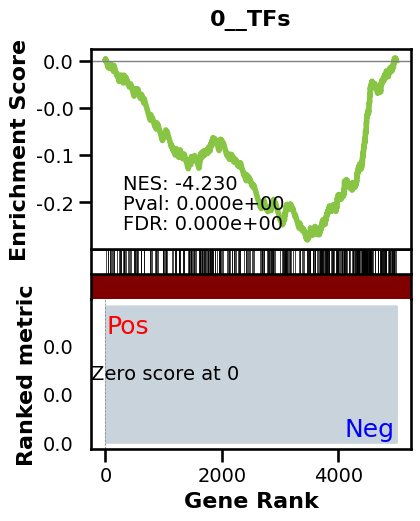

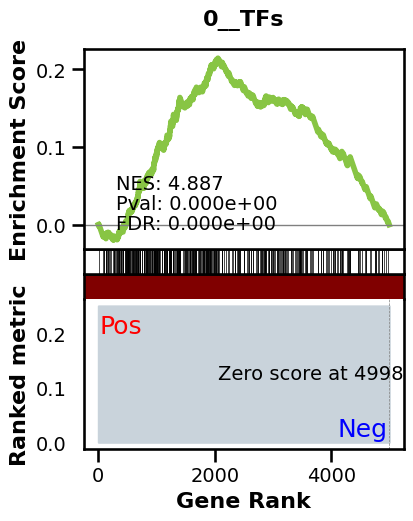

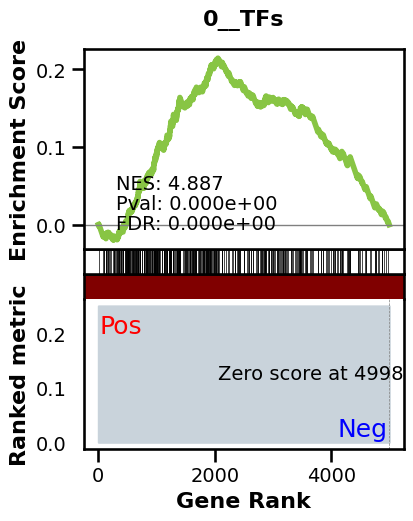

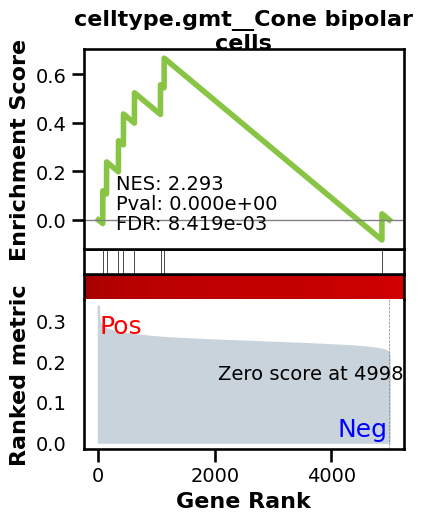

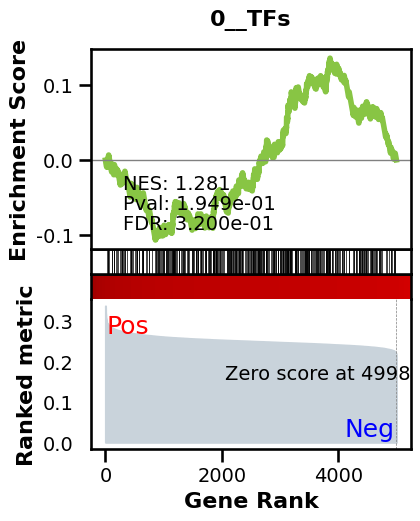

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3520 genes
intersection pct: 0.7041408281656332
precision:  0.0006723753873966942 
recall:  1.0 
random precision: 0.0006725664574130047



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 58.41it/s]


  9%|▉         | 12/128 [00:00<00:01, 58.31it/s]


 14%|█▍        | 18/128 [00:00<00:01, 58.17it/s]


 19%|█▉        | 24/128 [00:00<00:01, 58.41it/s]


 23%|██▎       | 30/128 [00:00<00:01, 58.31it/s]


 28%|██▊       | 36/128 [00:00<00:01, 58.27it/s]


 33%|███▎      | 42/128 [00:00<00:01, 58.24it/s]


 38%|███▊      | 48/128 [00:00<00:01, 58.22it/s]


 42%|████▏     | 54/128 [00:00<00:01, 58.21it/s]


 47%|████▋     | 60/128 [00:01<00:01, 58.25it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 58.23it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 58.26it/s]


 61%|██████    | 78/128 [00:01<00:00, 58.25it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 58.24it/s]


 70%|███████   | 90/128 [00:01<00:00, 58.23it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 58.25it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 58.24it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 58.22it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 58.24it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 58.25it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 58.23it/s]


100%|██████████| 128/128 [00:02<00:00, 58.22it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0007664898307962315


EPR: 3.401892236811512


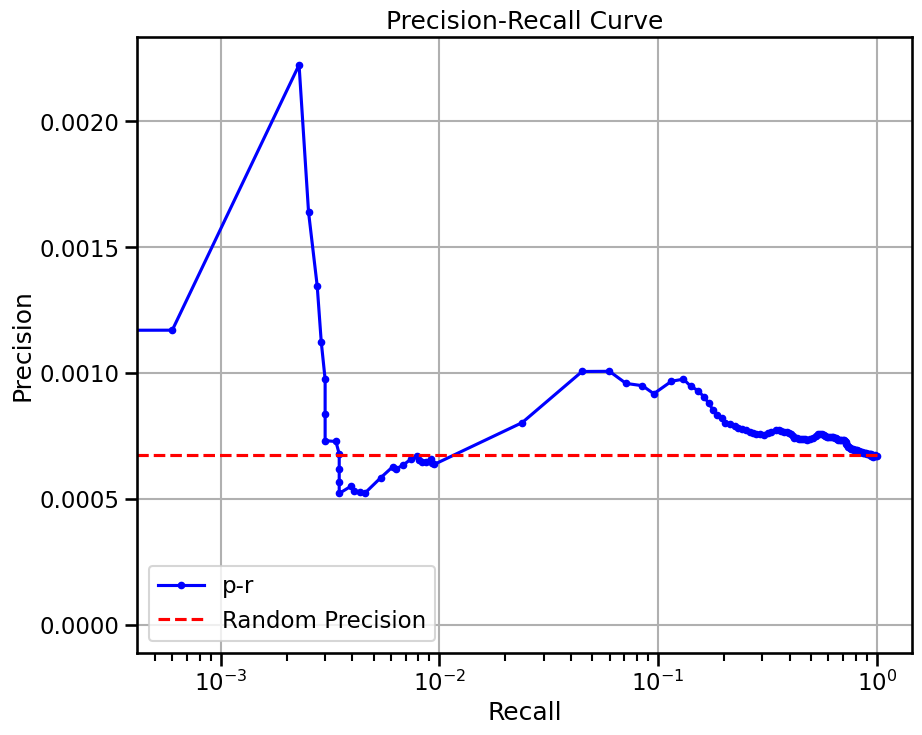

base enrichment


Top central genes: []


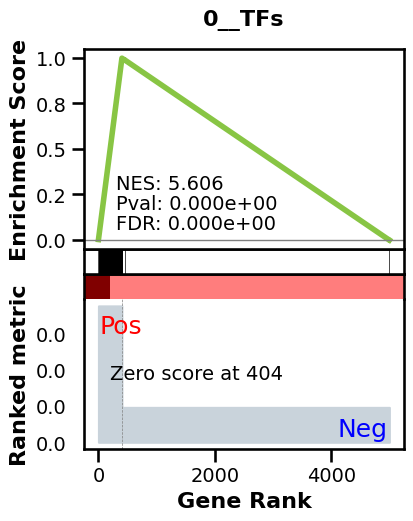

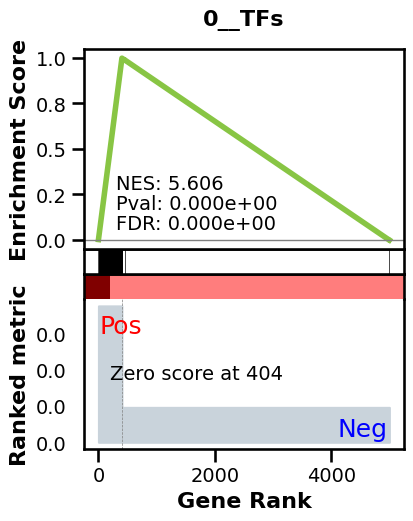

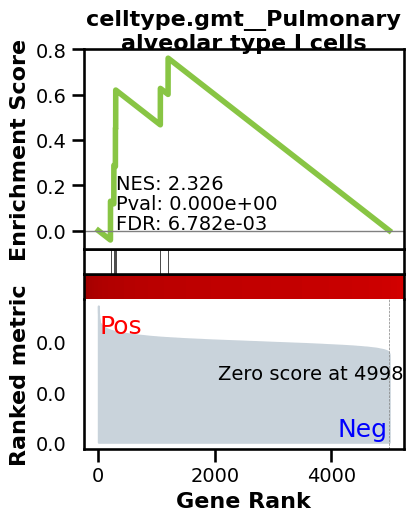

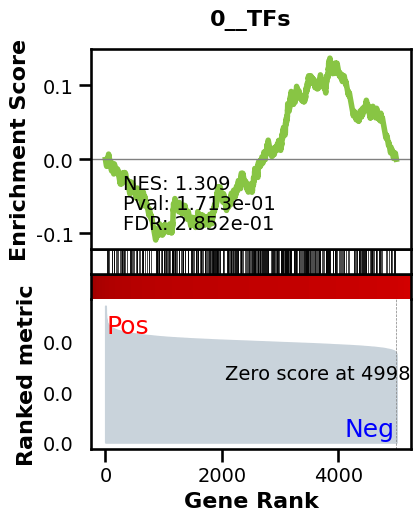

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3520 genes
intersection pct: 0.7041408281656332
precision:  0.0016901718073593073 
recall:  0.23994718521185932 
random precision: 0.0006725664574130047



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 58.32it/s]


  9%|▉         | 12/128 [00:00<00:01, 58.10it/s]


 14%|█▍        | 18/128 [00:00<00:01, 58.04it/s]


 19%|█▉        | 24/128 [00:00<00:01, 57.95it/s]


 23%|██▎       | 30/128 [00:00<00:01, 57.94it/s]


 28%|██▊       | 36/128 [00:00<00:01, 57.92it/s]


 33%|███▎      | 42/128 [00:00<00:01, 57.91it/s]


 38%|███▊      | 48/128 [00:00<00:01, 57.90it/s]


 42%|████▏     | 54/128 [00:00<00:01, 57.90it/s]


 47%|████▋     | 60/128 [00:01<00:01, 57.92it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 57.92it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 57.89it/s]


 61%|██████    | 78/128 [00:01<00:00, 57.89it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 57.89it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.91it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 57.89it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 57.90it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 57.92it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 57.92it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 57.88it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 57.85it/s]


100%|██████████| 128/128 [00:02<00:00, 57.88it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0010001551476084315
EPR: 3.401892236811512


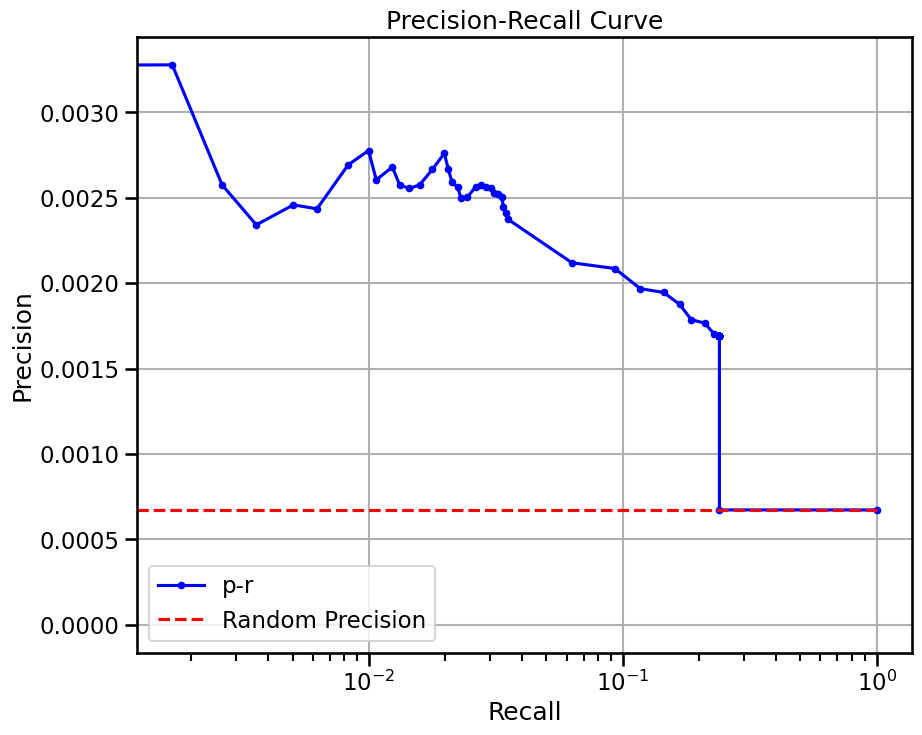


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:16,  1.49it/s]


  1%|          | 2/205 [00:01<02:16,  1.48it/s]


  1%|▏         | 3/205 [00:02<02:15,  1.49it/s]


  2%|▏         | 4/205 [00:02<02:14,  1.50it/s]


  2%|▏         | 5/205 [00:03<02:13,  1.50it/s]


  3%|▎         | 6/205 [00:04<02:12,  1.50it/s]


  3%|▎         | 7/205 [00:04<02:11,  1.50it/s]


  4%|▍         | 8/205 [00:05<02:11,  1.50it/s]


  4%|▍         | 9/205 [00:05<02:10,  1.51it/s]


  5%|▍         | 10/205 [00:06<02:09,  1.51it/s]


  5%|▌         | 11/205 [00:07<02:08,  1.51it/s]


  6%|▌         | 12/205 [00:07<02:07,  1.51it/s]


  6%|▋         | 13/205 [00:08<02:07,  1.51it/s]


  7%|▋         | 14/205 [00:09<02:06,  1.51it/s]


  7%|▋         | 15/205 [00:09<02:05,  1.51it/s]


  8%|▊         | 16/205 [00:10<02:05,  1.51it/s]


  8%|▊         | 17/205 [00:11<02:04,  1.51it/s]


  9%|▉         | 18/205 [00:11<02:03,  1.51it/s]


  9%|▉         | 19/205 [00:12<02:03,  1.51it/s]


 10%|▉         | 20/205 [00:13<02:02,  1.51it/s]


 10%|█         | 21/205 [00:13<02:01,  1.51it/s]


 11%|█         | 22/205 [00:14<02:01,  1.51it/s]


 11%|█         | 23/205 [00:15<02:00,  1.51it/s]


 12%|█▏        | 24/205 [00:15<02:00,  1.51it/s]


 12%|█▏        | 25/205 [00:16<01:59,  1.51it/s]


 13%|█▎        | 26/205 [00:17<01:58,  1.51it/s]


 13%|█▎        | 27/205 [00:17<01:58,  1.51it/s]


 14%|█▎        | 28/205 [00:18<01:57,  1.50it/s]


 14%|█▍        | 29/205 [00:19<01:57,  1.50it/s]


 15%|█▍        | 30/205 [00:19<01:56,  1.50it/s]


 15%|█▌        | 31/205 [00:20<01:55,  1.50it/s]


 16%|█▌        | 32/205 [00:21<01:55,  1.50it/s]


 16%|█▌        | 33/205 [00:21<01:54,  1.50it/s]


 17%|█▋        | 34/205 [00:22<01:53,  1.50it/s]


 17%|█▋        | 35/205 [00:23<01:53,  1.50it/s]


 18%|█▊        | 36/205 [00:23<01:52,  1.50it/s]


 18%|█▊        | 37/205 [00:24<01:51,  1.50it/s]


 19%|█▊        | 38/205 [00:25<01:51,  1.50it/s]


 19%|█▉        | 39/205 [00:25<01:50,  1.50it/s]


 20%|█▉        | 40/205 [00:26<01:49,  1.50it/s]


 20%|██        | 41/205 [00:27<01:49,  1.50it/s]


 20%|██        | 42/205 [00:27<01:48,  1.50it/s]


 21%|██        | 43/205 [00:28<01:47,  1.50it/s]


 21%|██▏       | 44/205 [00:29<01:47,  1.50it/s]


 22%|██▏       | 45/205 [00:29<01:46,  1.50it/s]


 22%|██▏       | 46/205 [00:30<01:45,  1.50it/s]


 23%|██▎       | 47/205 [00:31<01:45,  1.50it/s]


 23%|██▎       | 48/205 [00:31<01:44,  1.50it/s]


 24%|██▍       | 49/205 [00:32<01:44,  1.50it/s]


 24%|██▍       | 50/205 [00:33<01:43,  1.50it/s]


 25%|██▍       | 51/205 [00:33<01:42,  1.50it/s]


 25%|██▌       | 52/205 [00:34<01:43,  1.48it/s]


 26%|██▌       | 53/205 [00:35<01:42,  1.49it/s]


 26%|██▋       | 54/205 [00:35<01:41,  1.49it/s]


 27%|██▋       | 55/205 [00:36<01:40,  1.50it/s]


 27%|██▋       | 56/205 [00:37<01:39,  1.50it/s]


 28%|██▊       | 57/205 [00:37<01:38,  1.50it/s]


 28%|██▊       | 58/205 [00:38<01:38,  1.50it/s]


 29%|██▉       | 59/205 [00:39<01:37,  1.50it/s]


 29%|██▉       | 60/205 [00:39<01:36,  1.50it/s]


 30%|██▉       | 61/205 [00:40<01:36,  1.50it/s]


 30%|███       | 62/205 [00:41<01:35,  1.50it/s]


 31%|███       | 63/205 [00:41<01:34,  1.50it/s]


 31%|███       | 64/205 [00:42<01:34,  1.50it/s]


 32%|███▏      | 65/205 [00:43<01:33,  1.50it/s]


 32%|███▏      | 66/205 [00:43<01:32,  1.50it/s]


 33%|███▎      | 67/205 [00:44<01:32,  1.50it/s]


 33%|███▎      | 68/205 [00:45<01:31,  1.50it/s]


 34%|███▎      | 69/205 [00:45<01:30,  1.50it/s]


 34%|███▍      | 70/205 [00:46<01:30,  1.50it/s]


 35%|███▍      | 71/205 [00:47<01:29,  1.50it/s]


 35%|███▌      | 72/205 [00:47<01:28,  1.50it/s]


 36%|███▌      | 73/205 [00:48<01:28,  1.50it/s]


 36%|███▌      | 74/205 [00:49<01:27,  1.50it/s]


 37%|███▋      | 75/205 [00:49<01:26,  1.50it/s]


 37%|███▋      | 76/205 [00:50<01:26,  1.50it/s]


 38%|███▊      | 77/205 [00:51<01:25,  1.50it/s]


 38%|███▊      | 78/205 [00:51<01:24,  1.50it/s]


 39%|███▊      | 79/205 [00:52<01:24,  1.50it/s]


 39%|███▉      | 80/205 [00:53<01:23,  1.50it/s]


 40%|███▉      | 81/205 [00:53<01:22,  1.49it/s]


 40%|████      | 82/205 [00:54<01:22,  1.49it/s]


 40%|████      | 83/205 [00:55<01:21,  1.50it/s]


 41%|████      | 84/205 [00:55<01:20,  1.49it/s]


 41%|████▏     | 85/205 [00:56<01:20,  1.50it/s]


 42%|████▏     | 86/205 [00:57<01:19,  1.49it/s]


 42%|████▏     | 87/205 [00:57<01:18,  1.50it/s]


 43%|████▎     | 88/205 [00:58<01:18,  1.50it/s]


 43%|████▎     | 89/205 [00:59<01:17,  1.50it/s]


 44%|████▍     | 90/205 [00:59<01:16,  1.49it/s]


 44%|████▍     | 91/205 [01:00<01:16,  1.49it/s]


 45%|████▍     | 92/205 [01:01<01:15,  1.49it/s]


 45%|████▌     | 93/205 [01:01<01:15,  1.49it/s]


 46%|████▌     | 94/205 [01:02<01:14,  1.49it/s]


 46%|████▋     | 95/205 [01:03<01:13,  1.49it/s]


 47%|████▋     | 96/205 [01:03<01:13,  1.49it/s]


 47%|████▋     | 97/205 [01:04<01:12,  1.49it/s]


 48%|████▊     | 98/205 [01:05<01:11,  1.49it/s]


 48%|████▊     | 99/205 [01:06<01:11,  1.49it/s]


 49%|████▉     | 100/205 [01:06<01:10,  1.49it/s]


 49%|████▉     | 101/205 [01:07<01:09,  1.49it/s]


 50%|████▉     | 102/205 [01:08<01:09,  1.49it/s]


 50%|█████     | 103/205 [01:08<01:08,  1.49it/s]


 51%|█████     | 104/205 [01:09<01:07,  1.49it/s]


 51%|█████     | 105/205 [01:10<01:07,  1.49it/s]


 52%|█████▏    | 106/205 [01:10<01:06,  1.49it/s]


 52%|█████▏    | 107/205 [01:11<01:05,  1.49it/s]


 53%|█████▎    | 108/205 [01:12<01:05,  1.49it/s]


 53%|█████▎    | 109/205 [01:12<01:04,  1.49it/s]


 54%|█████▎    | 110/205 [01:13<01:03,  1.49it/s]


 54%|█████▍    | 111/205 [01:14<01:03,  1.49it/s]


 55%|█████▍    | 112/205 [01:14<01:02,  1.49it/s]


 55%|█████▌    | 113/205 [01:15<01:01,  1.49it/s]


 56%|█████▌    | 114/205 [01:16<01:01,  1.49it/s]


 56%|█████▌    | 115/205 [01:16<01:00,  1.49it/s]


 57%|█████▋    | 116/205 [01:17<00:59,  1.49it/s]


 57%|█████▋    | 117/205 [01:18<00:59,  1.49it/s]


 58%|█████▊    | 118/205 [01:18<00:58,  1.49it/s]


 58%|█████▊    | 119/205 [01:19<00:57,  1.49it/s]


 59%|█████▊    | 120/205 [01:20<00:57,  1.49it/s]


 59%|█████▉    | 121/205 [01:20<00:56,  1.49it/s]


 60%|█████▉    | 122/205 [01:21<00:55,  1.49it/s]


 60%|██████    | 123/205 [01:22<00:55,  1.49it/s]


 60%|██████    | 124/205 [01:22<00:54,  1.49it/s]


 61%|██████    | 125/205 [01:23<00:53,  1.49it/s]


 61%|██████▏   | 126/205 [01:24<00:53,  1.49it/s]


 62%|██████▏   | 127/205 [01:24<00:52,  1.49it/s]


 62%|██████▏   | 128/205 [01:25<00:52,  1.48it/s]


 63%|██████▎   | 129/205 [01:26<00:51,  1.48it/s]


 63%|██████▎   | 130/205 [01:26<00:50,  1.48it/s]


 64%|██████▍   | 131/205 [01:27<00:49,  1.48it/s]


 64%|██████▍   | 132/205 [01:28<00:49,  1.49it/s]


 65%|██████▍   | 133/205 [01:28<00:48,  1.48it/s]


 65%|██████▌   | 134/205 [01:29<00:47,  1.48it/s]


 66%|██████▌   | 135/205 [01:30<00:47,  1.48it/s]


 66%|██████▋   | 136/205 [01:30<00:46,  1.48it/s]


 67%|██████▋   | 137/205 [01:31<00:45,  1.48it/s]


 67%|██████▋   | 138/205 [01:32<00:45,  1.48it/s]


 68%|██████▊   | 139/205 [01:32<00:44,  1.49it/s]


 68%|██████▊   | 140/205 [01:33<00:43,  1.49it/s]


 69%|██████▉   | 141/205 [01:34<00:43,  1.49it/s]


 69%|██████▉   | 142/205 [01:34<00:42,  1.49it/s]


 70%|██████▉   | 143/205 [01:35<00:41,  1.49it/s]


 70%|███████   | 144/205 [01:36<00:41,  1.48it/s]


 71%|███████   | 145/205 [01:36<00:40,  1.49it/s]


 71%|███████   | 146/205 [01:37<00:39,  1.49it/s]


 72%|███████▏  | 147/205 [01:38<00:39,  1.48it/s]


 72%|███████▏  | 148/205 [01:38<00:38,  1.48it/s]


 73%|███████▎  | 149/205 [01:39<00:37,  1.49it/s]


 73%|███████▎  | 150/205 [01:40<00:37,  1.49it/s]


 74%|███████▎  | 151/205 [01:40<00:36,  1.48it/s]


 74%|███████▍  | 152/205 [01:41<00:35,  1.49it/s]


 75%|███████▍  | 153/205 [01:42<00:35,  1.49it/s]


 75%|███████▌  | 154/205 [01:43<00:34,  1.48it/s]


 76%|███████▌  | 155/205 [01:43<00:33,  1.49it/s]


 76%|███████▌  | 156/205 [01:44<00:32,  1.49it/s]


 77%|███████▋  | 157/205 [01:45<00:32,  1.49it/s]


 77%|███████▋  | 158/205 [01:45<00:31,  1.49it/s]


 78%|███████▊  | 159/205 [01:46<00:30,  1.49it/s]


 78%|███████▊  | 160/205 [01:47<00:30,  1.49it/s]


 79%|███████▊  | 161/205 [01:47<00:29,  1.49it/s]


 79%|███████▉  | 162/205 [01:48<00:28,  1.48it/s]


 80%|███████▉  | 163/205 [01:49<00:28,  1.48it/s]


 80%|████████  | 164/205 [01:49<00:27,  1.48it/s]


 80%|████████  | 165/205 [01:50<00:26,  1.48it/s]


 81%|████████  | 166/205 [01:51<00:26,  1.48it/s]


 81%|████████▏ | 167/205 [01:51<00:25,  1.48it/s]


 82%|████████▏ | 168/205 [01:52<00:24,  1.48it/s]


 82%|████████▏ | 169/205 [01:53<00:24,  1.48it/s]


 83%|████████▎ | 170/205 [01:53<00:23,  1.48it/s]


 83%|████████▎ | 171/205 [01:54<00:22,  1.48it/s]


 84%|████████▍ | 172/205 [01:55<00:22,  1.48it/s]


 84%|████████▍ | 173/205 [01:55<00:21,  1.48it/s]


 85%|████████▍ | 174/205 [01:56<00:20,  1.48it/s]


 85%|████████▌ | 175/205 [01:57<00:20,  1.48it/s]


 86%|████████▌ | 176/205 [01:57<00:19,  1.48it/s]


 86%|████████▋ | 177/205 [01:58<00:18,  1.48it/s]


 87%|████████▋ | 178/205 [01:59<00:18,  1.48it/s]


 87%|████████▋ | 179/205 [01:59<00:17,  1.48it/s]


 88%|████████▊ | 180/205 [02:00<00:16,  1.48it/s]


 88%|████████▊ | 181/205 [02:01<00:16,  1.48it/s]


 89%|████████▉ | 182/205 [02:01<00:15,  1.48it/s]


 89%|████████▉ | 183/205 [02:02<00:14,  1.48it/s]


 90%|████████▉ | 184/205 [02:03<00:14,  1.48it/s]


 90%|█████████ | 185/205 [02:03<00:13,  1.48it/s]


 91%|█████████ | 186/205 [02:04<00:12,  1.48it/s]


 91%|█████████ | 187/205 [02:05<00:12,  1.48it/s]


 92%|█████████▏| 188/205 [02:05<00:11,  1.48it/s]


 92%|█████████▏| 189/205 [02:06<00:10,  1.48it/s]


 93%|█████████▎| 190/205 [02:07<00:10,  1.48it/s]


 93%|█████████▎| 191/205 [02:07<00:09,  1.47it/s]


 94%|█████████▎| 192/205 [02:08<00:08,  1.48it/s]


 94%|█████████▍| 193/205 [02:09<00:08,  1.48it/s]


 95%|█████████▍| 194/205 [02:10<00:07,  1.48it/s]


 95%|█████████▌| 195/205 [02:10<00:06,  1.47it/s]


 96%|█████████▌| 196/205 [02:11<00:06,  1.47it/s]


 96%|█████████▌| 197/205 [02:12<00:05,  1.47it/s]


 97%|█████████▋| 198/205 [02:12<00:04,  1.48it/s]


 97%|█████████▋| 199/205 [02:13<00:04,  1.48it/s]


 98%|█████████▊| 200/205 [02:14<00:03,  1.48it/s]


 98%|█████████▊| 201/205 [02:14<00:02,  1.48it/s]


 99%|█████████▊| 202/205 [02:15<00:02,  1.48it/s]


 99%|█████████▉| 203/205 [02:16<00:01,  1.48it/s]


100%|█████████▉| 204/205 [02:16<00:00,  1.48it/s]


100%|██████████| 205/205 [02:17<00:00,  1.58it/s]


100%|██████████| 205/205 [02:17<00:00,  1.49it/s]

base enrichment


Top central genes: []


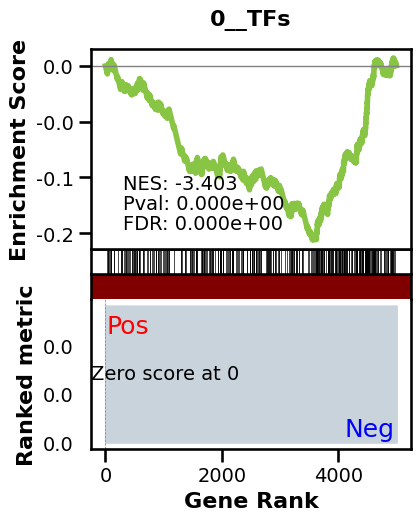

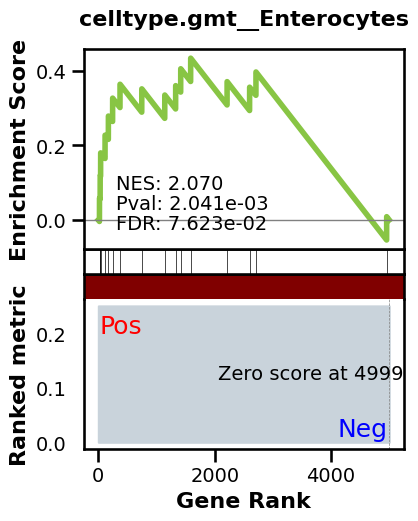

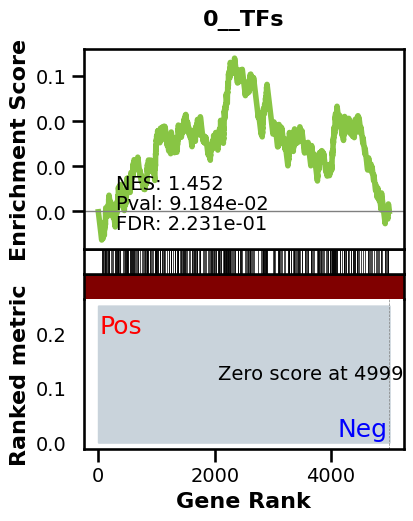

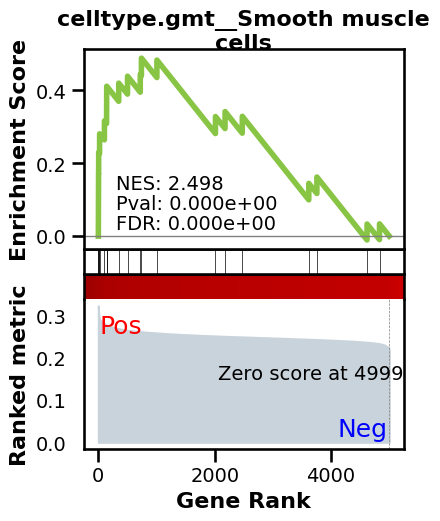

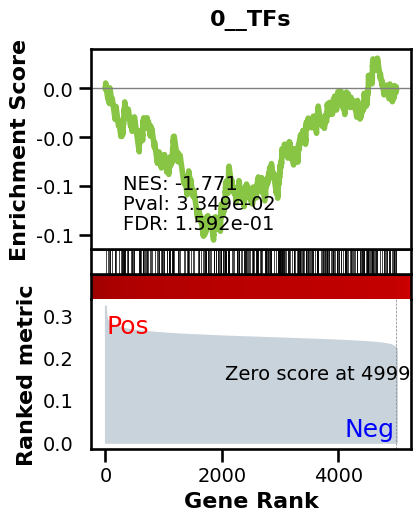

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0007680287225167932 
recall:  1.0 
random precision: 0.0007682468505265962



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 58.00it/s]


  9%|▉         | 12/128 [00:00<00:02, 57.94it/s]


 14%|█▍        | 18/128 [00:00<00:01, 57.87it/s]


 19%|█▉        | 24/128 [00:00<00:01, 57.85it/s]


 23%|██▎       | 30/128 [00:00<00:01, 57.84it/s]


 28%|██▊       | 36/128 [00:00<00:01, 57.82it/s]


 33%|███▎      | 42/128 [00:00<00:01, 57.83it/s]


 38%|███▊      | 48/128 [00:00<00:01, 57.85it/s]


 42%|████▏     | 54/128 [00:00<00:01, 57.83it/s]


 47%|████▋     | 60/128 [00:01<00:01, 57.82it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 57.83it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 57.85it/s]


 61%|██████    | 78/128 [00:01<00:00, 57.83it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 57.83it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.82it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 57.84it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 57.83it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 57.83it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 57.84it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 57.86it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 57.82it/s]


100%|██████████| 128/128 [00:02<00:00, 57.81it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0008251221929088776
EPR: 1.9154953675954216


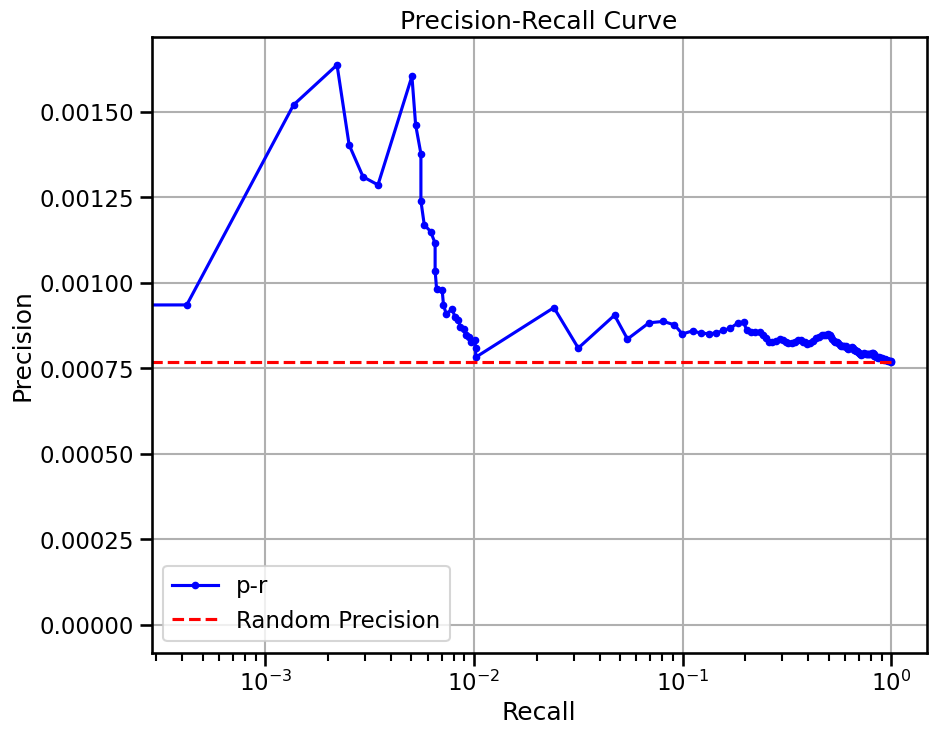

base enrichment


Top central genes: []


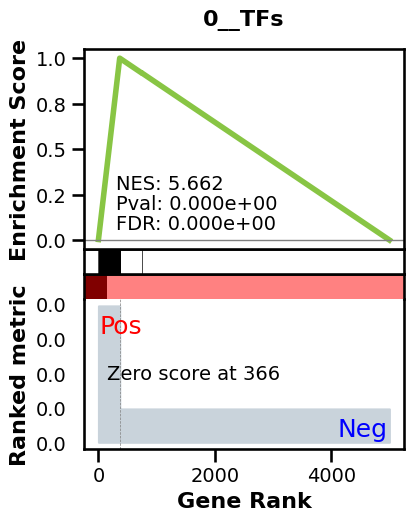

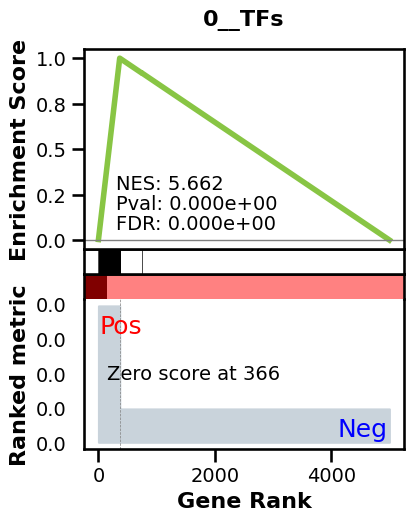

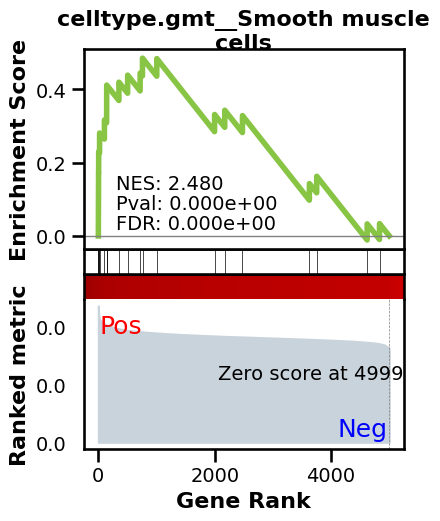

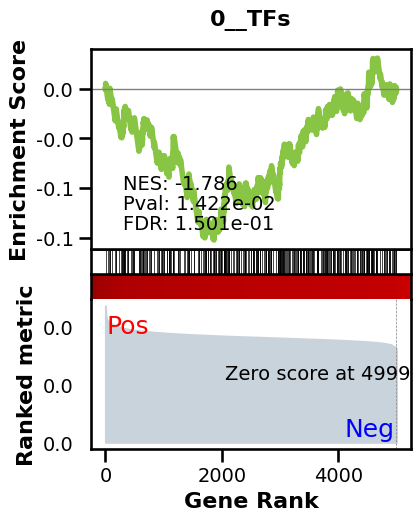

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3522 genes
intersection pct: 0.7044
precision:  0.002834563694870339 
recall:  0.31436968615513805 
random precision: 0.0007682468505265962



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 57.92it/s]


  9%|▉         | 12/128 [00:00<00:02, 57.69it/s]


 14%|█▍        | 18/128 [00:00<00:01, 57.68it/s]


 19%|█▉        | 24/128 [00:00<00:01, 57.68it/s]


 23%|██▎       | 30/128 [00:00<00:01, 57.66it/s]


 28%|██▊       | 36/128 [00:00<00:01, 57.66it/s]


 33%|███▎      | 42/128 [00:00<00:01, 57.60it/s]


 38%|███▊      | 48/128 [00:00<00:01, 57.60it/s]


 42%|████▏     | 54/128 [00:00<00:01, 57.60it/s]


 47%|████▋     | 60/128 [00:01<00:01, 57.58it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 57.58it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 57.55it/s]


 61%|██████    | 78/128 [00:01<00:00, 57.54it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 57.55it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.56it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 57.61it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 57.61it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 57.63it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 57.46it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 57.50it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 57.54it/s]


100%|██████████| 128/128 [00:02<00:00, 57.56it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0014717817144594561
EPR: 4.671546978863012


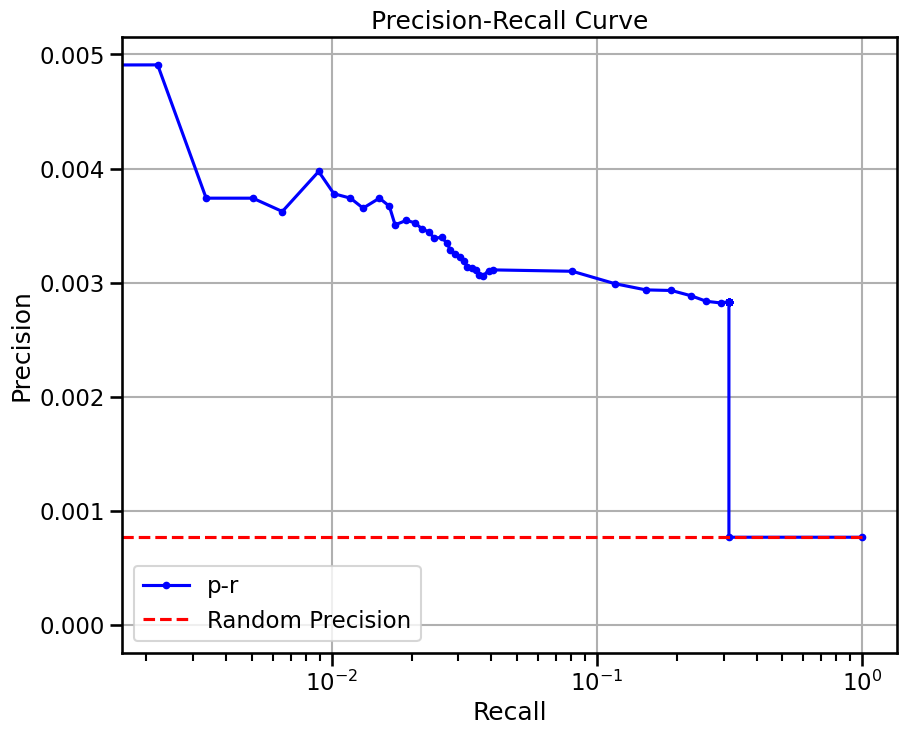


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:16,  1.49it/s]


  1%|          | 2/205 [00:01<02:16,  1.49it/s]


  1%|▏         | 3/205 [00:02<02:16,  1.48it/s]


  2%|▏         | 4/205 [00:02<02:15,  1.48it/s]


  2%|▏         | 5/205 [00:03<02:15,  1.48it/s]


  3%|▎         | 6/205 [00:04<02:14,  1.48it/s]


  3%|▎         | 7/205 [00:04<02:13,  1.48it/s]


  4%|▍         | 8/205 [00:05<02:13,  1.48it/s]


  4%|▍         | 9/205 [00:06<02:12,  1.48it/s]


  5%|▍         | 10/205 [00:06<02:11,  1.48it/s]


  5%|▌         | 11/205 [00:07<02:10,  1.49it/s]


  6%|▌         | 12/205 [00:08<02:08,  1.50it/s]


  6%|▋         | 13/205 [00:08<02:08,  1.49it/s]


  7%|▋         | 14/205 [00:09<02:08,  1.49it/s]


  7%|▋         | 15/205 [00:10<02:07,  1.49it/s]


  8%|▊         | 16/205 [00:10<02:06,  1.49it/s]


  8%|▊         | 17/205 [00:11<02:06,  1.49it/s]


  9%|▉         | 18/205 [00:12<02:05,  1.49it/s]


  9%|▉         | 19/205 [00:12<02:05,  1.48it/s]


 10%|▉         | 20/205 [00:13<02:04,  1.49it/s]


 10%|█         | 21/205 [00:14<02:03,  1.48it/s]


 11%|█         | 22/205 [00:14<02:02,  1.49it/s]


 11%|█         | 23/205 [00:15<02:02,  1.49it/s]


 12%|█▏        | 24/205 [00:16<02:01,  1.49it/s]


 12%|█▏        | 25/205 [00:16<02:00,  1.49it/s]


 13%|█▎        | 26/205 [00:17<01:59,  1.50it/s]


 13%|█▎        | 27/205 [00:18<01:59,  1.49it/s]


 14%|█▎        | 28/205 [00:18<01:59,  1.49it/s]


 14%|█▍        | 29/205 [00:19<01:58,  1.48it/s]


 15%|█▍        | 30/205 [00:20<01:57,  1.48it/s]


 15%|█▌        | 31/205 [00:20<01:57,  1.48it/s]


 16%|█▌        | 32/205 [00:21<01:56,  1.48it/s]


 16%|█▌        | 33/205 [00:22<01:56,  1.48it/s]


 17%|█▋        | 34/205 [00:22<01:55,  1.48it/s]


 17%|█▋        | 35/205 [00:23<01:54,  1.48it/s]


 18%|█▊        | 36/205 [00:24<01:54,  1.48it/s]


 18%|█▊        | 37/205 [00:24<01:53,  1.49it/s]


 19%|█▊        | 38/205 [00:25<01:52,  1.48it/s]


 19%|█▉        | 39/205 [00:26<01:51,  1.49it/s]


 20%|█▉        | 40/205 [00:26<01:51,  1.49it/s]


 20%|██        | 41/205 [00:27<01:50,  1.48it/s]


 20%|██        | 42/205 [00:28<01:49,  1.48it/s]


 21%|██        | 43/205 [00:28<01:48,  1.49it/s]


 21%|██▏       | 44/205 [00:29<01:48,  1.48it/s]


 22%|██▏       | 45/205 [00:30<01:47,  1.48it/s]


 22%|██▏       | 46/205 [00:30<01:47,  1.48it/s]


 23%|██▎       | 47/205 [00:31<01:46,  1.48it/s]


 23%|██▎       | 48/205 [00:32<01:45,  1.48it/s]


 24%|██▍       | 49/205 [00:32<01:45,  1.48it/s]


 24%|██▍       | 50/205 [00:33<01:44,  1.48it/s]


 25%|██▍       | 51/205 [00:34<01:44,  1.48it/s]


 25%|██▌       | 52/205 [00:35<01:43,  1.48it/s]


 26%|██▌       | 53/205 [00:35<01:42,  1.48it/s]


 26%|██▋       | 54/205 [00:36<01:42,  1.48it/s]


 27%|██▋       | 55/205 [00:37<01:41,  1.48it/s]


 27%|██▋       | 56/205 [00:37<01:40,  1.48it/s]


 28%|██▊       | 57/205 [00:38<01:40,  1.47it/s]


 28%|██▊       | 58/205 [00:39<01:39,  1.47it/s]


 29%|██▉       | 59/205 [00:39<01:38,  1.48it/s]


 29%|██▉       | 60/205 [00:40<01:38,  1.48it/s]


 30%|██▉       | 61/205 [00:41<01:37,  1.47it/s]


 30%|███       | 62/205 [00:41<01:36,  1.47it/s]


 31%|███       | 63/205 [00:42<01:36,  1.47it/s]


 31%|███       | 64/205 [00:43<01:35,  1.47it/s]


 32%|███▏      | 65/205 [00:43<01:35,  1.47it/s]


 32%|███▏      | 66/205 [00:44<01:34,  1.47it/s]


 33%|███▎      | 67/205 [00:45<01:33,  1.47it/s]


 33%|███▎      | 68/205 [00:45<01:33,  1.47it/s]


 34%|███▎      | 69/205 [00:46<01:32,  1.47it/s]


 34%|███▍      | 70/205 [00:47<01:31,  1.47it/s]


 35%|███▍      | 71/205 [00:47<01:30,  1.47it/s]


 35%|███▌      | 72/205 [00:48<01:30,  1.47it/s]


 36%|███▌      | 73/205 [00:49<01:29,  1.48it/s]


 36%|███▌      | 74/205 [00:49<01:28,  1.48it/s]


 37%|███▋      | 75/205 [00:50<01:28,  1.48it/s]


 37%|███▋      | 76/205 [00:51<01:27,  1.47it/s]


 38%|███▊      | 77/205 [00:51<01:26,  1.47it/s]


 38%|███▊      | 78/205 [00:52<01:25,  1.48it/s]


 39%|███▊      | 79/205 [00:53<01:25,  1.48it/s]


 39%|███▉      | 80/205 [00:54<01:24,  1.48it/s]


 40%|███▉      | 81/205 [00:54<01:23,  1.48it/s]


 40%|████      | 82/205 [00:55<01:23,  1.48it/s]


 40%|████      | 83/205 [00:56<01:22,  1.48it/s]


 41%|████      | 84/205 [00:56<01:21,  1.48it/s]


 41%|████▏     | 85/205 [00:57<01:20,  1.48it/s]


 42%|████▏     | 86/205 [00:58<01:20,  1.48it/s]


 42%|████▏     | 87/205 [00:58<01:19,  1.48it/s]


 43%|████▎     | 88/205 [00:59<01:19,  1.48it/s]


 43%|████▎     | 89/205 [01:00<01:18,  1.48it/s]


 44%|████▍     | 90/205 [01:00<01:18,  1.47it/s]


 44%|████▍     | 91/205 [01:01<01:17,  1.47it/s]


 45%|████▍     | 92/205 [01:02<01:16,  1.48it/s]


 45%|████▌     | 93/205 [01:02<01:15,  1.47it/s]


 46%|████▌     | 94/205 [01:03<01:14,  1.48it/s]


 46%|████▋     | 95/205 [01:04<01:14,  1.48it/s]


 47%|████▋     | 96/205 [01:04<01:13,  1.47it/s]


 47%|████▋     | 97/205 [01:05<01:13,  1.47it/s]


 48%|████▊     | 98/205 [01:06<01:12,  1.47it/s]


 48%|████▊     | 99/205 [01:06<01:11,  1.48it/s]


 49%|████▉     | 100/205 [01:07<01:11,  1.47it/s]


 49%|████▉     | 101/205 [01:08<01:10,  1.47it/s]


 50%|████▉     | 102/205 [01:08<01:10,  1.47it/s]


 50%|█████     | 103/205 [01:09<01:09,  1.47it/s]


 51%|█████     | 104/205 [01:10<01:08,  1.47it/s]


 51%|█████     | 105/205 [01:10<01:08,  1.47it/s]


 52%|█████▏    | 106/205 [01:11<01:07,  1.47it/s]


 52%|█████▏    | 107/205 [01:12<01:06,  1.47it/s]


 53%|█████▎    | 108/205 [01:13<01:06,  1.47it/s]


 53%|█████▎    | 109/205 [01:13<01:05,  1.47it/s]


 54%|█████▎    | 110/205 [01:14<01:04,  1.47it/s]


 54%|█████▍    | 111/205 [01:15<01:04,  1.47it/s]


 55%|█████▍    | 112/205 [01:15<01:03,  1.47it/s]


 55%|█████▌    | 113/205 [01:16<01:02,  1.47it/s]


 56%|█████▌    | 114/205 [01:17<01:01,  1.47it/s]


 56%|█████▌    | 115/205 [01:17<01:01,  1.47it/s]


 57%|█████▋    | 116/205 [01:18<01:00,  1.47it/s]


 57%|█████▋    | 117/205 [01:19<00:59,  1.47it/s]


 58%|█████▊    | 118/205 [01:19<00:59,  1.47it/s]


 58%|█████▊    | 119/205 [01:20<00:58,  1.47it/s]


 59%|█████▊    | 120/205 [01:21<00:57,  1.47it/s]


 59%|█████▉    | 121/205 [01:21<00:57,  1.47it/s]


 60%|█████▉    | 122/205 [01:22<00:56,  1.47it/s]


 60%|██████    | 123/205 [01:23<00:55,  1.47it/s]


 60%|██████    | 124/205 [01:23<00:55,  1.47it/s]


 61%|██████    | 125/205 [01:24<00:54,  1.47it/s]


 61%|██████▏   | 126/205 [01:25<00:53,  1.47it/s]


 62%|██████▏   | 127/205 [01:25<00:52,  1.47it/s]


 62%|██████▏   | 128/205 [01:26<00:52,  1.47it/s]


 63%|██████▎   | 129/205 [01:27<00:51,  1.47it/s]


 63%|██████▎   | 130/205 [01:27<00:51,  1.47it/s]


 64%|██████▍   | 131/205 [01:28<00:50,  1.46it/s]


 64%|██████▍   | 132/205 [01:29<00:49,  1.47it/s]


 65%|██████▍   | 133/205 [01:30<00:49,  1.47it/s]


 65%|██████▌   | 134/205 [01:30<00:48,  1.47it/s]


 66%|██████▌   | 135/205 [01:31<00:48,  1.46it/s]


 66%|██████▋   | 136/205 [01:32<00:47,  1.46it/s]


 67%|██████▋   | 137/205 [01:32<00:46,  1.46it/s]


 67%|██████▋   | 138/205 [01:33<00:45,  1.46it/s]


 68%|██████▊   | 139/205 [01:34<00:45,  1.46it/s]


 68%|██████▊   | 140/205 [01:34<00:44,  1.47it/s]


 69%|██████▉   | 141/205 [01:35<00:43,  1.47it/s]


 69%|██████▉   | 142/205 [01:36<00:42,  1.47it/s]


 70%|██████▉   | 143/205 [01:36<00:42,  1.47it/s]


 70%|███████   | 144/205 [01:37<00:41,  1.47it/s]


 71%|███████   | 145/205 [01:38<00:40,  1.47it/s]


 71%|███████   | 146/205 [01:38<00:40,  1.47it/s]


 72%|███████▏  | 147/205 [01:39<00:39,  1.47it/s]


 72%|███████▏  | 148/205 [01:40<00:38,  1.47it/s]


 73%|███████▎  | 149/205 [01:40<00:38,  1.47it/s]


 73%|███████▎  | 150/205 [01:41<00:37,  1.47it/s]


 74%|███████▎  | 151/205 [01:42<00:36,  1.47it/s]


 74%|███████▍  | 152/205 [01:43<00:36,  1.46it/s]


 75%|███████▍  | 153/205 [01:43<00:35,  1.46it/s]


 75%|███████▌  | 154/205 [01:44<00:34,  1.46it/s]


 76%|███████▌  | 155/205 [01:45<00:34,  1.46it/s]


 76%|███████▌  | 156/205 [01:45<00:33,  1.47it/s]


 77%|███████▋  | 157/205 [01:46<00:32,  1.47it/s]


 77%|███████▋  | 158/205 [01:47<00:32,  1.46it/s]


 78%|███████▊  | 159/205 [01:47<00:31,  1.46it/s]


 78%|███████▊  | 160/205 [01:48<00:30,  1.46it/s]


 79%|███████▊  | 161/205 [01:49<00:29,  1.47it/s]


 79%|███████▉  | 162/205 [01:49<00:29,  1.47it/s]


 80%|███████▉  | 163/205 [01:50<00:28,  1.47it/s]


 80%|████████  | 164/205 [01:51<00:27,  1.47it/s]


 80%|████████  | 165/205 [01:51<00:27,  1.46it/s]


 81%|████████  | 166/205 [01:52<00:26,  1.47it/s]


 81%|████████▏ | 167/205 [01:53<00:25,  1.47it/s]


 82%|████████▏ | 168/205 [01:53<00:25,  1.47it/s]


 82%|████████▏ | 169/205 [01:54<00:24,  1.47it/s]


 83%|████████▎ | 170/205 [01:55<00:23,  1.47it/s]


 83%|████████▎ | 171/205 [01:55<00:23,  1.47it/s]


 84%|████████▍ | 172/205 [01:56<00:22,  1.47it/s]


 84%|████████▍ | 173/205 [01:57<00:21,  1.47it/s]


 85%|████████▍ | 174/205 [01:58<00:21,  1.47it/s]


 85%|████████▌ | 175/205 [01:58<00:20,  1.47it/s]


 86%|████████▌ | 176/205 [01:59<00:19,  1.47it/s]


 86%|████████▋ | 177/205 [02:00<00:19,  1.47it/s]


 87%|████████▋ | 178/205 [02:00<00:18,  1.48it/s]


 87%|████████▋ | 179/205 [02:01<00:17,  1.47it/s]


 88%|████████▊ | 180/205 [02:02<00:17,  1.47it/s]


 88%|████████▊ | 181/205 [02:02<00:16,  1.47it/s]


 89%|████████▉ | 182/205 [02:03<00:15,  1.47it/s]


 89%|████████▉ | 183/205 [02:04<00:15,  1.47it/s]


 90%|████████▉ | 184/205 [02:04<00:14,  1.47it/s]


 90%|█████████ | 185/205 [02:05<00:13,  1.47it/s]


 91%|█████████ | 186/205 [02:06<00:12,  1.47it/s]


 91%|█████████ | 187/205 [02:06<00:12,  1.46it/s]


 92%|█████████▏| 188/205 [02:07<00:11,  1.47it/s]


 92%|█████████▏| 189/205 [02:08<00:10,  1.47it/s]


 93%|█████████▎| 190/205 [02:08<00:10,  1.46it/s]


 93%|█████████▎| 191/205 [02:09<00:09,  1.46it/s]


 94%|█████████▎| 192/205 [02:10<00:08,  1.46it/s]


 94%|█████████▍| 193/205 [02:10<00:08,  1.46it/s]


 95%|█████████▍| 194/205 [02:11<00:07,  1.46it/s]


 95%|█████████▌| 195/205 [02:12<00:06,  1.46it/s]


 96%|█████████▌| 196/205 [02:13<00:06,  1.46it/s]


 96%|█████████▌| 197/205 [02:13<00:05,  1.45it/s]


 97%|█████████▋| 198/205 [02:14<00:04,  1.45it/s]


 97%|█████████▋| 199/205 [02:15<00:04,  1.45it/s]


 98%|█████████▊| 200/205 [02:15<00:03,  1.45it/s]


 98%|█████████▊| 201/205 [02:16<00:02,  1.45it/s]


 99%|█████████▊| 202/205 [02:17<00:02,  1.45it/s]


 99%|█████████▉| 203/205 [02:17<00:01,  1.46it/s]


100%|█████████▉| 204/205 [02:18<00:00,  1.46it/s]


100%|██████████| 205/205 [02:19<00:00,  1.55it/s]


100%|██████████| 205/205 [02:19<00:00,  1.47it/s]

base enrichment


Top central genes: []


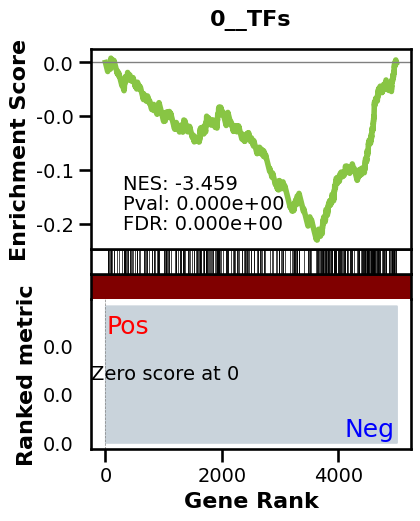

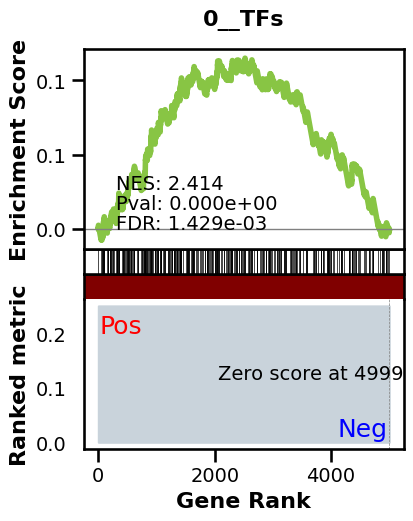

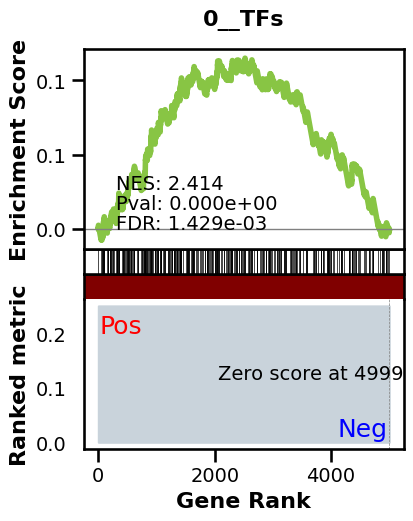

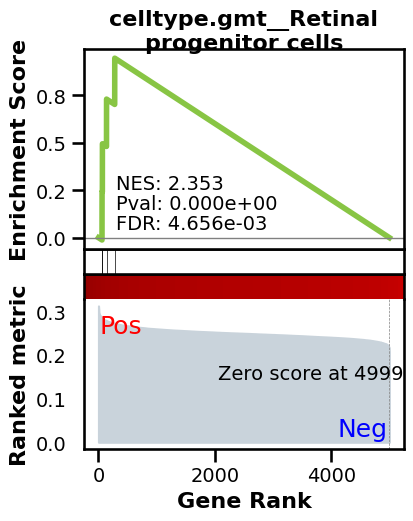

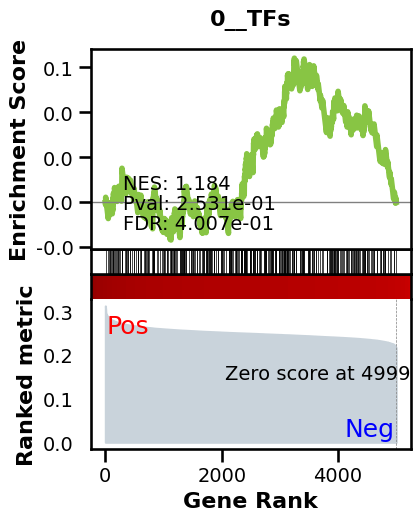

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3550 genes
intersection pct: 0.71
precision:  0.0010244792699861138 
recall:  1.0 
random precision: 0.0010247679370106238



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 54.41it/s]


  9%|▉         | 12/128 [00:00<00:02, 54.22it/s]


 14%|█▍        | 18/128 [00:00<00:02, 54.13it/s]


 19%|█▉        | 24/128 [00:00<00:01, 53.92it/s]


 23%|██▎       | 30/128 [00:00<00:01, 53.96it/s]


 28%|██▊       | 36/128 [00:00<00:01, 53.96it/s]


 33%|███▎      | 42/128 [00:00<00:01, 53.99it/s]


 38%|███▊      | 48/128 [00:00<00:01, 53.99it/s]


 42%|████▏     | 54/128 [00:00<00:01, 54.02it/s]


 47%|████▋     | 60/128 [00:01<00:01, 54.01it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 54.05it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 54.05it/s]


 61%|██████    | 78/128 [00:01<00:00, 54.08it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 54.08it/s]


 70%|███████   | 90/128 [00:01<00:00, 54.07it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 54.05it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 54.07it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 54.06it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 54.07it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 54.06it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 54.05it/s]


100%|██████████| 128/128 [00:02<00:00, 54.02it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0011516831906021913
EPR: 0.5285583157555493


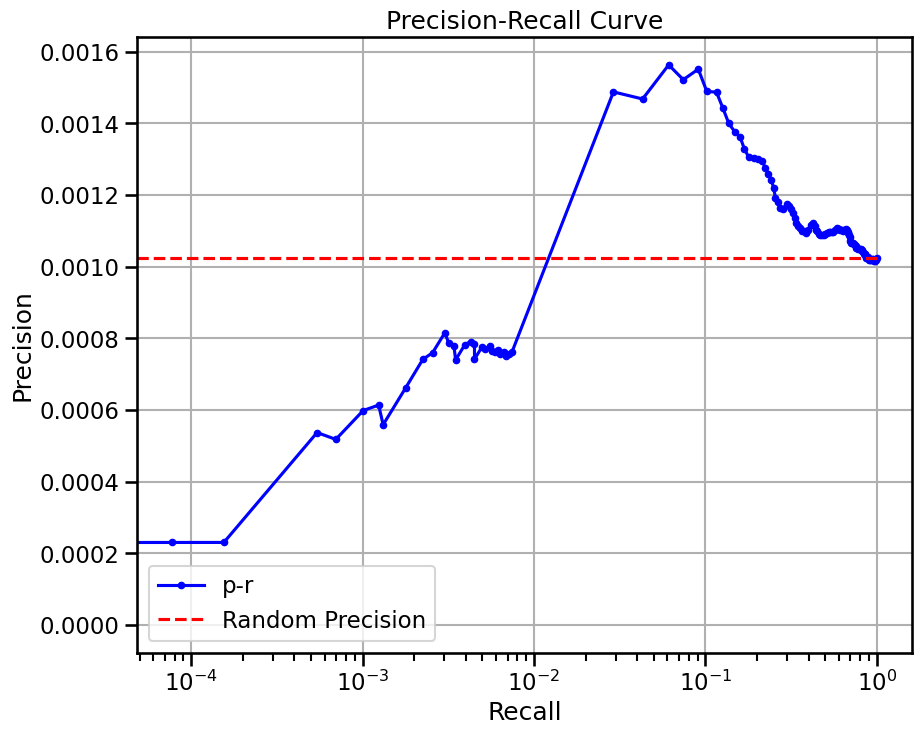

base enrichment


Top central genes: []


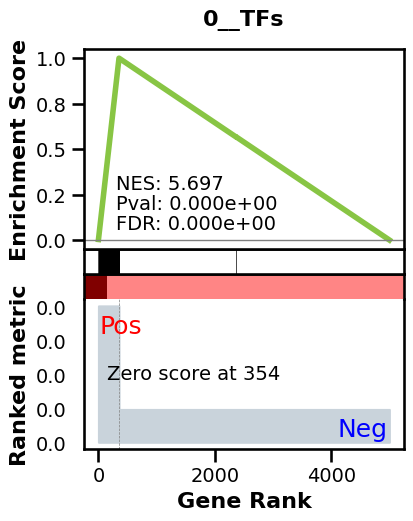

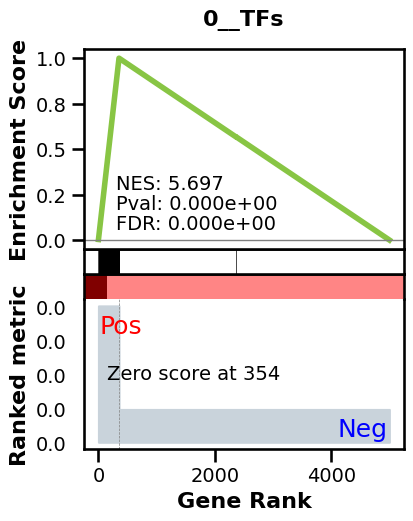

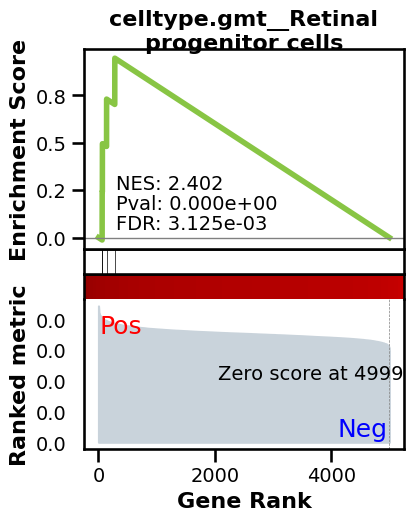

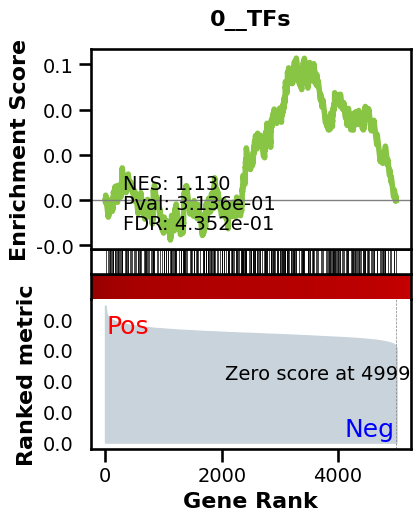

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3550 genes
intersection pct: 0.71
precision:  0.003774647887323944 
recall:  0.3165517775540237 
random precision: 0.0010247679370106238



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 54.88it/s]


  9%|▉         | 12/128 [00:00<00:02, 55.08it/s]


 14%|█▍        | 18/128 [00:00<00:01, 55.13it/s]


 19%|█▉        | 24/128 [00:00<00:01, 55.14it/s]


 23%|██▎       | 30/128 [00:00<00:01, 55.19it/s]


 28%|██▊       | 36/128 [00:00<00:01, 55.20it/s]


 33%|███▎      | 42/128 [00:00<00:01, 55.18it/s]


 38%|███▊      | 48/128 [00:00<00:01, 55.21it/s]


 42%|████▏     | 54/128 [00:00<00:01, 55.18it/s]


 47%|████▋     | 60/128 [00:01<00:01, 55.15it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 55.03it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 55.08it/s]


 61%|██████    | 78/128 [00:01<00:00, 55.14it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 55.14it/s]


 70%|███████   | 90/128 [00:01<00:00, 55.16it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 55.17it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 55.19it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 55.20it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 55.23it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 55.22it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 55.21it/s]


100%|██████████| 128/128 [00:02<00:00, 55.15it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0020114985673581297
EPR: 4.1840435728353205


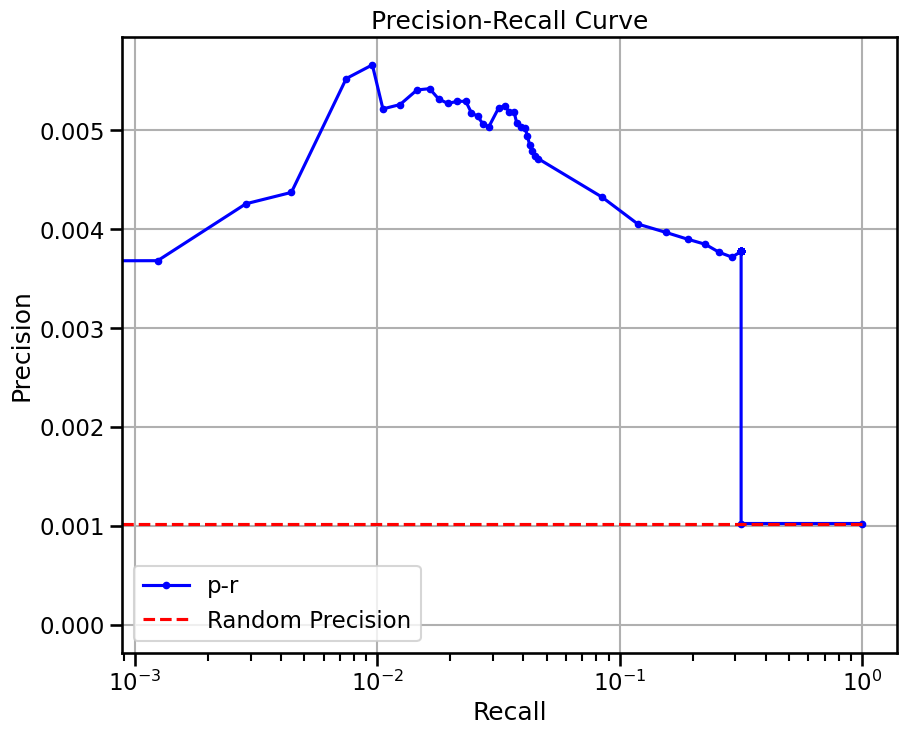


  0%|          | 0/99 [00:00<?, ?it/s]


  1%|          | 1/99 [00:00<01:05,  1.49it/s]


  2%|▏         | 2/99 [00:01<01:05,  1.48it/s]


  3%|▎         | 3/99 [00:02<01:04,  1.49it/s]


  4%|▍         | 4/99 [00:02<01:03,  1.50it/s]


  5%|▌         | 5/99 [00:03<01:02,  1.50it/s]


  6%|▌         | 6/99 [00:03<01:01,  1.51it/s]


  7%|▋         | 7/99 [00:04<01:01,  1.51it/s]


  8%|▊         | 8/99 [00:05<01:00,  1.51it/s]


  9%|▉         | 9/99 [00:05<00:59,  1.51it/s]


 10%|█         | 10/99 [00:06<00:59,  1.51it/s]


 11%|█         | 11/99 [00:07<00:58,  1.51it/s]


 12%|█▏        | 12/99 [00:07<00:57,  1.51it/s]


 13%|█▎        | 13/99 [00:08<00:57,  1.51it/s]


 14%|█▍        | 14/99 [00:09<00:56,  1.51it/s]


 15%|█▌        | 15/99 [00:09<00:55,  1.51it/s]


 16%|█▌        | 16/99 [00:10<00:55,  1.51it/s]


 17%|█▋        | 17/99 [00:11<00:54,  1.51it/s]


 18%|█▊        | 18/99 [00:11<00:53,  1.50it/s]


 19%|█▉        | 19/99 [00:12<00:53,  1.50it/s]


 20%|██        | 20/99 [00:13<00:52,  1.50it/s]


 21%|██        | 21/99 [00:13<00:51,  1.50it/s]


 22%|██▏       | 22/99 [00:14<00:51,  1.50it/s]


 23%|██▎       | 23/99 [00:15<00:50,  1.50it/s]


 24%|██▍       | 24/99 [00:15<00:49,  1.50it/s]


 25%|██▌       | 25/99 [00:16<00:49,  1.50it/s]


 26%|██▋       | 26/99 [00:17<00:48,  1.50it/s]


 27%|██▋       | 27/99 [00:17<00:47,  1.50it/s]


 28%|██▊       | 28/99 [00:18<00:47,  1.50it/s]


 29%|██▉       | 29/99 [00:19<00:46,  1.50it/s]


 30%|███       | 30/99 [00:19<00:45,  1.50it/s]


 31%|███▏      | 31/99 [00:20<00:45,  1.50it/s]


 32%|███▏      | 32/99 [00:21<00:44,  1.50it/s]


 33%|███▎      | 33/99 [00:21<00:43,  1.50it/s]


 34%|███▍      | 34/99 [00:22<00:43,  1.50it/s]


 35%|███▌      | 35/99 [00:23<00:42,  1.50it/s]


 36%|███▋      | 36/99 [00:23<00:41,  1.50it/s]


 37%|███▋      | 37/99 [00:24<00:41,  1.50it/s]


 38%|███▊      | 38/99 [00:25<00:40,  1.50it/s]


 39%|███▉      | 39/99 [00:25<00:40,  1.50it/s]


 40%|████      | 40/99 [00:26<00:39,  1.50it/s]


 41%|████▏     | 41/99 [00:27<00:38,  1.50it/s]


 42%|████▏     | 42/99 [00:27<00:38,  1.50it/s]


 43%|████▎     | 43/99 [00:28<00:37,  1.50it/s]


 44%|████▍     | 44/99 [00:29<00:36,  1.50it/s]


 45%|████▌     | 45/99 [00:29<00:36,  1.50it/s]


 46%|████▋     | 46/99 [00:30<00:35,  1.50it/s]


 47%|████▋     | 47/99 [00:31<00:34,  1.50it/s]


 48%|████▊     | 48/99 [00:31<00:34,  1.50it/s]


 49%|████▉     | 49/99 [00:32<00:33,  1.50it/s]


 51%|█████     | 50/99 [00:33<00:32,  1.50it/s]


 52%|█████▏    | 51/99 [00:33<00:32,  1.50it/s]


 53%|█████▎    | 52/99 [00:34<00:31,  1.50it/s]


 54%|█████▎    | 53/99 [00:35<00:30,  1.50it/s]


 55%|█████▍    | 54/99 [00:35<00:30,  1.50it/s]


 56%|█████▌    | 55/99 [00:36<00:29,  1.48it/s]


 57%|█████▋    | 56/99 [00:37<00:28,  1.49it/s]


 58%|█████▊    | 57/99 [00:37<00:28,  1.49it/s]


 59%|█████▊    | 58/99 [00:38<00:27,  1.49it/s]


 60%|█████▉    | 59/99 [00:39<00:26,  1.49it/s]


 61%|██████    | 60/99 [00:40<00:26,  1.49it/s]


 62%|██████▏   | 61/99 [00:40<00:25,  1.49it/s]


 63%|██████▎   | 62/99 [00:41<00:24,  1.49it/s]


 64%|██████▎   | 63/99 [00:42<00:24,  1.49it/s]


 65%|██████▍   | 64/99 [00:42<00:23,  1.49it/s]


 66%|██████▌   | 65/99 [00:43<00:22,  1.49it/s]


 67%|██████▋   | 66/99 [00:44<00:22,  1.49it/s]


 68%|██████▊   | 67/99 [00:44<00:21,  1.49it/s]


 69%|██████▊   | 68/99 [00:45<00:20,  1.49it/s]


 70%|██████▉   | 69/99 [00:46<00:20,  1.49it/s]


 71%|███████   | 70/99 [00:46<00:19,  1.49it/s]


 72%|███████▏  | 71/99 [00:47<00:18,  1.49it/s]


 73%|███████▎  | 72/99 [00:48<00:18,  1.49it/s]


 74%|███████▎  | 73/99 [00:48<00:17,  1.49it/s]


 75%|███████▍  | 74/99 [00:49<00:16,  1.49it/s]


 76%|███████▌  | 75/99 [00:50<00:16,  1.49it/s]


 77%|███████▋  | 76/99 [00:50<00:15,  1.49it/s]


 78%|███████▊  | 77/99 [00:51<00:14,  1.49it/s]


 79%|███████▉  | 78/99 [00:52<00:14,  1.49it/s]


 80%|███████▉  | 79/99 [00:52<00:13,  1.49it/s]


 81%|████████  | 80/99 [00:53<00:12,  1.49it/s]


 82%|████████▏ | 81/99 [00:54<00:12,  1.49it/s]


 83%|████████▎ | 82/99 [00:54<00:11,  1.49it/s]


 84%|████████▍ | 83/99 [00:55<00:10,  1.49it/s]


 85%|████████▍ | 84/99 [00:56<00:10,  1.49it/s]


 86%|████████▌ | 85/99 [00:56<00:09,  1.49it/s]


 87%|████████▋ | 86/99 [00:57<00:08,  1.49it/s]


 88%|████████▊ | 87/99 [00:58<00:08,  1.49it/s]


 89%|████████▉ | 88/99 [00:58<00:07,  1.49it/s]


 90%|████████▉ | 89/99 [00:59<00:06,  1.49it/s]


 91%|█████████ | 90/99 [01:00<00:06,  1.49it/s]


 92%|█████████▏| 91/99 [01:00<00:05,  1.49it/s]


 93%|█████████▎| 92/99 [01:01<00:04,  1.49it/s]


 94%|█████████▍| 93/99 [01:02<00:04,  1.49it/s]


 95%|█████████▍| 94/99 [01:02<00:03,  1.49it/s]


 96%|█████████▌| 95/99 [01:03<00:02,  1.49it/s]


 97%|█████████▋| 96/99 [01:04<00:02,  1.49it/s]


 98%|█████████▊| 97/99 [01:04<00:01,  1.49it/s]


 99%|█████████▉| 98/99 [01:05<00:00,  1.49it/s]


100%|██████████| 99/99 [01:05<00:00,  1.69it/s]


100%|██████████| 99/99 [01:05<00:00,  1.50it/s]

base enrichment


Top central genes: []


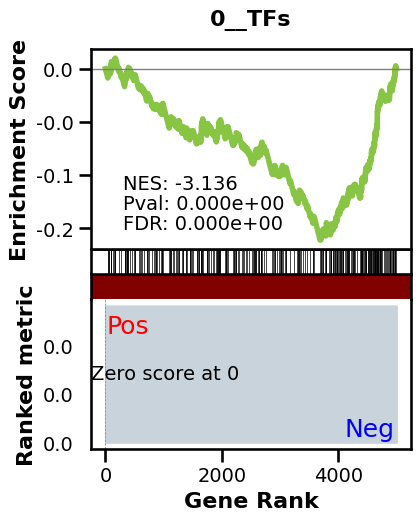

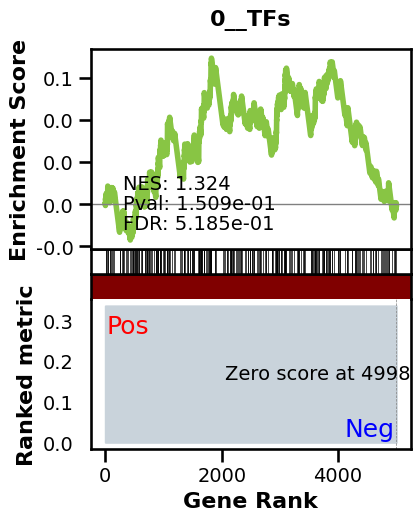

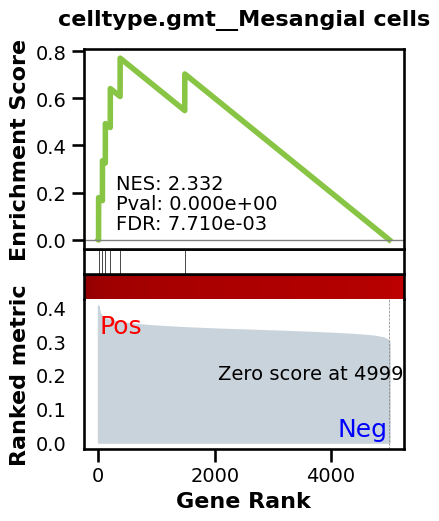

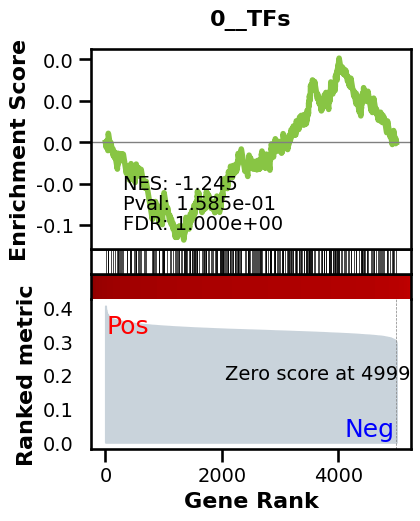

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3676 genes
intersection pct: 0.7352
precision:  0.000953231915752681 
recall:  1.0 
random precision: 0.0009534912985868993



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.01it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.05it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.02it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.01it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.02it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.03it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.04it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.05it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.04it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.03it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.04it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.06it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.04it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.05it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.05it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 51.05it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.04it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.07it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.08it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.07it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.04it/s]


100%|██████████| 128/128 [00:02<00:00, 51.03it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0010996872431988881
EPR: 0.8139160355411694


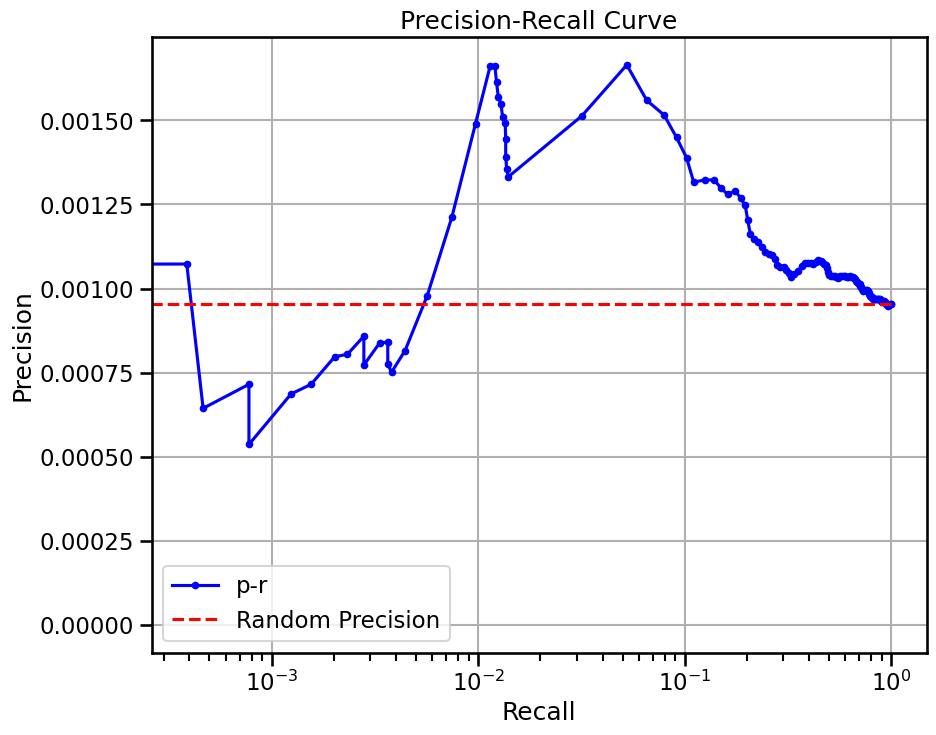

base enrichment


Top central genes: []


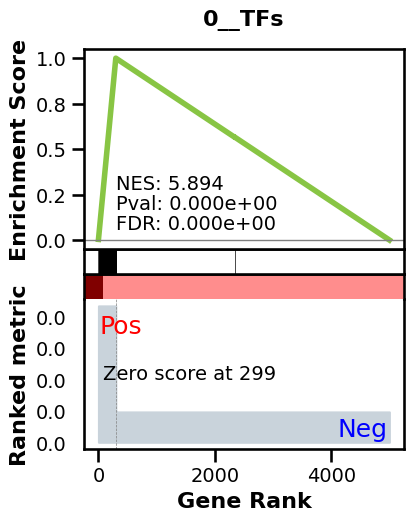

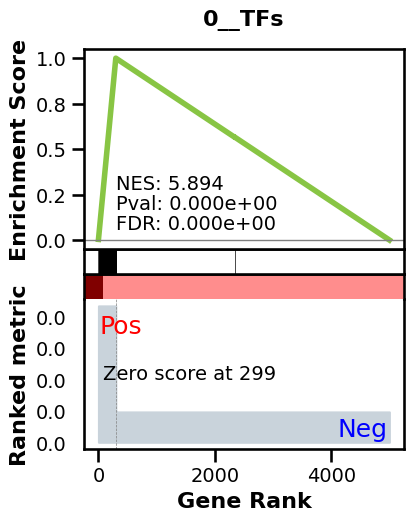

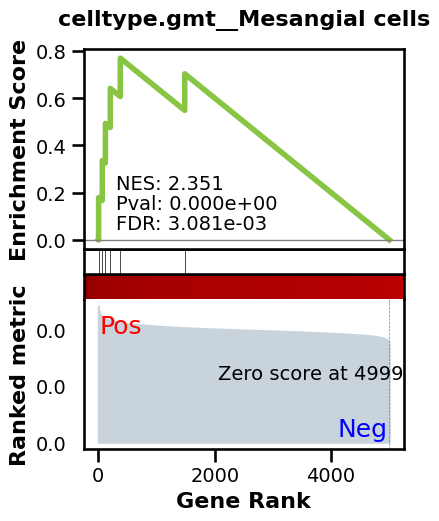

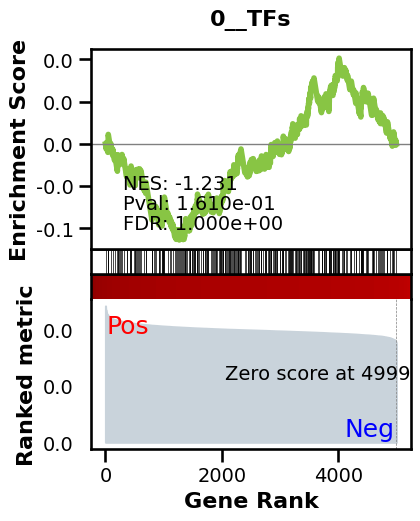

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3676 genes
intersection pct: 0.7352
precision:  0.0031289255990017686 
recall:  0.23127086406334912 
random precision: 0.0009534912985868993



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.41it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.31it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.39it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.45it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.36it/s]


 28%|██▊       | 36/128 [00:00<00:01, 50.66it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.97it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.08it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.20it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.19it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.30it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.33it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.30it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.30it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.35it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 51.39it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.39it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.39it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.38it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.43it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.39it/s]


100%|██████████| 128/128 [00:02<00:00, 51.28it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0015453967964625627
EPR: 5.0873223260330676


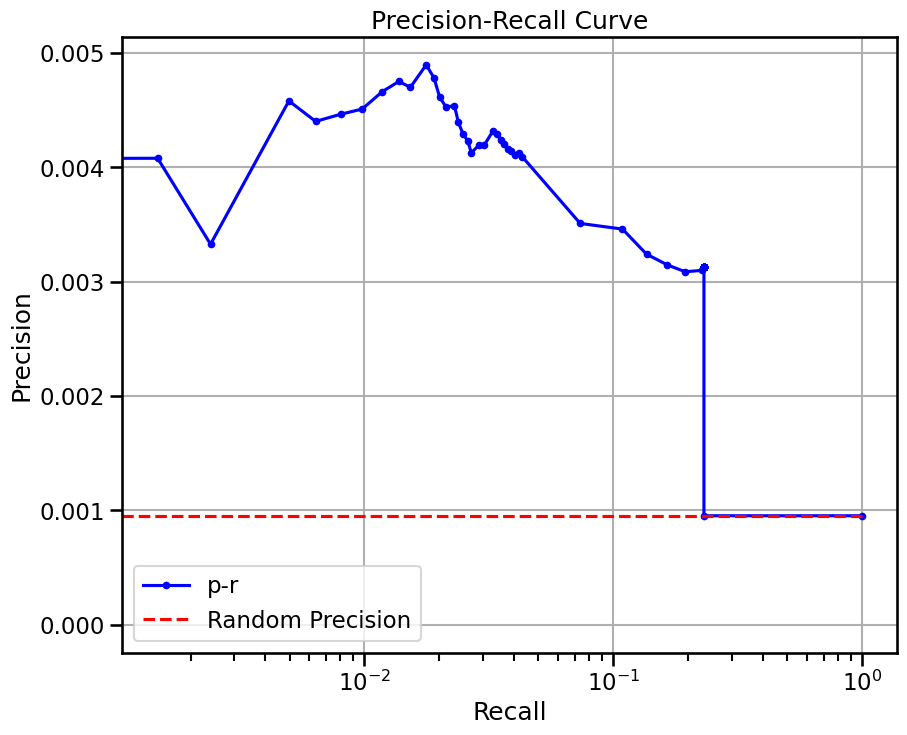


  0%|          | 0/47 [00:00<?, ?it/s]


  2%|▏         | 1/47 [00:00<00:30,  1.49it/s]


  4%|▍         | 2/47 [00:01<00:30,  1.49it/s]


  6%|▋         | 3/47 [00:02<00:29,  1.50it/s]


  9%|▊         | 4/47 [00:02<00:28,  1.50it/s]


 11%|█         | 5/47 [00:03<00:27,  1.50it/s]


 13%|█▎        | 6/47 [00:03<00:27,  1.50it/s]


 15%|█▍        | 7/47 [00:04<00:26,  1.50it/s]


 17%|█▋        | 8/47 [00:05<00:25,  1.50it/s]


 19%|█▉        | 9/47 [00:05<00:25,  1.50it/s]


 21%|██▏       | 10/47 [00:06<00:24,  1.50it/s]


 23%|██▎       | 11/47 [00:07<00:23,  1.50it/s]


 26%|██▌       | 12/47 [00:07<00:23,  1.50it/s]


 28%|██▊       | 13/47 [00:08<00:22,  1.51it/s]


 30%|██▉       | 14/47 [00:09<00:21,  1.51it/s]


 32%|███▏      | 15/47 [00:09<00:21,  1.51it/s]


 34%|███▍      | 16/47 [00:10<00:20,  1.51it/s]


 36%|███▌      | 17/47 [00:11<00:19,  1.51it/s]


 38%|███▊      | 18/47 [00:11<00:19,  1.51it/s]


 40%|████      | 19/47 [00:12<00:18,  1.51it/s]


 43%|████▎     | 20/47 [00:13<00:17,  1.51it/s]


 45%|████▍     | 21/47 [00:13<00:17,  1.51it/s]


 47%|████▋     | 22/47 [00:14<00:16,  1.51it/s]


 49%|████▉     | 23/47 [00:15<00:15,  1.51it/s]


 51%|█████     | 24/47 [00:15<00:15,  1.51it/s]


 53%|█████▎    | 25/47 [00:16<00:14,  1.51it/s]


 55%|█████▌    | 26/47 [00:17<00:13,  1.51it/s]


 57%|█████▋    | 27/47 [00:17<00:13,  1.51it/s]


 60%|█████▉    | 28/47 [00:18<00:12,  1.51it/s]


 62%|██████▏   | 29/47 [00:19<00:11,  1.51it/s]


 64%|██████▍   | 30/47 [00:19<00:11,  1.51it/s]


 66%|██████▌   | 31/47 [00:20<00:10,  1.51it/s]


 68%|██████▊   | 32/47 [00:21<00:09,  1.51it/s]


 70%|███████   | 33/47 [00:21<00:09,  1.51it/s]


 72%|███████▏  | 34/47 [00:22<00:08,  1.50it/s]


 74%|███████▍  | 35/47 [00:23<00:07,  1.50it/s]


 77%|███████▋  | 36/47 [00:23<00:07,  1.50it/s]


 79%|███████▊  | 37/47 [00:24<00:06,  1.50it/s]


 81%|████████  | 38/47 [00:25<00:05,  1.50it/s]


 83%|████████▎ | 39/47 [00:25<00:05,  1.50it/s]


 85%|████████▌ | 40/47 [00:26<00:04,  1.50it/s]


 87%|████████▋ | 41/47 [00:27<00:03,  1.50it/s]


 89%|████████▉ | 42/47 [00:27<00:03,  1.50it/s]


 91%|█████████▏| 43/47 [00:28<00:02,  1.50it/s]


 94%|█████████▎| 44/47 [00:29<00:01,  1.50it/s]


 96%|█████████▌| 45/47 [00:29<00:01,  1.50it/s]


 98%|█████████▊| 46/47 [00:30<00:00,  1.50it/s]


100%|██████████| 47/47 [00:30<00:00,  1.83it/s]


100%|██████████| 47/47 [00:30<00:00,  1.52it/s]

base enrichment


Top central genes: []


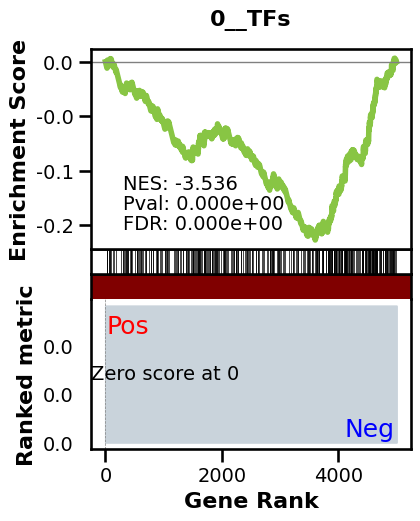

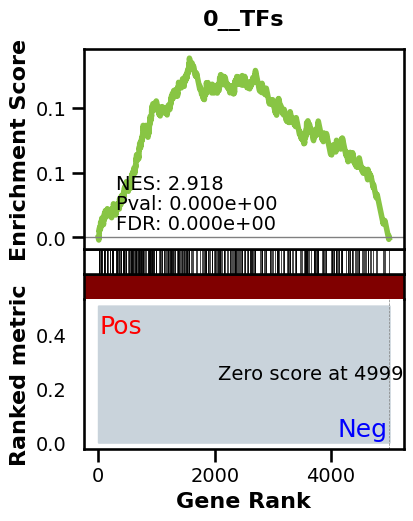

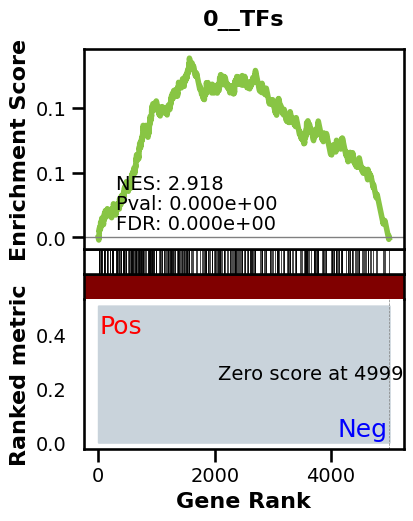

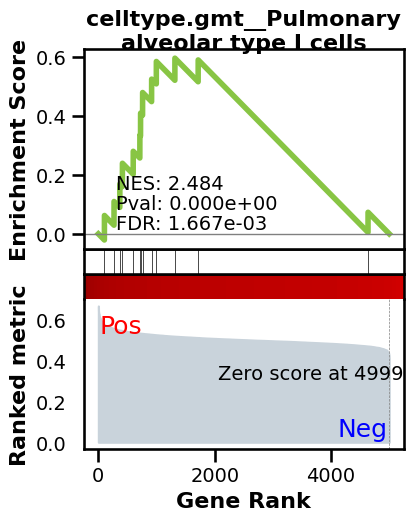

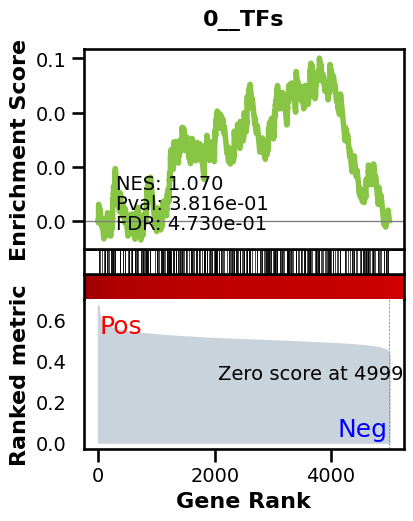

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.729
precision:  0.001431579422739307 
recall:  1.0 
random precision: 0.0014319722820759532



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 50.92it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.00it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.04it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.06it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.05it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.05it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.05it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.04it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.04it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.04it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.04it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.03it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.05it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.05it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.05it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.80it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 50.80it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 50.88it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.92it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 50.97it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.01it/s]


100%|██████████| 128/128 [00:02<00:00, 50.98it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0016667722043794172


EPR: 0.6234985721642275


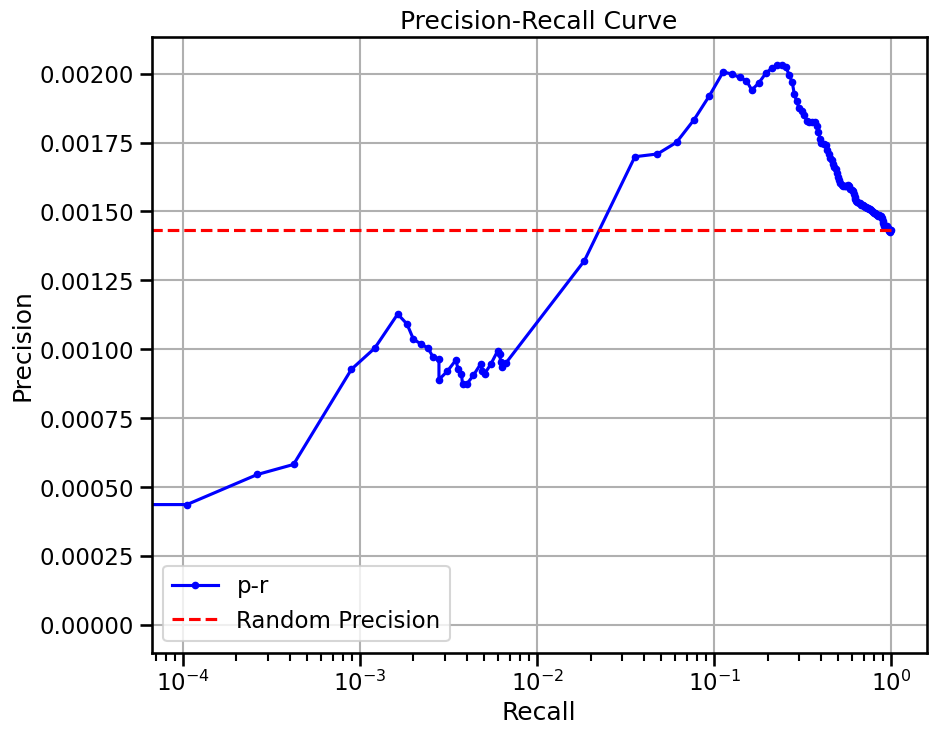

base enrichment


Top central genes: []


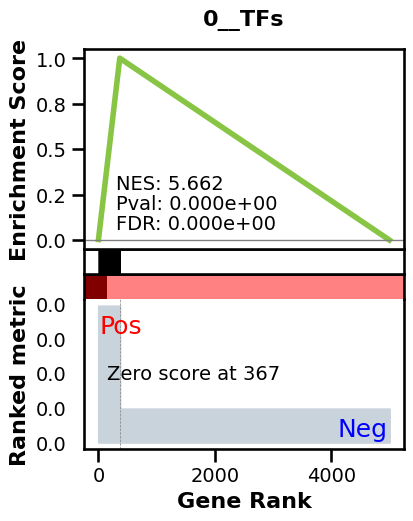

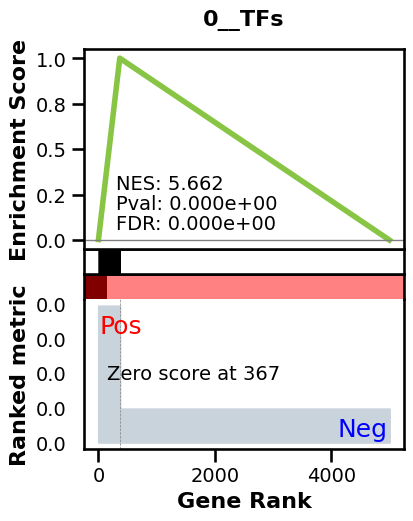

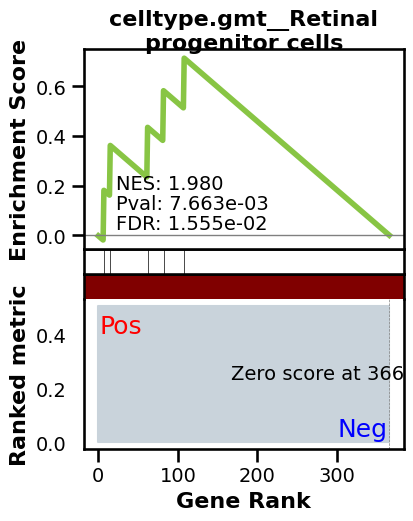

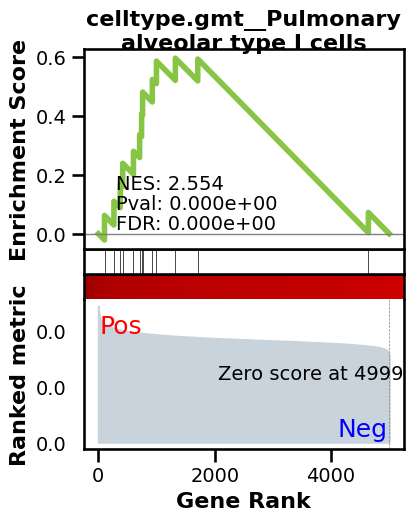

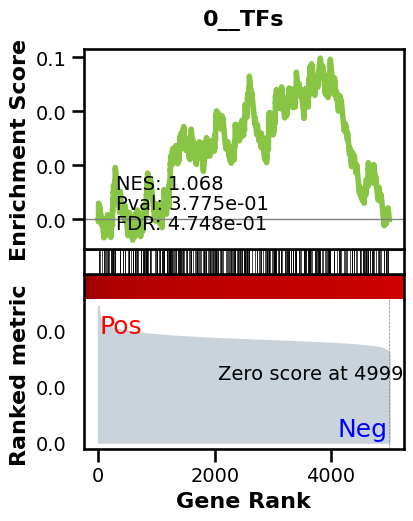

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.729
precision:  0.00664551720623272 
recall:  0.4113564668769716 
random precision: 0.0014319722820759532



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 50.90it/s]


  9%|▉         | 12/128 [00:00<00:02, 50.96it/s]


 14%|█▍        | 18/128 [00:00<00:02, 50.93it/s]


 19%|█▉        | 24/128 [00:00<00:02, 50.89it/s]


 23%|██▎       | 30/128 [00:00<00:01, 50.83it/s]


 28%|██▊       | 36/128 [00:00<00:01, 50.86it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.85it/s]


 38%|███▊      | 48/128 [00:00<00:01, 50.86it/s]


 42%|████▏     | 54/128 [00:01<00:01, 50.90it/s]


 47%|████▋     | 60/128 [00:01<00:01, 50.94it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 50.93it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 50.92it/s]


 61%|██████    | 78/128 [00:01<00:00, 50.92it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 50.88it/s]


 70%|███████   | 90/128 [00:01<00:00, 50.86it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.88it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 50.91it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 50.86it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.83it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 50.86it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 50.87it/s]


100%|██████████| 128/128 [00:02<00:00, 50.87it/s]

Area Under Precision-Recall Curve (AUPRC):  0.004243791127917977
EPR: 5.617129687034624


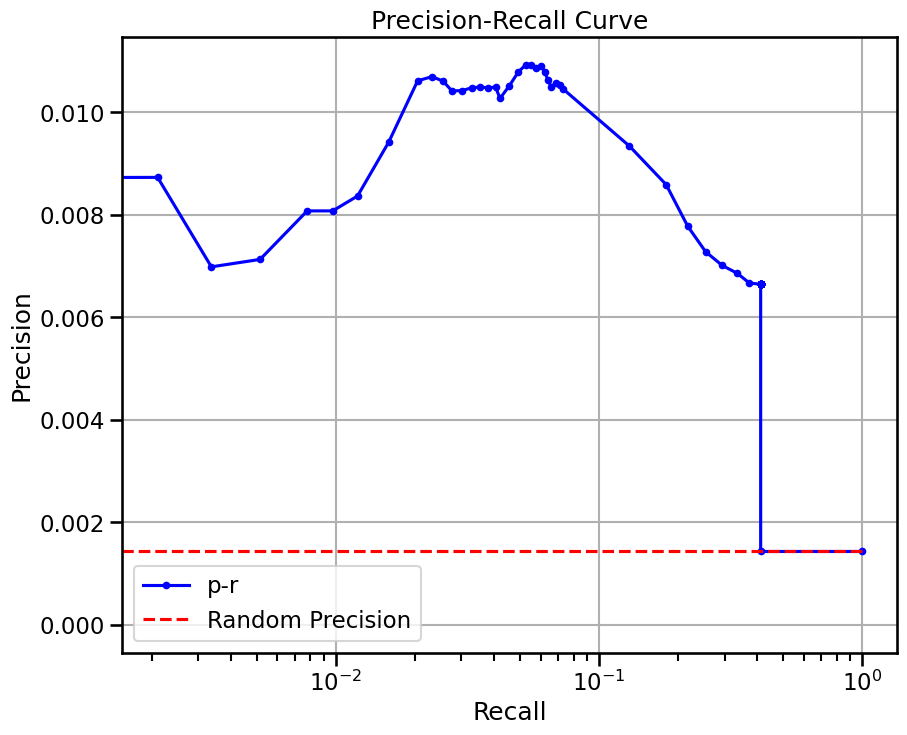


  0%|          | 0/46 [00:00<?, ?it/s]


  2%|▏         | 1/46 [00:00<00:30,  1.50it/s]


  4%|▍         | 2/46 [00:01<00:29,  1.49it/s]


  7%|▋         | 3/46 [00:02<00:28,  1.50it/s]


  9%|▊         | 4/46 [00:02<00:28,  1.50it/s]


 11%|█         | 5/46 [00:03<00:27,  1.50it/s]


 13%|█▎        | 6/46 [00:03<00:26,  1.50it/s]


 15%|█▌        | 7/46 [00:04<00:25,  1.50it/s]


 17%|█▋        | 8/46 [00:05<00:25,  1.50it/s]


 20%|█▉        | 9/46 [00:05<00:24,  1.50it/s]


 22%|██▏       | 10/46 [00:06<00:23,  1.50it/s]


 24%|██▍       | 11/46 [00:07<00:23,  1.50it/s]


 26%|██▌       | 12/46 [00:07<00:22,  1.50it/s]


 28%|██▊       | 13/46 [00:08<00:21,  1.50it/s]


 30%|███       | 14/46 [00:09<00:21,  1.51it/s]


 33%|███▎      | 15/46 [00:09<00:20,  1.51it/s]


 35%|███▍      | 16/46 [00:10<00:19,  1.51it/s]


 37%|███▋      | 17/46 [00:11<00:19,  1.51it/s]


 39%|███▉      | 18/46 [00:11<00:18,  1.51it/s]


 41%|████▏     | 19/46 [00:12<00:17,  1.51it/s]


 43%|████▎     | 20/46 [00:13<00:17,  1.51it/s]


 46%|████▌     | 21/46 [00:13<00:16,  1.51it/s]


 48%|████▊     | 22/46 [00:14<00:15,  1.51it/s]


 50%|█████     | 23/46 [00:15<00:15,  1.51it/s]


 52%|█████▏    | 24/46 [00:15<00:14,  1.51it/s]


 54%|█████▍    | 25/46 [00:16<00:13,  1.51it/s]


 57%|█████▋    | 26/46 [00:17<00:13,  1.51it/s]


 59%|█████▊    | 27/46 [00:17<00:12,  1.51it/s]


 61%|██████    | 28/46 [00:18<00:11,  1.51it/s]


 63%|██████▎   | 29/46 [00:19<00:11,  1.51it/s]


 65%|██████▌   | 30/46 [00:19<00:10,  1.51it/s]


 67%|██████▋   | 31/46 [00:20<00:09,  1.51it/s]


 70%|██████▉   | 32/46 [00:21<00:09,  1.51it/s]


 72%|███████▏  | 33/46 [00:21<00:08,  1.51it/s]


 74%|███████▍  | 34/46 [00:22<00:07,  1.51it/s]


 76%|███████▌  | 35/46 [00:23<00:07,  1.50it/s]


 78%|███████▊  | 36/46 [00:23<00:06,  1.50it/s]


 80%|████████  | 37/46 [00:24<00:05,  1.50it/s]


 83%|████████▎ | 38/46 [00:25<00:05,  1.50it/s]


 85%|████████▍ | 39/46 [00:25<00:04,  1.50it/s]


 87%|████████▋ | 40/46 [00:26<00:03,  1.50it/s]


 89%|████████▉ | 41/46 [00:27<00:03,  1.50it/s]


 91%|█████████▏| 42/46 [00:27<00:02,  1.50it/s]


 93%|█████████▎| 43/46 [00:28<00:01,  1.50it/s]


 96%|█████████▌| 44/46 [00:29<00:01,  1.50it/s]


 98%|█████████▊| 45/46 [00:29<00:00,  1.50it/s]


100%|██████████| 46/46 [00:30<00:00,  1.50it/s]


100%|██████████| 46/46 [00:30<00:00,  1.50it/s]

base enrichment


Top central genes: []


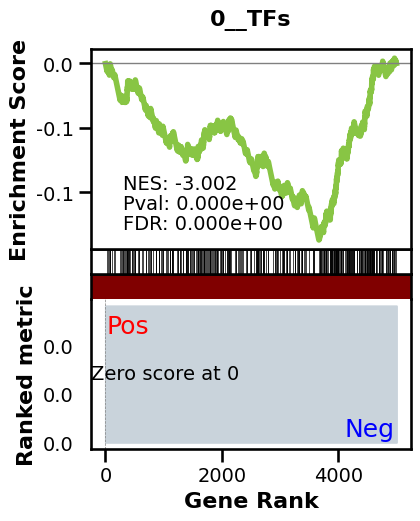

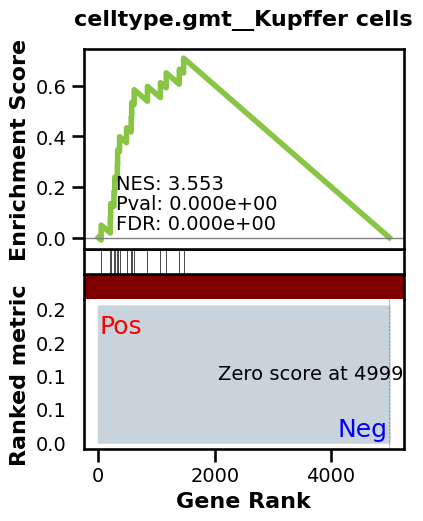

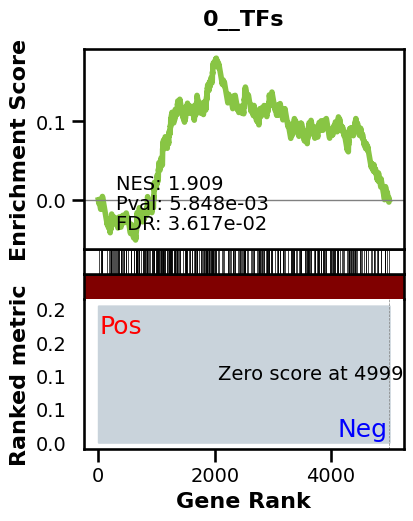

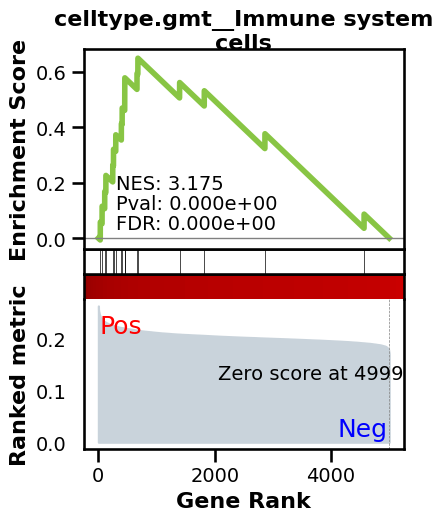

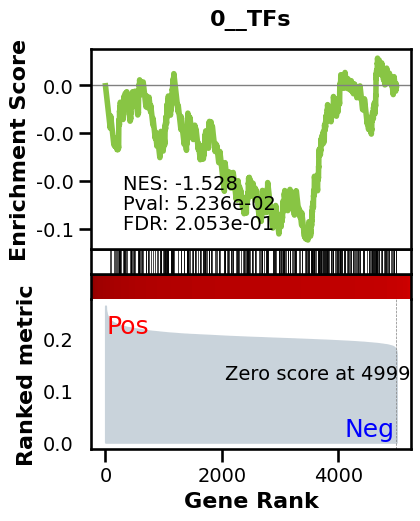

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3764 genes
intersection pct: 0.7528
precision:  0.0018323374527516683 
recall:  1.0 
random precision: 0.0018328243880301035



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 45.27it/s]


  8%|▊         | 10/128 [00:00<00:02, 45.25it/s]


 12%|█▏        | 15/128 [00:00<00:02, 45.23it/s]


 16%|█▌        | 20/128 [00:00<00:02, 45.24it/s]


 20%|█▉        | 25/128 [00:00<00:02, 45.27it/s]


 23%|██▎       | 30/128 [00:00<00:02, 45.28it/s]


 27%|██▋       | 35/128 [00:00<00:02, 45.24it/s]


 31%|███▏      | 40/128 [00:00<00:01, 45.28it/s]


 35%|███▌      | 45/128 [00:00<00:01, 45.09it/s]


 39%|███▉      | 50/128 [00:01<00:01, 45.16it/s]


 43%|████▎     | 55/128 [00:01<00:01, 45.16it/s]


 47%|████▋     | 60/128 [00:01<00:01, 45.19it/s]


 51%|█████     | 65/128 [00:01<00:01, 45.20it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 45.16it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 45.28it/s]


 62%|██████▎   | 80/128 [00:01<00:01, 45.21it/s]


 66%|██████▋   | 85/128 [00:01<00:00, 45.13it/s]


 70%|███████   | 90/128 [00:01<00:00, 45.06it/s]


 74%|███████▍  | 95/128 [00:02<00:00, 45.02it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 44.96it/s]


 82%|████████▏ | 105/128 [00:02<00:00, 44.95it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 44.96it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 44.97it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 44.95it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 44.93it/s]


100%|██████████| 128/128 [00:02<00:00, 45.10it/s]

Area Under Precision-Recall Curve (AUPRC):  0.002221881474813822
EPR: 1.1988515685165522


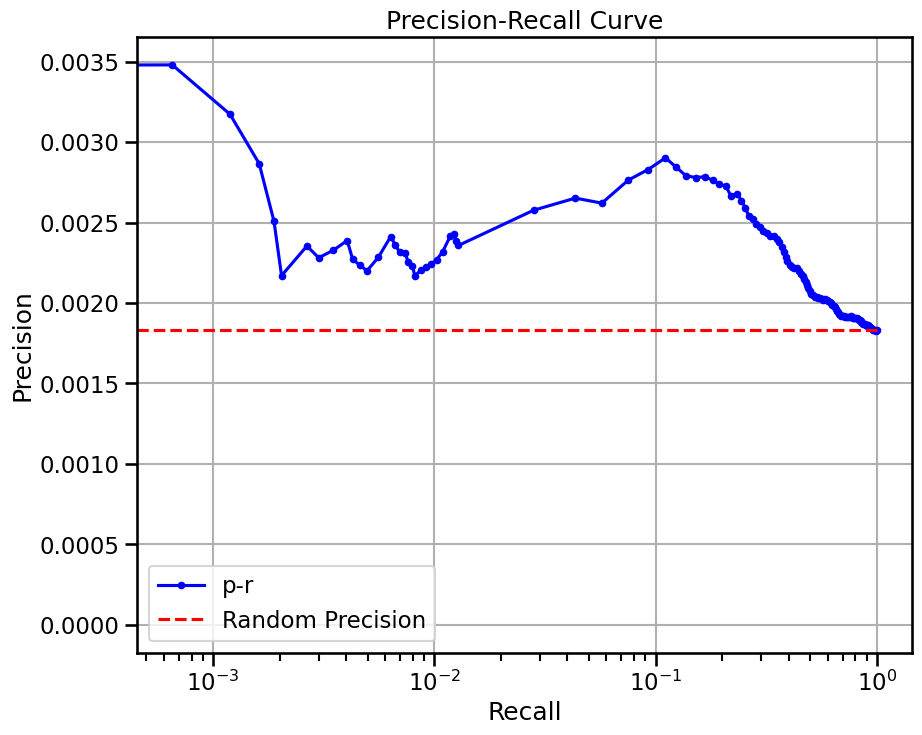

base enrichment


Top central genes: []


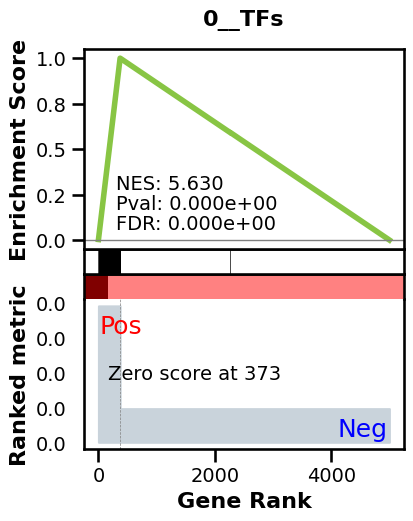

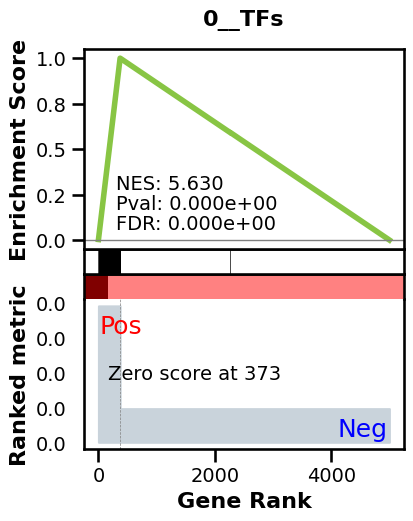

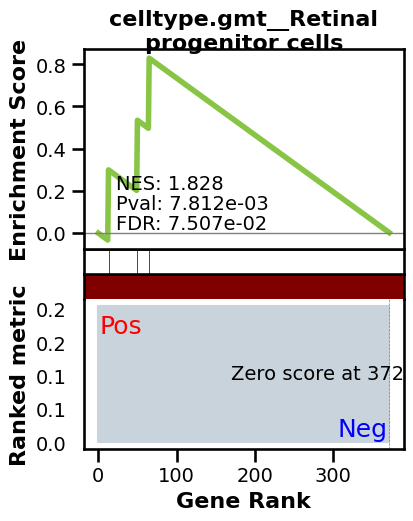

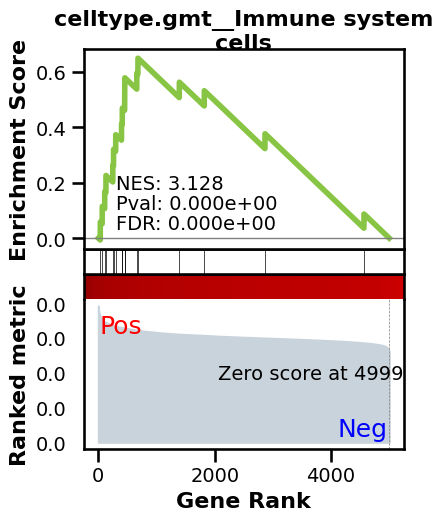

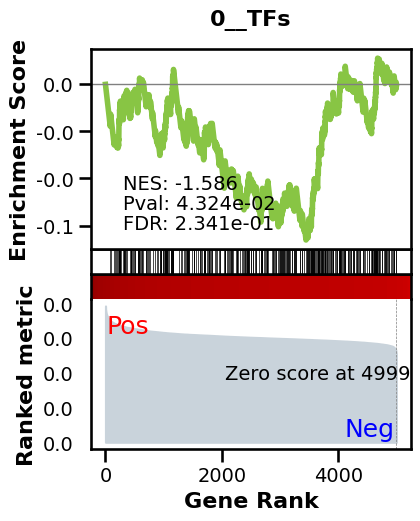

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3764 genes
intersection pct: 0.7528
precision:  0.009202009467684283 
recall:  0.4549691833590139 
random precision: 0.0018328243880301035



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 45.59it/s]


  8%|▊         | 10/128 [00:00<00:02, 45.56it/s]


 12%|█▏        | 15/128 [00:00<00:02, 45.60it/s]


 16%|█▌        | 20/128 [00:00<00:02, 45.65it/s]


 20%|█▉        | 25/128 [00:00<00:02, 45.66it/s]


 23%|██▎       | 30/128 [00:00<00:02, 45.66it/s]


 27%|██▋       | 35/128 [00:00<00:02, 45.63it/s]


 31%|███▏      | 40/128 [00:00<00:01, 45.59it/s]


 35%|███▌      | 45/128 [00:00<00:01, 45.61it/s]


 39%|███▉      | 50/128 [00:01<00:01, 45.61it/s]


 43%|████▎     | 55/128 [00:01<00:01, 45.63it/s]


 47%|████▋     | 60/128 [00:01<00:01, 45.65it/s]


 51%|█████     | 65/128 [00:01<00:01, 45.67it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 45.65it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 45.66it/s]


 62%|██████▎   | 80/128 [00:01<00:01, 45.66it/s]


 66%|██████▋   | 85/128 [00:01<00:00, 45.62it/s]


 70%|███████   | 90/128 [00:01<00:00, 45.63it/s]


 74%|███████▍  | 95/128 [00:02<00:00, 45.63it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 45.61it/s]


 82%|████████▏ | 105/128 [00:02<00:00, 45.59it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 45.58it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 45.61it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 45.63it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 45.64it/s]


100%|██████████| 128/128 [00:02<00:00, 45.62it/s]

Area Under Precision-Recall Curve (AUPRC):  0.006430670936766949
EPR: 9.019739985716402


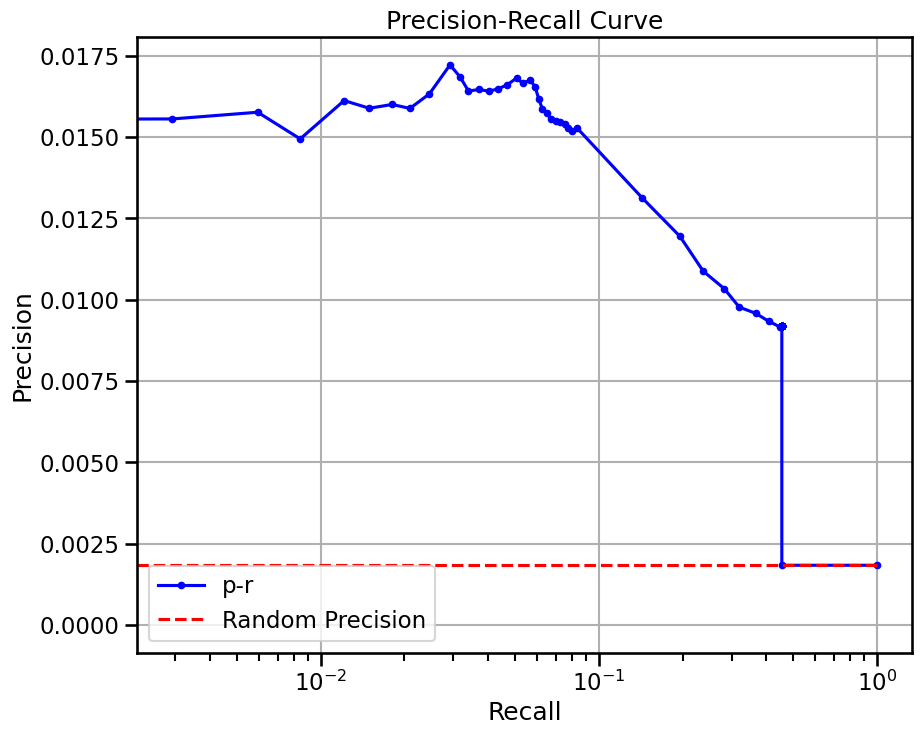

In [7]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype].tolist()
    to_use = [i for i in to_use if i in genes]
    to_use = to_use[:NUM_GENES]
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 5, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()
    gc.collect()
    torch.cuda.empty_cache()


In [8]:
metrics

{'scGPT_retinal rod cell': {'significant_enriched_TFtargets': 0.0,
  'precision': 0.0007864897886925406,
  'recall': 1.0,
  'rand_precision': 0.0007878319214377497,
  'auprc': 0.0010305593982646356,
  'epr': 0.0},
 'scGPT_tf_retinal rod cell': {'enriched_terms_Central': ['0__TFs'],
  'TF_enr': True,
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.005719153078607934,
  'recall': 0.5202952029520295,
  'rand_precision': 0.0007878319214377497,
  'auprc': 0.005335114997087407,
  'epr': 9.492461408769918},
 'scGPT_Mueller cell': {'TF_enr': True,
  'enriched_terms_Targets': ['0__TFs',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Kupffer cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__ISG expressing immune cells',
   'celltype.gmt__Retinal progenitor cells',
   'celltype.gmt__Neutrophils',
   'celltype.gmt__Pulmonary alveolar type II cells',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Muller cells'],
  'enric

In [9]:
import pandas as pd

In [10]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

name       EPR     AUPRC      RAND  TF_targ  TF_enr  \
0         retinal rod cell  0.000000  0.001031  0.000788      0.0   False   
1         retinal rod cell  9.492461  0.005335  0.000788      0.0    True   
2             Mueller cell  1.243361  0.001536  0.001375      0.0    True   
3             Mueller cell  5.395052  0.003977  0.001375      0.0    True   
4            amacrine cell  1.378360  0.000933  0.000820      0.0    True   
5            amacrine cell  4.502569  0.001506  0.000820      0.0    True   
6          ON-bipolar cell  3.036501  0.000777  0.000698      0.0    True   
7          ON-bipolar cell  4.666506  0.001141  0.000698      0.0    True   
8         rod bipolar cell  3.401892  0.000766  0.000673      0.0    True   
9         rod bipolar cell  3.401892  0.001000  0.000673      0.0    True   
10       retinal cone cell  1.915495  0.000825  0.000768      0.0    True   
11       retinal cone cell  4.671547  0.001472  0.000768      0.0    True   
12  retina horizontal cell  0.528558  0.001152  0.001025      0.0    True   
13  retina horizontal cell  4.184044  0.002011  0.001025      0.0    True   
14   retinal ganglion cell  0.813916  0.001100  0.000953      0.0    True   
15   retinal ganglion cell  5.087322  0.001545  0.000953      0.0    True   
16               astrocyte  0.623499  0.001667  0.001432      0.0    True   
17               astrocyte  5.617130  0.004244  0.001432      0.0    True   
18         microglial cell  1.198852  0.002222  0.001833      0.0    True   
19         microglial cell  9.019740  0.006431  0.001833      0.0    True   

    TF_only  
0     False  
1      True  
2     False  
3      True  
4     False  
5      True  
6     False  
7      True  
8     False  
9      True  
10    False  
11     True  
12    False  
13     True  
14    False  
15     True  
16    False  
17     True  
18    False  
19     True